# Convolutional Autoencoder

Sticking with the MNIST dataset, let's improve our autoencoder's performance using convolutional layers. Again, loading modules and the data.

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


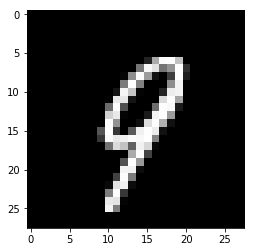

In [3]:
img = mnist.train.images[22]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

## Network Architecture

The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions of the layers. The decoder though might be something new to you. The decoder needs to convert from a narrow representation to a wide reconstructed image. For example, the representation could be a 4x4x8 max-pool layer. This is the output of the encoder, but also the input to the decoder. We want to get a 28x28x1 image out from the decoder so we need to work our way back up from the narrow decoder input layer. A schematic of the network is shown below.

<img src='assets/convolutional_autoencoder.png' width=500px>

Here our final encoder layer has size 4x4x8 = 128. The original images have size 28x28 = 784, so the encoded vector is roughly 16% the size of the original image. These are just suggested sizes for each of the layers. Feel free to change the depths and sizes, but remember our goal here is to find a small representation of the input data.

### What's going on with the decoder

Okay, so the decoder has these "Upsample" layers that you might not have seen before. First off, I'll discuss a bit what these layers *aren't*. Usually, you'll see **transposed convolution** layers used to increase the width and height of the layers. They work almost exactly the same as convolutional layers, but in reverse. A stride in the input layer results in a larger stride in the transposed convolution layer. For example, if you have a 3x3 kernel, a 3x3 patch in the input layer will be reduced to one unit in a convolutional layer. Comparatively, one unit in the input layer will be expanded to a 3x3 path in a transposed convolution layer. The TensorFlow API provides us with an easy way to create the layers, [`tf.nn.conv2d_transpose`](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). 

However, transposed convolution layers can lead to artifacts in the final images, such as checkerboard patterns. This is due to overlap in the kernels which can be avoided by setting the stride and kernel size equal. In [this Distill article](http://distill.pub/2016/deconv-checkerboard/) from Augustus Odena, *et al*, the authors show that these checkerboard artifacts can be avoided by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer. In TensorFlow, this is easily done with [`tf.image.resize_images`](https://www.tensorflow.org/versions/r1.1/api_docs/python/tf/image/resize_images), followed by a convolution. Be sure to read the Distill article to get a better understanding of deconvolutional layers and why we're using upsampling.

> **Exercise:** Build the network shown above. Remember that a convolutional layer with strides of 1 and 'same' padding won't reduce the height and width. That is, if the input is 28x28 and the convolution layer has stride = 1 and 'same' padding, the convolutional layer will also be 28x28. The max-pool layers are used the reduce the width and height. A stride of 2 will reduce the size by a factor of 2. Odena *et al* claim that nearest neighbor interpolation works best for the upsampling, so make sure to include that as a parameter in `tf.image.resize_images` or use [`tf.image.resize_nearest_neighbor`]( `https://www.tensorflow.org/api_docs/python/tf/image/resize_nearest_neighbor). For convolutional layers, use [`tf.layers.conv2d`](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d). For example, you would write `conv1 = tf.layers.conv2d(inputs, 32, (5,5), padding='same', activation=tf.nn.relu)` for a layer with a depth of 32, a 5x5 kernel, stride of (1,1), padding is 'same', and a ReLU activation. Similarly, for the max-pool layers, use [`tf.layers.max_pooling2d`](https://www.tensorflow.org/api_docs/python/tf/layers/max_pooling2d).

In [4]:
learning_rate = 0.001
# Input and target placeholders
image_size = (10,28,28,1)
inputs_ = tf.placeholder(tf.float32, shape=image_size, name='Inputs')
targets_ = tf.placeholder(tf.float32, shape=image_size, name="Targets")

### Encoder
conv1 = tf.layers.conv2d(inputs_, filters=16,kernel_size=(5,5), padding="same",activation=tf.nn.relu )
# Now 28x28x16
maxpool1 = tf.layers.max_pooling2d(conv1, pool_size=(2,2), strides=(2,2), padding="same" )
# Now 14x14x16
conv2 =  tf.layers.conv2d(maxpool1, filters=8,kernel_size=(5,5), padding="same",activation=tf.nn.relu )
# Now 14x14x8
maxpool2 = tf.layers.max_pooling2d(conv2, pool_size=(2,2), strides=(2,2), padding="same" )
# Now 7x7x8
conv3 = tf.layers.conv2d(maxpool2, filters=8,kernel_size=(5,5), padding="same",activation=tf.nn.relu )
# Now 7x7x8
encoded = tf.layers.max_pooling2d(conv3, pool_size=(2,2), strides=(2,2), padding="same" )
# Now 4x4x8

### Decoder
"""
upsample1 = tf.image.resize_nearest_neighbor(encoded,size=(7,7))
# Now 7x7x8
conv4 =  tf.layers.conv2d(upsample1, filters=8,kernel_size=(5,5), padding="same",activation=tf.nn.relu )
# Now 7x7x8
upsample2 = tf.image.resize_nearest_neighbor(conv4,size=(14,14))
# Now 14x14x8
conv5 = tf.layers.conv2d(upsample2, filters=8,kernel_size=(5,5), padding="same",activation=tf.nn.relu )
# Now 14x14x8
upsample3 = tf.image.resize_nearest_neighbor(conv5,size=(28,28))
# Now 28x28x8
conv6 = tf.layers.conv2d(upsample3, filters=16,kernel_size=(5,5), padding="same",activation=tf.nn.relu )
# Now 28x28x16
"""

'\nupsample1 = tf.image.resize_nearest_neighbor(encoded,size=(7,7))\n# Now 7x7x8\nconv4 =  tf.layers.conv2d(upsample1, filters=8,kernel_size=(5,5), padding="same",activation=tf.nn.relu )\n# Now 7x7x8\nupsample2 = tf.image.resize_nearest_neighbor(conv4,size=(14,14))\n# Now 14x14x8\nconv5 = tf.layers.conv2d(upsample2, filters=8,kernel_size=(5,5), padding="same",activation=tf.nn.relu )\n# Now 14x14x8\nupsample3 = tf.image.resize_nearest_neighbor(conv5,size=(28,28))\n# Now 28x28x8\nconv6 = tf.layers.conv2d(upsample3, filters=16,kernel_size=(5,5), padding="same",activation=tf.nn.relu )\n# Now 28x28x16\n'

In [5]:
# using tf.nn.conv2d_transpose

temp_batch_size = 10

weights = {
  'wdc1' : tf.Variable(tf.random_normal([3, 3, 8, 8])),
  'wdc2' : tf.Variable(tf.random_normal([3, 3, 8, 8])),
  'wdc3' : tf.Variable(tf.random_normal([3, 3, 16, 8]))
}

# Now 4x4x8
output_shape = [temp_batch_size, 7, 7, 8]
conv4 = tf.nn.conv2d_transpose(encoded, weights['wdc1'], output_shape=output_shape, strides=[1,2,2,1], padding="SAME")
print(conv4.shape)
# Now 7x7x8
output_shape = [temp_batch_size, 14, 14, 8]
conv5 = tf.nn.conv2d_transpose(conv4, weights['wdc2'], output_shape=output_shape, strides=[1,2,2,1], padding="SAME")
print(conv5.shape)
#Now 14x14x8
output_shape = [temp_batch_size, 28, 28, 16]
conv6 = tf.nn.conv2d_transpose(conv5, weights['wdc3'], output_shape=output_shape, strides=[1,2,2,1], padding="SAME")
print(conv6.shape)

(10, 7, 7, 8)
(10, 14, 14, 8)
(10, 28, 28, 16)


In [6]:
logits =  tf.layers.conv2d(conv6, 1, (3,3), padding='same', activation=None)
print(logits.shape)
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded = tf.nn.sigmoid(logits)

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

(10, 28, 28, 1)


## Training

As before, here we'll train the network. Instead of flattening the images though, we can pass them in as 28x28x1 arrays.

In [7]:
sess = tf.Session()

In [8]:
epochs = 10
batch_size = 10
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        imgs = batch[0].reshape((-1, 28, 28, 1))
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/10... Training loss: 3.0018
Epoch: 1/10... Training loss: 2.2082
Epoch: 1/10... Training loss: 1.7594
Epoch: 1/10... Training loss: 1.3509
Epoch: 1/10... Training loss: 1.0769
Epoch: 1/10... Training loss: 0.9323
Epoch: 1/10... Training loss: 0.8487
Epoch: 1/10... Training loss: 0.7777
Epoch: 1/10... Training loss: 0.7566
Epoch: 1/10... Training loss: 0.7296
Epoch: 1/10... Training loss: 0.7160
Epoch: 1/10... Training loss: 0.7067
Epoch: 1/10... Training loss: 0.6996
Epoch: 1/10... Training loss: 0.6949
Epoch: 1/10... Training loss: 0.6923
Epoch: 1/10... Training loss: 0.6900
Epoch: 1/10... Training loss: 0.6904
Epoch: 1/10... Training loss: 0.6887
Epoch: 1/10... Training loss: 0.6879
Epoch: 1/10... Training loss: 0.6869
Epoch: 1/10... Training loss: 0.6864
Epoch: 1/10... Training loss: 0.6858
Epoch: 1/10... Training loss: 0.6852
Epoch: 1/10... Training loss: 0.6852
Epoch: 1/10... Training loss: 0.6847
Epoch: 1/10... Training loss: 0.6844
Epoch: 1/10... Training loss: 0.6837
E

Epoch: 1/10... Training loss: 0.6161
Epoch: 1/10... Training loss: 0.6126
Epoch: 1/10... Training loss: 0.6107
Epoch: 1/10... Training loss: 0.6125
Epoch: 1/10... Training loss: 0.6084
Epoch: 1/10... Training loss: 0.6108
Epoch: 1/10... Training loss: 0.6098
Epoch: 1/10... Training loss: 0.6139
Epoch: 1/10... Training loss: 0.6064
Epoch: 1/10... Training loss: 0.6076
Epoch: 1/10... Training loss: 0.6057
Epoch: 1/10... Training loss: 0.6070
Epoch: 1/10... Training loss: 0.6031
Epoch: 1/10... Training loss: 0.6040
Epoch: 1/10... Training loss: 0.6094
Epoch: 1/10... Training loss: 0.6018
Epoch: 1/10... Training loss: 0.6075
Epoch: 1/10... Training loss: 0.6082
Epoch: 1/10... Training loss: 0.6053
Epoch: 1/10... Training loss: 0.6082
Epoch: 1/10... Training loss: 0.6024
Epoch: 1/10... Training loss: 0.6047
Epoch: 1/10... Training loss: 0.6078
Epoch: 1/10... Training loss: 0.6037
Epoch: 1/10... Training loss: 0.6049
Epoch: 1/10... Training loss: 0.6053
Epoch: 1/10... Training loss: 0.5986
E

Epoch: 1/10... Training loss: 0.3972
Epoch: 1/10... Training loss: 0.3679
Epoch: 1/10... Training loss: 0.3570
Epoch: 1/10... Training loss: 0.3814
Epoch: 1/10... Training loss: 0.3280
Epoch: 1/10... Training loss: 0.3286
Epoch: 1/10... Training loss: 0.3266
Epoch: 1/10... Training loss: 0.3243
Epoch: 1/10... Training loss: 0.3337
Epoch: 1/10... Training loss: 0.3476
Epoch: 1/10... Training loss: 0.3270
Epoch: 1/10... Training loss: 0.3419
Epoch: 1/10... Training loss: 0.3734
Epoch: 1/10... Training loss: 0.3288
Epoch: 1/10... Training loss: 0.3647
Epoch: 1/10... Training loss: 0.3305
Epoch: 1/10... Training loss: 0.3341
Epoch: 1/10... Training loss: 0.2861
Epoch: 1/10... Training loss: 0.3496
Epoch: 1/10... Training loss: 0.3021
Epoch: 1/10... Training loss: 0.2727
Epoch: 1/10... Training loss: 0.2833
Epoch: 1/10... Training loss: 0.2663
Epoch: 1/10... Training loss: 0.3037
Epoch: 1/10... Training loss: 0.2921
Epoch: 1/10... Training loss: 0.2958
Epoch: 1/10... Training loss: 0.2917
E

Epoch: 1/10... Training loss: 0.2097
Epoch: 1/10... Training loss: 0.2105
Epoch: 1/10... Training loss: 0.2042
Epoch: 1/10... Training loss: 0.2451
Epoch: 1/10... Training loss: 0.2115
Epoch: 1/10... Training loss: 0.1967
Epoch: 1/10... Training loss: 0.2138
Epoch: 1/10... Training loss: 0.2422
Epoch: 1/10... Training loss: 0.2080
Epoch: 1/10... Training loss: 0.2177
Epoch: 1/10... Training loss: 0.1916
Epoch: 1/10... Training loss: 0.2247
Epoch: 1/10... Training loss: 0.2322
Epoch: 1/10... Training loss: 0.2189
Epoch: 1/10... Training loss: 0.2333
Epoch: 1/10... Training loss: 0.1914
Epoch: 1/10... Training loss: 0.2122
Epoch: 1/10... Training loss: 0.2044
Epoch: 1/10... Training loss: 0.2264
Epoch: 1/10... Training loss: 0.2072
Epoch: 1/10... Training loss: 0.2258
Epoch: 1/10... Training loss: 0.1945
Epoch: 1/10... Training loss: 0.1982
Epoch: 1/10... Training loss: 0.2180
Epoch: 1/10... Training loss: 0.2190
Epoch: 1/10... Training loss: 0.2021
Epoch: 1/10... Training loss: 0.1826
E

Epoch: 1/10... Training loss: 0.1878
Epoch: 1/10... Training loss: 0.2035
Epoch: 1/10... Training loss: 0.1922
Epoch: 1/10... Training loss: 0.2070
Epoch: 1/10... Training loss: 0.2141
Epoch: 1/10... Training loss: 0.1876
Epoch: 1/10... Training loss: 0.1715
Epoch: 1/10... Training loss: 0.2079
Epoch: 1/10... Training loss: 0.1787
Epoch: 1/10... Training loss: 0.1882
Epoch: 1/10... Training loss: 0.2196
Epoch: 1/10... Training loss: 0.2261
Epoch: 1/10... Training loss: 0.1861
Epoch: 1/10... Training loss: 0.1708
Epoch: 1/10... Training loss: 0.2106
Epoch: 1/10... Training loss: 0.2003
Epoch: 1/10... Training loss: 0.2018
Epoch: 1/10... Training loss: 0.1871
Epoch: 1/10... Training loss: 0.1894
Epoch: 1/10... Training loss: 0.2074
Epoch: 1/10... Training loss: 0.1919
Epoch: 1/10... Training loss: 0.1987
Epoch: 1/10... Training loss: 0.1902
Epoch: 1/10... Training loss: 0.2073
Epoch: 1/10... Training loss: 0.1961
Epoch: 1/10... Training loss: 0.1818
Epoch: 1/10... Training loss: 0.2145
E

Epoch: 1/10... Training loss: 0.1904
Epoch: 1/10... Training loss: 0.1810
Epoch: 1/10... Training loss: 0.1823
Epoch: 1/10... Training loss: 0.2016
Epoch: 1/10... Training loss: 0.1805
Epoch: 1/10... Training loss: 0.1867
Epoch: 1/10... Training loss: 0.2141
Epoch: 1/10... Training loss: 0.1953
Epoch: 1/10... Training loss: 0.2073
Epoch: 1/10... Training loss: 0.1883
Epoch: 1/10... Training loss: 0.1856
Epoch: 1/10... Training loss: 0.2049
Epoch: 1/10... Training loss: 0.1957
Epoch: 1/10... Training loss: 0.2113
Epoch: 1/10... Training loss: 0.1439
Epoch: 1/10... Training loss: 0.1919
Epoch: 1/10... Training loss: 0.1832
Epoch: 1/10... Training loss: 0.2174
Epoch: 1/10... Training loss: 0.2150
Epoch: 1/10... Training loss: 0.1754
Epoch: 1/10... Training loss: 0.1819
Epoch: 1/10... Training loss: 0.1770
Epoch: 1/10... Training loss: 0.1918
Epoch: 1/10... Training loss: 0.1962
Epoch: 1/10... Training loss: 0.1710
Epoch: 1/10... Training loss: 0.1955
Epoch: 1/10... Training loss: 0.1882
E

Epoch: 1/10... Training loss: 0.1656
Epoch: 1/10... Training loss: 0.2043
Epoch: 1/10... Training loss: 0.1626
Epoch: 1/10... Training loss: 0.1606
Epoch: 1/10... Training loss: 0.1799
Epoch: 1/10... Training loss: 0.1886
Epoch: 1/10... Training loss: 0.1839
Epoch: 1/10... Training loss: 0.1853
Epoch: 1/10... Training loss: 0.1503
Epoch: 1/10... Training loss: 0.1920
Epoch: 1/10... Training loss: 0.1919
Epoch: 1/10... Training loss: 0.1705
Epoch: 1/10... Training loss: 0.1390
Epoch: 1/10... Training loss: 0.1689
Epoch: 1/10... Training loss: 0.1871
Epoch: 1/10... Training loss: 0.1734
Epoch: 1/10... Training loss: 0.1739
Epoch: 1/10... Training loss: 0.1692
Epoch: 1/10... Training loss: 0.1797
Epoch: 1/10... Training loss: 0.1542
Epoch: 1/10... Training loss: 0.1710
Epoch: 1/10... Training loss: 0.1496
Epoch: 1/10... Training loss: 0.1850
Epoch: 1/10... Training loss: 0.1890
Epoch: 1/10... Training loss: 0.1680
Epoch: 1/10... Training loss: 0.2008
Epoch: 1/10... Training loss: 0.1845
E

Epoch: 1/10... Training loss: 0.1992
Epoch: 1/10... Training loss: 0.1685
Epoch: 1/10... Training loss: 0.1744
Epoch: 1/10... Training loss: 0.1552
Epoch: 1/10... Training loss: 0.1732
Epoch: 1/10... Training loss: 0.1867
Epoch: 1/10... Training loss: 0.1605
Epoch: 1/10... Training loss: 0.1723
Epoch: 1/10... Training loss: 0.1946
Epoch: 1/10... Training loss: 0.1629
Epoch: 1/10... Training loss: 0.1490
Epoch: 1/10... Training loss: 0.1814
Epoch: 1/10... Training loss: 0.2165
Epoch: 1/10... Training loss: 0.1414
Epoch: 1/10... Training loss: 0.1646
Epoch: 1/10... Training loss: 0.1958
Epoch: 1/10... Training loss: 0.1763
Epoch: 1/10... Training loss: 0.1677
Epoch: 1/10... Training loss: 0.1809
Epoch: 1/10... Training loss: 0.1733
Epoch: 1/10... Training loss: 0.1858
Epoch: 1/10... Training loss: 0.1765
Epoch: 1/10... Training loss: 0.1722
Epoch: 1/10... Training loss: 0.1723
Epoch: 1/10... Training loss: 0.2026
Epoch: 1/10... Training loss: 0.2177
Epoch: 1/10... Training loss: 0.1674
E

Epoch: 1/10... Training loss: 0.1759
Epoch: 1/10... Training loss: 0.1447
Epoch: 1/10... Training loss: 0.1649
Epoch: 1/10... Training loss: 0.1677
Epoch: 1/10... Training loss: 0.1403
Epoch: 1/10... Training loss: 0.1750
Epoch: 1/10... Training loss: 0.1812
Epoch: 1/10... Training loss: 0.1919
Epoch: 1/10... Training loss: 0.1974
Epoch: 1/10... Training loss: 0.1902
Epoch: 1/10... Training loss: 0.1763
Epoch: 1/10... Training loss: 0.1735
Epoch: 1/10... Training loss: 0.1563
Epoch: 1/10... Training loss: 0.1658
Epoch: 1/10... Training loss: 0.1616
Epoch: 1/10... Training loss: 0.1623
Epoch: 1/10... Training loss: 0.1630
Epoch: 1/10... Training loss: 0.2004
Epoch: 1/10... Training loss: 0.1731
Epoch: 1/10... Training loss: 0.1896
Epoch: 1/10... Training loss: 0.1707
Epoch: 1/10... Training loss: 0.1547
Epoch: 1/10... Training loss: 0.1530
Epoch: 1/10... Training loss: 0.1502
Epoch: 1/10... Training loss: 0.1608
Epoch: 1/10... Training loss: 0.1649
Epoch: 1/10... Training loss: 0.1678
E

Epoch: 1/10... Training loss: 0.1709
Epoch: 1/10... Training loss: 0.1614
Epoch: 1/10... Training loss: 0.1418
Epoch: 1/10... Training loss: 0.1381
Epoch: 1/10... Training loss: 0.1659
Epoch: 1/10... Training loss: 0.1696
Epoch: 1/10... Training loss: 0.1700
Epoch: 1/10... Training loss: 0.1747
Epoch: 1/10... Training loss: 0.1826
Epoch: 1/10... Training loss: 0.1773
Epoch: 1/10... Training loss: 0.1864
Epoch: 1/10... Training loss: 0.1745
Epoch: 1/10... Training loss: 0.1753
Epoch: 1/10... Training loss: 0.1790
Epoch: 1/10... Training loss: 0.1418
Epoch: 1/10... Training loss: 0.1584
Epoch: 1/10... Training loss: 0.1410
Epoch: 1/10... Training loss: 0.1644
Epoch: 1/10... Training loss: 0.1568
Epoch: 1/10... Training loss: 0.1378
Epoch: 1/10... Training loss: 0.1745
Epoch: 1/10... Training loss: 0.1637
Epoch: 1/10... Training loss: 0.1802
Epoch: 1/10... Training loss: 0.1642
Epoch: 1/10... Training loss: 0.1503
Epoch: 1/10... Training loss: 0.1516
Epoch: 1/10... Training loss: 0.1356
E

Epoch: 1/10... Training loss: 0.1634
Epoch: 1/10... Training loss: 0.1326
Epoch: 1/10... Training loss: 0.1443
Epoch: 1/10... Training loss: 0.1580
Epoch: 1/10... Training loss: 0.1685
Epoch: 1/10... Training loss: 0.1554
Epoch: 1/10... Training loss: 0.1549
Epoch: 1/10... Training loss: 0.1379
Epoch: 1/10... Training loss: 0.1883
Epoch: 1/10... Training loss: 0.1497
Epoch: 1/10... Training loss: 0.1543
Epoch: 1/10... Training loss: 0.1540
Epoch: 1/10... Training loss: 0.1564
Epoch: 1/10... Training loss: 0.1678
Epoch: 1/10... Training loss: 0.1605
Epoch: 1/10... Training loss: 0.1660
Epoch: 1/10... Training loss: 0.1346
Epoch: 1/10... Training loss: 0.1791
Epoch: 1/10... Training loss: 0.1658
Epoch: 1/10... Training loss: 0.1870
Epoch: 1/10... Training loss: 0.1649
Epoch: 1/10... Training loss: 0.1759
Epoch: 1/10... Training loss: 0.1631
Epoch: 1/10... Training loss: 0.1441
Epoch: 1/10... Training loss: 0.1620
Epoch: 1/10... Training loss: 0.1555
Epoch: 1/10... Training loss: 0.1468
E

Epoch: 1/10... Training loss: 0.1454
Epoch: 1/10... Training loss: 0.1488
Epoch: 1/10... Training loss: 0.1207
Epoch: 1/10... Training loss: 0.1581
Epoch: 1/10... Training loss: 0.1600
Epoch: 1/10... Training loss: 0.1559
Epoch: 1/10... Training loss: 0.1474
Epoch: 1/10... Training loss: 0.1835
Epoch: 1/10... Training loss: 0.1488
Epoch: 1/10... Training loss: 0.1712
Epoch: 1/10... Training loss: 0.1492
Epoch: 1/10... Training loss: 0.1633
Epoch: 1/10... Training loss: 0.1502
Epoch: 1/10... Training loss: 0.1625
Epoch: 1/10... Training loss: 0.1269
Epoch: 1/10... Training loss: 0.1766
Epoch: 1/10... Training loss: 0.1591
Epoch: 1/10... Training loss: 0.1236
Epoch: 1/10... Training loss: 0.1707
Epoch: 1/10... Training loss: 0.1552
Epoch: 1/10... Training loss: 0.1521
Epoch: 1/10... Training loss: 0.1576
Epoch: 1/10... Training loss: 0.1325
Epoch: 1/10... Training loss: 0.1497
Epoch: 1/10... Training loss: 0.1487
Epoch: 1/10... Training loss: 0.1862
Epoch: 1/10... Training loss: 0.1382
E

Epoch: 1/10... Training loss: 0.1518
Epoch: 1/10... Training loss: 0.1356
Epoch: 1/10... Training loss: 0.1449
Epoch: 1/10... Training loss: 0.1341
Epoch: 1/10... Training loss: 0.1596
Epoch: 1/10... Training loss: 0.1501
Epoch: 1/10... Training loss: 0.1713
Epoch: 1/10... Training loss: 0.1496
Epoch: 1/10... Training loss: 0.1679
Epoch: 1/10... Training loss: 0.1603
Epoch: 1/10... Training loss: 0.1252
Epoch: 1/10... Training loss: 0.1342
Epoch: 1/10... Training loss: 0.1797
Epoch: 1/10... Training loss: 0.1580
Epoch: 1/10... Training loss: 0.1640
Epoch: 1/10... Training loss: 0.1214
Epoch: 1/10... Training loss: 0.1194
Epoch: 1/10... Training loss: 0.1345
Epoch: 1/10... Training loss: 0.1363
Epoch: 1/10... Training loss: 0.1436
Epoch: 1/10... Training loss: 0.1435
Epoch: 1/10... Training loss: 0.1680
Epoch: 1/10... Training loss: 0.1785
Epoch: 1/10... Training loss: 0.1528
Epoch: 1/10... Training loss: 0.1620
Epoch: 1/10... Training loss: 0.1675
Epoch: 1/10... Training loss: 0.1486
E

Epoch: 1/10... Training loss: 0.1716
Epoch: 1/10... Training loss: 0.1469
Epoch: 1/10... Training loss: 0.1572
Epoch: 1/10... Training loss: 0.1383
Epoch: 1/10... Training loss: 0.1655
Epoch: 1/10... Training loss: 0.1564
Epoch: 1/10... Training loss: 0.1437
Epoch: 1/10... Training loss: 0.1560
Epoch: 1/10... Training loss: 0.1589
Epoch: 1/10... Training loss: 0.1418
Epoch: 1/10... Training loss: 0.1495
Epoch: 1/10... Training loss: 0.1477
Epoch: 1/10... Training loss: 0.1490
Epoch: 1/10... Training loss: 0.1361
Epoch: 1/10... Training loss: 0.1592
Epoch: 1/10... Training loss: 0.1547
Epoch: 1/10... Training loss: 0.1491
Epoch: 1/10... Training loss: 0.1512
Epoch: 1/10... Training loss: 0.1199
Epoch: 1/10... Training loss: 0.1485
Epoch: 1/10... Training loss: 0.1530
Epoch: 1/10... Training loss: 0.1293
Epoch: 1/10... Training loss: 0.1446
Epoch: 1/10... Training loss: 0.1658
Epoch: 1/10... Training loss: 0.1532
Epoch: 1/10... Training loss: 0.1424
Epoch: 1/10... Training loss: 0.1530
E

Epoch: 1/10... Training loss: 0.1507
Epoch: 1/10... Training loss: 0.1474
Epoch: 1/10... Training loss: 0.1686
Epoch: 1/10... Training loss: 0.1454
Epoch: 1/10... Training loss: 0.1450
Epoch: 1/10... Training loss: 0.1430
Epoch: 1/10... Training loss: 0.1740
Epoch: 1/10... Training loss: 0.1674
Epoch: 1/10... Training loss: 0.1327
Epoch: 1/10... Training loss: 0.1479
Epoch: 1/10... Training loss: 0.1539
Epoch: 1/10... Training loss: 0.1523
Epoch: 1/10... Training loss: 0.1409
Epoch: 1/10... Training loss: 0.1497
Epoch: 1/10... Training loss: 0.1583
Epoch: 1/10... Training loss: 0.1542
Epoch: 1/10... Training loss: 0.1592
Epoch: 1/10... Training loss: 0.1514
Epoch: 1/10... Training loss: 0.1559
Epoch: 1/10... Training loss: 0.1739
Epoch: 1/10... Training loss: 0.1524
Epoch: 1/10... Training loss: 0.1469
Epoch: 1/10... Training loss: 0.1649
Epoch: 1/10... Training loss: 0.1482
Epoch: 1/10... Training loss: 0.1427
Epoch: 1/10... Training loss: 0.1448
Epoch: 1/10... Training loss: 0.1446
E

Epoch: 1/10... Training loss: 0.1510
Epoch: 1/10... Training loss: 0.1257
Epoch: 1/10... Training loss: 0.1493
Epoch: 1/10... Training loss: 0.1513
Epoch: 1/10... Training loss: 0.1544
Epoch: 1/10... Training loss: 0.1431
Epoch: 1/10... Training loss: 0.1591
Epoch: 1/10... Training loss: 0.1499
Epoch: 1/10... Training loss: 0.1348
Epoch: 1/10... Training loss: 0.1723
Epoch: 1/10... Training loss: 0.1475
Epoch: 1/10... Training loss: 0.1550
Epoch: 1/10... Training loss: 0.1278
Epoch: 1/10... Training loss: 0.1281
Epoch: 1/10... Training loss: 0.1352
Epoch: 1/10... Training loss: 0.1534
Epoch: 1/10... Training loss: 0.1393
Epoch: 1/10... Training loss: 0.1466
Epoch: 1/10... Training loss: 0.1335
Epoch: 1/10... Training loss: 0.1556
Epoch: 1/10... Training loss: 0.1467
Epoch: 1/10... Training loss: 0.1552
Epoch: 1/10... Training loss: 0.1559
Epoch: 1/10... Training loss: 0.1556
Epoch: 1/10... Training loss: 0.1750
Epoch: 1/10... Training loss: 0.1353
Epoch: 1/10... Training loss: 0.1622
E

Epoch: 1/10... Training loss: 0.1297
Epoch: 1/10... Training loss: 0.1621
Epoch: 1/10... Training loss: 0.1534
Epoch: 1/10... Training loss: 0.1423
Epoch: 1/10... Training loss: 0.1486
Epoch: 1/10... Training loss: 0.1431
Epoch: 1/10... Training loss: 0.1443
Epoch: 1/10... Training loss: 0.1241
Epoch: 1/10... Training loss: 0.1500
Epoch: 1/10... Training loss: 0.1317
Epoch: 1/10... Training loss: 0.1722
Epoch: 1/10... Training loss: 0.1531
Epoch: 1/10... Training loss: 0.1473
Epoch: 1/10... Training loss: 0.1516
Epoch: 1/10... Training loss: 0.1547
Epoch: 1/10... Training loss: 0.1463
Epoch: 1/10... Training loss: 0.1680
Epoch: 1/10... Training loss: 0.1681
Epoch: 1/10... Training loss: 0.1698
Epoch: 1/10... Training loss: 0.1406
Epoch: 1/10... Training loss: 0.1437
Epoch: 1/10... Training loss: 0.1414
Epoch: 1/10... Training loss: 0.1388
Epoch: 1/10... Training loss: 0.1685
Epoch: 1/10... Training loss: 0.1329
Epoch: 1/10... Training loss: 0.1246
Epoch: 1/10... Training loss: 0.1484
E

Epoch: 1/10... Training loss: 0.1555
Epoch: 1/10... Training loss: 0.1219
Epoch: 1/10... Training loss: 0.1337
Epoch: 1/10... Training loss: 0.1428
Epoch: 1/10... Training loss: 0.1760
Epoch: 1/10... Training loss: 0.1334
Epoch: 1/10... Training loss: 0.1372
Epoch: 1/10... Training loss: 0.1365
Epoch: 1/10... Training loss: 0.1414
Epoch: 1/10... Training loss: 0.1187
Epoch: 1/10... Training loss: 0.1145
Epoch: 1/10... Training loss: 0.1487
Epoch: 1/10... Training loss: 0.1446
Epoch: 1/10... Training loss: 0.1324
Epoch: 1/10... Training loss: 0.1378
Epoch: 1/10... Training loss: 0.1447
Epoch: 1/10... Training loss: 0.1310
Epoch: 1/10... Training loss: 0.1337
Epoch: 1/10... Training loss: 0.1433
Epoch: 1/10... Training loss: 0.1352
Epoch: 1/10... Training loss: 0.1483
Epoch: 1/10... Training loss: 0.1237
Epoch: 1/10... Training loss: 0.1434
Epoch: 1/10... Training loss: 0.1287
Epoch: 1/10... Training loss: 0.1246
Epoch: 1/10... Training loss: 0.1407
Epoch: 1/10... Training loss: 0.1463
E

Epoch: 1/10... Training loss: 0.1639
Epoch: 1/10... Training loss: 0.1393
Epoch: 1/10... Training loss: 0.1292
Epoch: 1/10... Training loss: 0.1426
Epoch: 1/10... Training loss: 0.1482
Epoch: 1/10... Training loss: 0.1374
Epoch: 1/10... Training loss: 0.1339
Epoch: 1/10... Training loss: 0.1440
Epoch: 1/10... Training loss: 0.1239
Epoch: 1/10... Training loss: 0.1306
Epoch: 1/10... Training loss: 0.1254
Epoch: 1/10... Training loss: 0.1392
Epoch: 1/10... Training loss: 0.1098
Epoch: 1/10... Training loss: 0.1404
Epoch: 1/10... Training loss: 0.1646
Epoch: 1/10... Training loss: 0.1361
Epoch: 1/10... Training loss: 0.1810
Epoch: 1/10... Training loss: 0.1341
Epoch: 1/10... Training loss: 0.1317
Epoch: 1/10... Training loss: 0.1521
Epoch: 1/10... Training loss: 0.1320
Epoch: 1/10... Training loss: 0.1452
Epoch: 1/10... Training loss: 0.1574
Epoch: 1/10... Training loss: 0.1306
Epoch: 1/10... Training loss: 0.1433
Epoch: 1/10... Training loss: 0.1398
Epoch: 1/10... Training loss: 0.1583
E

Epoch: 1/10... Training loss: 0.1278
Epoch: 1/10... Training loss: 0.1186
Epoch: 1/10... Training loss: 0.1408
Epoch: 1/10... Training loss: 0.1449
Epoch: 1/10... Training loss: 0.1546
Epoch: 1/10... Training loss: 0.1158
Epoch: 1/10... Training loss: 0.1427
Epoch: 1/10... Training loss: 0.1365
Epoch: 1/10... Training loss: 0.1449
Epoch: 1/10... Training loss: 0.1176
Epoch: 1/10... Training loss: 0.1614
Epoch: 1/10... Training loss: 0.1583
Epoch: 1/10... Training loss: 0.1403
Epoch: 1/10... Training loss: 0.1293
Epoch: 1/10... Training loss: 0.1202
Epoch: 1/10... Training loss: 0.1434
Epoch: 1/10... Training loss: 0.1130
Epoch: 1/10... Training loss: 0.1345
Epoch: 1/10... Training loss: 0.1333
Epoch: 1/10... Training loss: 0.1407
Epoch: 1/10... Training loss: 0.1311
Epoch: 1/10... Training loss: 0.1156
Epoch: 1/10... Training loss: 0.1285
Epoch: 1/10... Training loss: 0.1387
Epoch: 1/10... Training loss: 0.1357
Epoch: 1/10... Training loss: 0.1449
Epoch: 1/10... Training loss: 0.1309
E

Epoch: 1/10... Training loss: 0.1409
Epoch: 1/10... Training loss: 0.1363
Epoch: 1/10... Training loss: 0.1414
Epoch: 1/10... Training loss: 0.1374
Epoch: 1/10... Training loss: 0.1275
Epoch: 1/10... Training loss: 0.1302
Epoch: 1/10... Training loss: 0.1353
Epoch: 1/10... Training loss: 0.1249
Epoch: 1/10... Training loss: 0.1233
Epoch: 1/10... Training loss: 0.1331
Epoch: 1/10... Training loss: 0.1228
Epoch: 1/10... Training loss: 0.1266
Epoch: 1/10... Training loss: 0.1375
Epoch: 1/10... Training loss: 0.1148
Epoch: 1/10... Training loss: 0.1281
Epoch: 1/10... Training loss: 0.1298
Epoch: 1/10... Training loss: 0.1402
Epoch: 1/10... Training loss: 0.1256
Epoch: 1/10... Training loss: 0.1461
Epoch: 1/10... Training loss: 0.1365
Epoch: 1/10... Training loss: 0.1413
Epoch: 1/10... Training loss: 0.1376
Epoch: 1/10... Training loss: 0.1293
Epoch: 1/10... Training loss: 0.1244
Epoch: 1/10... Training loss: 0.1266
Epoch: 1/10... Training loss: 0.1290
Epoch: 1/10... Training loss: 0.1363
E

Epoch: 1/10... Training loss: 0.1355
Epoch: 1/10... Training loss: 0.1102
Epoch: 1/10... Training loss: 0.1389
Epoch: 1/10... Training loss: 0.1216
Epoch: 1/10... Training loss: 0.1212
Epoch: 1/10... Training loss: 0.1365
Epoch: 1/10... Training loss: 0.1219
Epoch: 1/10... Training loss: 0.1278
Epoch: 1/10... Training loss: 0.1221
Epoch: 1/10... Training loss: 0.1325
Epoch: 1/10... Training loss: 0.1370
Epoch: 1/10... Training loss: 0.1468
Epoch: 1/10... Training loss: 0.1405
Epoch: 1/10... Training loss: 0.1465
Epoch: 1/10... Training loss: 0.1436
Epoch: 1/10... Training loss: 0.1594
Epoch: 1/10... Training loss: 0.1142
Epoch: 1/10... Training loss: 0.1218
Epoch: 1/10... Training loss: 0.1192
Epoch: 1/10... Training loss: 0.1393
Epoch: 1/10... Training loss: 0.1322
Epoch: 1/10... Training loss: 0.1242
Epoch: 1/10... Training loss: 0.1496
Epoch: 1/10... Training loss: 0.1313
Epoch: 1/10... Training loss: 0.1441
Epoch: 1/10... Training loss: 0.1220
Epoch: 1/10... Training loss: 0.1298
E

Epoch: 1/10... Training loss: 0.1422
Epoch: 1/10... Training loss: 0.1167
Epoch: 1/10... Training loss: 0.1143
Epoch: 1/10... Training loss: 0.1275
Epoch: 1/10... Training loss: 0.1166
Epoch: 1/10... Training loss: 0.1574
Epoch: 1/10... Training loss: 0.1164
Epoch: 1/10... Training loss: 0.1233
Epoch: 1/10... Training loss: 0.1314
Epoch: 1/10... Training loss: 0.1151
Epoch: 1/10... Training loss: 0.1233
Epoch: 1/10... Training loss: 0.1396
Epoch: 1/10... Training loss: 0.1444
Epoch: 1/10... Training loss: 0.1386
Epoch: 1/10... Training loss: 0.1327
Epoch: 1/10... Training loss: 0.1418
Epoch: 1/10... Training loss: 0.1305
Epoch: 1/10... Training loss: 0.1341
Epoch: 1/10... Training loss: 0.1227
Epoch: 1/10... Training loss: 0.1197
Epoch: 1/10... Training loss: 0.1064
Epoch: 1/10... Training loss: 0.1429
Epoch: 1/10... Training loss: 0.1410
Epoch: 1/10... Training loss: 0.1194
Epoch: 1/10... Training loss: 0.1448
Epoch: 1/10... Training loss: 0.1323
Epoch: 1/10... Training loss: 0.1158
E

Epoch: 1/10... Training loss: 0.1430
Epoch: 1/10... Training loss: 0.1169
Epoch: 1/10... Training loss: 0.1218
Epoch: 1/10... Training loss: 0.1292
Epoch: 1/10... Training loss: 0.1441
Epoch: 1/10... Training loss: 0.1047
Epoch: 1/10... Training loss: 0.1075
Epoch: 1/10... Training loss: 0.1105
Epoch: 1/10... Training loss: 0.1351
Epoch: 1/10... Training loss: 0.1382
Epoch: 1/10... Training loss: 0.1491
Epoch: 1/10... Training loss: 0.1076
Epoch: 1/10... Training loss: 0.1025
Epoch: 1/10... Training loss: 0.1117
Epoch: 1/10... Training loss: 0.1387
Epoch: 1/10... Training loss: 0.1304
Epoch: 1/10... Training loss: 0.1303
Epoch: 1/10... Training loss: 0.1343
Epoch: 1/10... Training loss: 0.1151
Epoch: 1/10... Training loss: 0.1439
Epoch: 1/10... Training loss: 0.1336
Epoch: 1/10... Training loss: 0.1337
Epoch: 1/10... Training loss: 0.1116
Epoch: 1/10... Training loss: 0.1227
Epoch: 1/10... Training loss: 0.1274
Epoch: 1/10... Training loss: 0.1276
Epoch: 1/10... Training loss: 0.1317
E

Epoch: 1/10... Training loss: 0.1292
Epoch: 1/10... Training loss: 0.1155
Epoch: 1/10... Training loss: 0.1466
Epoch: 1/10... Training loss: 0.1386
Epoch: 1/10... Training loss: 0.1278
Epoch: 1/10... Training loss: 0.1270
Epoch: 1/10... Training loss: 0.1513
Epoch: 1/10... Training loss: 0.1245
Epoch: 1/10... Training loss: 0.1378
Epoch: 1/10... Training loss: 0.1281
Epoch: 1/10... Training loss: 0.1487
Epoch: 1/10... Training loss: 0.1267
Epoch: 1/10... Training loss: 0.1288
Epoch: 1/10... Training loss: 0.1308
Epoch: 1/10... Training loss: 0.1210
Epoch: 1/10... Training loss: 0.1168
Epoch: 1/10... Training loss: 0.1247
Epoch: 1/10... Training loss: 0.1254
Epoch: 1/10... Training loss: 0.1177
Epoch: 1/10... Training loss: 0.1200
Epoch: 1/10... Training loss: 0.1216
Epoch: 1/10... Training loss: 0.1195
Epoch: 1/10... Training loss: 0.1311
Epoch: 1/10... Training loss: 0.1356
Epoch: 1/10... Training loss: 0.1387
Epoch: 1/10... Training loss: 0.1326
Epoch: 1/10... Training loss: 0.1389
E

Epoch: 1/10... Training loss: 0.1433
Epoch: 1/10... Training loss: 0.1159
Epoch: 1/10... Training loss: 0.1312
Epoch: 1/10... Training loss: 0.0969
Epoch: 1/10... Training loss: 0.1298
Epoch: 1/10... Training loss: 0.1139
Epoch: 1/10... Training loss: 0.1231
Epoch: 1/10... Training loss: 0.1084
Epoch: 1/10... Training loss: 0.1154
Epoch: 1/10... Training loss: 0.1295
Epoch: 1/10... Training loss: 0.1247
Epoch: 1/10... Training loss: 0.1332
Epoch: 1/10... Training loss: 0.1190
Epoch: 1/10... Training loss: 0.1175
Epoch: 1/10... Training loss: 0.1257
Epoch: 1/10... Training loss: 0.1267
Epoch: 1/10... Training loss: 0.1019
Epoch: 1/10... Training loss: 0.1285
Epoch: 1/10... Training loss: 0.1106
Epoch: 1/10... Training loss: 0.1080
Epoch: 1/10... Training loss: 0.1269
Epoch: 1/10... Training loss: 0.1198
Epoch: 1/10... Training loss: 0.1233
Epoch: 1/10... Training loss: 0.1216
Epoch: 1/10... Training loss: 0.1074
Epoch: 1/10... Training loss: 0.1334
Epoch: 1/10... Training loss: 0.1258
E

Epoch: 2/10... Training loss: 0.1113
Epoch: 2/10... Training loss: 0.1298
Epoch: 2/10... Training loss: 0.1205
Epoch: 2/10... Training loss: 0.1333
Epoch: 2/10... Training loss: 0.1120
Epoch: 2/10... Training loss: 0.1212
Epoch: 2/10... Training loss: 0.1299
Epoch: 2/10... Training loss: 0.0987
Epoch: 2/10... Training loss: 0.1303
Epoch: 2/10... Training loss: 0.1358
Epoch: 2/10... Training loss: 0.1104
Epoch: 2/10... Training loss: 0.1081
Epoch: 2/10... Training loss: 0.1158
Epoch: 2/10... Training loss: 0.1299
Epoch: 2/10... Training loss: 0.1245
Epoch: 2/10... Training loss: 0.1132
Epoch: 2/10... Training loss: 0.1043
Epoch: 2/10... Training loss: 0.1075
Epoch: 2/10... Training loss: 0.1338
Epoch: 2/10... Training loss: 0.1264
Epoch: 2/10... Training loss: 0.1236
Epoch: 2/10... Training loss: 0.1271
Epoch: 2/10... Training loss: 0.1140
Epoch: 2/10... Training loss: 0.1262
Epoch: 2/10... Training loss: 0.1238
Epoch: 2/10... Training loss: 0.1133
Epoch: 2/10... Training loss: 0.1042
E

Epoch: 2/10... Training loss: 0.1079
Epoch: 2/10... Training loss: 0.1184
Epoch: 2/10... Training loss: 0.1225
Epoch: 2/10... Training loss: 0.1053
Epoch: 2/10... Training loss: 0.1165
Epoch: 2/10... Training loss: 0.1327
Epoch: 2/10... Training loss: 0.1239
Epoch: 2/10... Training loss: 0.1329
Epoch: 2/10... Training loss: 0.1426
Epoch: 2/10... Training loss: 0.1088
Epoch: 2/10... Training loss: 0.1241
Epoch: 2/10... Training loss: 0.1296
Epoch: 2/10... Training loss: 0.1228
Epoch: 2/10... Training loss: 0.1123
Epoch: 2/10... Training loss: 0.1052
Epoch: 2/10... Training loss: 0.1215
Epoch: 2/10... Training loss: 0.1057
Epoch: 2/10... Training loss: 0.1220
Epoch: 2/10... Training loss: 0.1340
Epoch: 2/10... Training loss: 0.1169
Epoch: 2/10... Training loss: 0.1119
Epoch: 2/10... Training loss: 0.0952
Epoch: 2/10... Training loss: 0.1135
Epoch: 2/10... Training loss: 0.1241
Epoch: 2/10... Training loss: 0.1252
Epoch: 2/10... Training loss: 0.1252
Epoch: 2/10... Training loss: 0.1233
E

Epoch: 2/10... Training loss: 0.1049
Epoch: 2/10... Training loss: 0.1251
Epoch: 2/10... Training loss: 0.0920
Epoch: 2/10... Training loss: 0.1258
Epoch: 2/10... Training loss: 0.1186
Epoch: 2/10... Training loss: 0.1056
Epoch: 2/10... Training loss: 0.1371
Epoch: 2/10... Training loss: 0.1217
Epoch: 2/10... Training loss: 0.1360
Epoch: 2/10... Training loss: 0.1346
Epoch: 2/10... Training loss: 0.1113
Epoch: 2/10... Training loss: 0.1189
Epoch: 2/10... Training loss: 0.1164
Epoch: 2/10... Training loss: 0.1370
Epoch: 2/10... Training loss: 0.1008
Epoch: 2/10... Training loss: 0.1252
Epoch: 2/10... Training loss: 0.0997
Epoch: 2/10... Training loss: 0.1167
Epoch: 2/10... Training loss: 0.1047
Epoch: 2/10... Training loss: 0.1215
Epoch: 2/10... Training loss: 0.1048
Epoch: 2/10... Training loss: 0.1037
Epoch: 2/10... Training loss: 0.1093
Epoch: 2/10... Training loss: 0.1015
Epoch: 2/10... Training loss: 0.1201
Epoch: 2/10... Training loss: 0.1238
Epoch: 2/10... Training loss: 0.1118
E

Epoch: 2/10... Training loss: 0.1053
Epoch: 2/10... Training loss: 0.1193
Epoch: 2/10... Training loss: 0.0982
Epoch: 2/10... Training loss: 0.1220
Epoch: 2/10... Training loss: 0.1166
Epoch: 2/10... Training loss: 0.1189
Epoch: 2/10... Training loss: 0.1001
Epoch: 2/10... Training loss: 0.1216
Epoch: 2/10... Training loss: 0.1036
Epoch: 2/10... Training loss: 0.1086
Epoch: 2/10... Training loss: 0.1269
Epoch: 2/10... Training loss: 0.1087
Epoch: 2/10... Training loss: 0.1124
Epoch: 2/10... Training loss: 0.1085
Epoch: 2/10... Training loss: 0.1172
Epoch: 2/10... Training loss: 0.1231
Epoch: 2/10... Training loss: 0.1190
Epoch: 2/10... Training loss: 0.1011
Epoch: 2/10... Training loss: 0.1458
Epoch: 2/10... Training loss: 0.1313
Epoch: 2/10... Training loss: 0.1078
Epoch: 2/10... Training loss: 0.1232
Epoch: 2/10... Training loss: 0.1194
Epoch: 2/10... Training loss: 0.1327
Epoch: 2/10... Training loss: 0.1051
Epoch: 2/10... Training loss: 0.1247
Epoch: 2/10... Training loss: 0.1206
E

Epoch: 2/10... Training loss: 0.1318
Epoch: 2/10... Training loss: 0.1082
Epoch: 2/10... Training loss: 0.1089
Epoch: 2/10... Training loss: 0.1076
Epoch: 2/10... Training loss: 0.1025
Epoch: 2/10... Training loss: 0.1139
Epoch: 2/10... Training loss: 0.1257
Epoch: 2/10... Training loss: 0.1187
Epoch: 2/10... Training loss: 0.0918
Epoch: 2/10... Training loss: 0.1235
Epoch: 2/10... Training loss: 0.1104
Epoch: 2/10... Training loss: 0.1143
Epoch: 2/10... Training loss: 0.1086
Epoch: 2/10... Training loss: 0.1226
Epoch: 2/10... Training loss: 0.1029
Epoch: 2/10... Training loss: 0.1358
Epoch: 2/10... Training loss: 0.1358
Epoch: 2/10... Training loss: 0.1356
Epoch: 2/10... Training loss: 0.1253
Epoch: 2/10... Training loss: 0.1200
Epoch: 2/10... Training loss: 0.1217
Epoch: 2/10... Training loss: 0.1138
Epoch: 2/10... Training loss: 0.1176
Epoch: 2/10... Training loss: 0.1244
Epoch: 2/10... Training loss: 0.1175
Epoch: 2/10... Training loss: 0.1133
Epoch: 2/10... Training loss: 0.1048
E

Epoch: 2/10... Training loss: 0.1170
Epoch: 2/10... Training loss: 0.1193
Epoch: 2/10... Training loss: 0.1094
Epoch: 2/10... Training loss: 0.0946
Epoch: 2/10... Training loss: 0.1044
Epoch: 2/10... Training loss: 0.1280
Epoch: 2/10... Training loss: 0.1408
Epoch: 2/10... Training loss: 0.1232
Epoch: 2/10... Training loss: 0.1294
Epoch: 2/10... Training loss: 0.1128
Epoch: 2/10... Training loss: 0.1250
Epoch: 2/10... Training loss: 0.0985
Epoch: 2/10... Training loss: 0.1212
Epoch: 2/10... Training loss: 0.1098
Epoch: 2/10... Training loss: 0.1007
Epoch: 2/10... Training loss: 0.1124
Epoch: 2/10... Training loss: 0.1205
Epoch: 2/10... Training loss: 0.1354
Epoch: 2/10... Training loss: 0.0988
Epoch: 2/10... Training loss: 0.1071
Epoch: 2/10... Training loss: 0.0934
Epoch: 2/10... Training loss: 0.1105
Epoch: 2/10... Training loss: 0.1108
Epoch: 2/10... Training loss: 0.1185
Epoch: 2/10... Training loss: 0.1145
Epoch: 2/10... Training loss: 0.1057
Epoch: 2/10... Training loss: 0.1170
E

Epoch: 2/10... Training loss: 0.1165
Epoch: 2/10... Training loss: 0.1012
Epoch: 2/10... Training loss: 0.1103
Epoch: 2/10... Training loss: 0.1160
Epoch: 2/10... Training loss: 0.1174
Epoch: 2/10... Training loss: 0.1266
Epoch: 2/10... Training loss: 0.1058
Epoch: 2/10... Training loss: 0.1295
Epoch: 2/10... Training loss: 0.1169
Epoch: 2/10... Training loss: 0.1114
Epoch: 2/10... Training loss: 0.1176
Epoch: 2/10... Training loss: 0.1266
Epoch: 2/10... Training loss: 0.1312
Epoch: 2/10... Training loss: 0.1188
Epoch: 2/10... Training loss: 0.1119
Epoch: 2/10... Training loss: 0.1062
Epoch: 2/10... Training loss: 0.1152
Epoch: 2/10... Training loss: 0.1133
Epoch: 2/10... Training loss: 0.1168
Epoch: 2/10... Training loss: 0.1256
Epoch: 2/10... Training loss: 0.1366
Epoch: 2/10... Training loss: 0.1141
Epoch: 2/10... Training loss: 0.1060
Epoch: 2/10... Training loss: 0.1150
Epoch: 2/10... Training loss: 0.1203
Epoch: 2/10... Training loss: 0.1092
Epoch: 2/10... Training loss: 0.1148
E

Epoch: 2/10... Training loss: 0.1216
Epoch: 2/10... Training loss: 0.1223
Epoch: 2/10... Training loss: 0.1118
Epoch: 2/10... Training loss: 0.1170
Epoch: 2/10... Training loss: 0.1303
Epoch: 2/10... Training loss: 0.0884
Epoch: 2/10... Training loss: 0.1189
Epoch: 2/10... Training loss: 0.0925
Epoch: 2/10... Training loss: 0.1206
Epoch: 2/10... Training loss: 0.1076
Epoch: 2/10... Training loss: 0.1128
Epoch: 2/10... Training loss: 0.0943
Epoch: 2/10... Training loss: 0.0944
Epoch: 2/10... Training loss: 0.1157
Epoch: 2/10... Training loss: 0.0963
Epoch: 2/10... Training loss: 0.0964
Epoch: 2/10... Training loss: 0.1179
Epoch: 2/10... Training loss: 0.1176
Epoch: 2/10... Training loss: 0.1114
Epoch: 2/10... Training loss: 0.1164
Epoch: 2/10... Training loss: 0.1152
Epoch: 2/10... Training loss: 0.1056
Epoch: 2/10... Training loss: 0.1215
Epoch: 2/10... Training loss: 0.0992
Epoch: 2/10... Training loss: 0.1172
Epoch: 2/10... Training loss: 0.1129
Epoch: 2/10... Training loss: 0.1275
E

Epoch: 2/10... Training loss: 0.1249
Epoch: 2/10... Training loss: 0.1302
Epoch: 2/10... Training loss: 0.1002
Epoch: 2/10... Training loss: 0.1112
Epoch: 2/10... Training loss: 0.1079
Epoch: 2/10... Training loss: 0.1069
Epoch: 2/10... Training loss: 0.1051
Epoch: 2/10... Training loss: 0.1099
Epoch: 2/10... Training loss: 0.1147
Epoch: 2/10... Training loss: 0.1133
Epoch: 2/10... Training loss: 0.1083
Epoch: 2/10... Training loss: 0.1229
Epoch: 2/10... Training loss: 0.1223
Epoch: 2/10... Training loss: 0.1026
Epoch: 2/10... Training loss: 0.0937
Epoch: 2/10... Training loss: 0.1012
Epoch: 2/10... Training loss: 0.1159
Epoch: 2/10... Training loss: 0.1112
Epoch: 2/10... Training loss: 0.1147
Epoch: 2/10... Training loss: 0.1233
Epoch: 2/10... Training loss: 0.1170
Epoch: 2/10... Training loss: 0.1032
Epoch: 2/10... Training loss: 0.1094
Epoch: 2/10... Training loss: 0.1173
Epoch: 2/10... Training loss: 0.1232
Epoch: 2/10... Training loss: 0.1293
Epoch: 2/10... Training loss: 0.1192
E

Epoch: 2/10... Training loss: 0.1114
Epoch: 2/10... Training loss: 0.1236
Epoch: 2/10... Training loss: 0.1082
Epoch: 2/10... Training loss: 0.1047
Epoch: 2/10... Training loss: 0.1034
Epoch: 2/10... Training loss: 0.1012
Epoch: 2/10... Training loss: 0.1110
Epoch: 2/10... Training loss: 0.1024
Epoch: 2/10... Training loss: 0.1109
Epoch: 2/10... Training loss: 0.1186
Epoch: 2/10... Training loss: 0.1177
Epoch: 2/10... Training loss: 0.1063
Epoch: 2/10... Training loss: 0.1196
Epoch: 2/10... Training loss: 0.1142
Epoch: 2/10... Training loss: 0.1229
Epoch: 2/10... Training loss: 0.1118
Epoch: 2/10... Training loss: 0.1017
Epoch: 2/10... Training loss: 0.1219
Epoch: 2/10... Training loss: 0.1159
Epoch: 2/10... Training loss: 0.1311
Epoch: 2/10... Training loss: 0.0827
Epoch: 2/10... Training loss: 0.1097
Epoch: 2/10... Training loss: 0.1155
Epoch: 2/10... Training loss: 0.1288
Epoch: 2/10... Training loss: 0.1152
Epoch: 2/10... Training loss: 0.1015
Epoch: 2/10... Training loss: 0.1241
E

Epoch: 2/10... Training loss: 0.1245
Epoch: 2/10... Training loss: 0.1138
Epoch: 2/10... Training loss: 0.1206
Epoch: 2/10... Training loss: 0.1192
Epoch: 2/10... Training loss: 0.1121
Epoch: 2/10... Training loss: 0.1194
Epoch: 2/10... Training loss: 0.1448
Epoch: 2/10... Training loss: 0.1139
Epoch: 2/10... Training loss: 0.1210
Epoch: 2/10... Training loss: 0.0822
Epoch: 2/10... Training loss: 0.1074
Epoch: 2/10... Training loss: 0.1068
Epoch: 2/10... Training loss: 0.1100
Epoch: 2/10... Training loss: 0.1129
Epoch: 2/10... Training loss: 0.1035
Epoch: 2/10... Training loss: 0.1117
Epoch: 2/10... Training loss: 0.1040
Epoch: 2/10... Training loss: 0.1183
Epoch: 2/10... Training loss: 0.1259
Epoch: 2/10... Training loss: 0.1096
Epoch: 2/10... Training loss: 0.1084
Epoch: 2/10... Training loss: 0.1157
Epoch: 2/10... Training loss: 0.1057
Epoch: 2/10... Training loss: 0.1279
Epoch: 2/10... Training loss: 0.1298
Epoch: 2/10... Training loss: 0.1334
Epoch: 2/10... Training loss: 0.1071
E

Epoch: 2/10... Training loss: 0.1332
Epoch: 2/10... Training loss: 0.1020
Epoch: 2/10... Training loss: 0.1101
Epoch: 2/10... Training loss: 0.1142
Epoch: 2/10... Training loss: 0.1019
Epoch: 2/10... Training loss: 0.0967
Epoch: 2/10... Training loss: 0.1010
Epoch: 2/10... Training loss: 0.1381
Epoch: 2/10... Training loss: 0.1070
Epoch: 2/10... Training loss: 0.1064
Epoch: 2/10... Training loss: 0.1198
Epoch: 2/10... Training loss: 0.1129
Epoch: 2/10... Training loss: 0.1087
Epoch: 2/10... Training loss: 0.1096
Epoch: 2/10... Training loss: 0.1193
Epoch: 2/10... Training loss: 0.1108
Epoch: 2/10... Training loss: 0.0986
Epoch: 2/10... Training loss: 0.1042
Epoch: 2/10... Training loss: 0.1202
Epoch: 2/10... Training loss: 0.1139
Epoch: 2/10... Training loss: 0.1082
Epoch: 2/10... Training loss: 0.1171
Epoch: 2/10... Training loss: 0.1127
Epoch: 2/10... Training loss: 0.1233
Epoch: 2/10... Training loss: 0.1191
Epoch: 2/10... Training loss: 0.1044
Epoch: 2/10... Training loss: 0.1124
E

Epoch: 2/10... Training loss: 0.1167
Epoch: 2/10... Training loss: 0.1046
Epoch: 2/10... Training loss: 0.1301
Epoch: 2/10... Training loss: 0.1002
Epoch: 2/10... Training loss: 0.1183
Epoch: 2/10... Training loss: 0.0993
Epoch: 2/10... Training loss: 0.1145
Epoch: 2/10... Training loss: 0.1317
Epoch: 2/10... Training loss: 0.1217
Epoch: 2/10... Training loss: 0.1142
Epoch: 2/10... Training loss: 0.1128
Epoch: 2/10... Training loss: 0.1169
Epoch: 2/10... Training loss: 0.0971
Epoch: 2/10... Training loss: 0.1141
Epoch: 2/10... Training loss: 0.1101
Epoch: 2/10... Training loss: 0.1018
Epoch: 2/10... Training loss: 0.1115
Epoch: 2/10... Training loss: 0.1106
Epoch: 2/10... Training loss: 0.1032
Epoch: 2/10... Training loss: 0.1030
Epoch: 2/10... Training loss: 0.1220
Epoch: 2/10... Training loss: 0.0903
Epoch: 2/10... Training loss: 0.1082
Epoch: 2/10... Training loss: 0.1050
Epoch: 2/10... Training loss: 0.1046
Epoch: 2/10... Training loss: 0.1081
Epoch: 2/10... Training loss: 0.1175
E

Epoch: 2/10... Training loss: 0.1094
Epoch: 2/10... Training loss: 0.0997
Epoch: 2/10... Training loss: 0.1115
Epoch: 2/10... Training loss: 0.1266
Epoch: 2/10... Training loss: 0.1019
Epoch: 2/10... Training loss: 0.1204
Epoch: 2/10... Training loss: 0.1143
Epoch: 2/10... Training loss: 0.1276
Epoch: 2/10... Training loss: 0.1043
Epoch: 2/10... Training loss: 0.1151
Epoch: 2/10... Training loss: 0.1056
Epoch: 2/10... Training loss: 0.1000
Epoch: 2/10... Training loss: 0.0996
Epoch: 2/10... Training loss: 0.1003
Epoch: 2/10... Training loss: 0.1065
Epoch: 2/10... Training loss: 0.1161
Epoch: 2/10... Training loss: 0.1210
Epoch: 2/10... Training loss: 0.1008
Epoch: 2/10... Training loss: 0.1177
Epoch: 2/10... Training loss: 0.1125
Epoch: 2/10... Training loss: 0.1098
Epoch: 2/10... Training loss: 0.1242
Epoch: 2/10... Training loss: 0.1178
Epoch: 2/10... Training loss: 0.1007
Epoch: 2/10... Training loss: 0.1097
Epoch: 2/10... Training loss: 0.1134
Epoch: 2/10... Training loss: 0.1102
E

Epoch: 2/10... Training loss: 0.1215
Epoch: 2/10... Training loss: 0.1109
Epoch: 2/10... Training loss: 0.1022
Epoch: 2/10... Training loss: 0.1075
Epoch: 2/10... Training loss: 0.1026
Epoch: 2/10... Training loss: 0.1040
Epoch: 2/10... Training loss: 0.1183
Epoch: 2/10... Training loss: 0.0975
Epoch: 2/10... Training loss: 0.1088
Epoch: 2/10... Training loss: 0.0951
Epoch: 2/10... Training loss: 0.1143
Epoch: 2/10... Training loss: 0.1175
Epoch: 2/10... Training loss: 0.0998
Epoch: 2/10... Training loss: 0.1277
Epoch: 2/10... Training loss: 0.0873
Epoch: 2/10... Training loss: 0.1178
Epoch: 2/10... Training loss: 0.1111
Epoch: 2/10... Training loss: 0.1070
Epoch: 2/10... Training loss: 0.1076
Epoch: 2/10... Training loss: 0.1084
Epoch: 2/10... Training loss: 0.1109
Epoch: 2/10... Training loss: 0.1015
Epoch: 2/10... Training loss: 0.1126
Epoch: 2/10... Training loss: 0.1080
Epoch: 2/10... Training loss: 0.1114
Epoch: 2/10... Training loss: 0.1169
Epoch: 2/10... Training loss: 0.1313
E

Epoch: 2/10... Training loss: 0.1148
Epoch: 2/10... Training loss: 0.1042
Epoch: 2/10... Training loss: 0.1005
Epoch: 2/10... Training loss: 0.1177
Epoch: 2/10... Training loss: 0.1083
Epoch: 2/10... Training loss: 0.1178
Epoch: 2/10... Training loss: 0.1000
Epoch: 2/10... Training loss: 0.1084
Epoch: 2/10... Training loss: 0.1256
Epoch: 2/10... Training loss: 0.1178
Epoch: 2/10... Training loss: 0.1036
Epoch: 2/10... Training loss: 0.1175
Epoch: 2/10... Training loss: 0.1099
Epoch: 2/10... Training loss: 0.1244
Epoch: 2/10... Training loss: 0.1075
Epoch: 2/10... Training loss: 0.1099
Epoch: 2/10... Training loss: 0.1075
Epoch: 2/10... Training loss: 0.1046
Epoch: 2/10... Training loss: 0.1102
Epoch: 2/10... Training loss: 0.1222
Epoch: 2/10... Training loss: 0.1255
Epoch: 2/10... Training loss: 0.1025
Epoch: 2/10... Training loss: 0.1269
Epoch: 2/10... Training loss: 0.1256
Epoch: 2/10... Training loss: 0.1140
Epoch: 2/10... Training loss: 0.0961
Epoch: 2/10... Training loss: 0.1068
E

Epoch: 2/10... Training loss: 0.1227
Epoch: 2/10... Training loss: 0.0985
Epoch: 2/10... Training loss: 0.0984
Epoch: 2/10... Training loss: 0.0933
Epoch: 2/10... Training loss: 0.1212
Epoch: 2/10... Training loss: 0.1119
Epoch: 2/10... Training loss: 0.0866
Epoch: 2/10... Training loss: 0.0995
Epoch: 2/10... Training loss: 0.1102
Epoch: 2/10... Training loss: 0.1184
Epoch: 2/10... Training loss: 0.1218
Epoch: 2/10... Training loss: 0.1051
Epoch: 2/10... Training loss: 0.1020
Epoch: 2/10... Training loss: 0.1058
Epoch: 2/10... Training loss: 0.1200
Epoch: 2/10... Training loss: 0.0907
Epoch: 2/10... Training loss: 0.1165
Epoch: 2/10... Training loss: 0.1038
Epoch: 2/10... Training loss: 0.1044
Epoch: 2/10... Training loss: 0.1193
Epoch: 2/10... Training loss: 0.1034
Epoch: 2/10... Training loss: 0.0922
Epoch: 2/10... Training loss: 0.1147
Epoch: 2/10... Training loss: 0.1193
Epoch: 2/10... Training loss: 0.1038
Epoch: 2/10... Training loss: 0.1178
Epoch: 2/10... Training loss: 0.1111
E

Epoch: 2/10... Training loss: 0.1007
Epoch: 2/10... Training loss: 0.1122
Epoch: 2/10... Training loss: 0.1109
Epoch: 2/10... Training loss: 0.1048
Epoch: 2/10... Training loss: 0.1213
Epoch: 2/10... Training loss: 0.1279
Epoch: 2/10... Training loss: 0.1103
Epoch: 2/10... Training loss: 0.1237
Epoch: 2/10... Training loss: 0.1220
Epoch: 2/10... Training loss: 0.1252
Epoch: 2/10... Training loss: 0.1095
Epoch: 2/10... Training loss: 0.1104
Epoch: 2/10... Training loss: 0.1157
Epoch: 2/10... Training loss: 0.1099
Epoch: 2/10... Training loss: 0.1072
Epoch: 2/10... Training loss: 0.1218
Epoch: 2/10... Training loss: 0.1051
Epoch: 2/10... Training loss: 0.1175
Epoch: 2/10... Training loss: 0.1012
Epoch: 2/10... Training loss: 0.1154
Epoch: 2/10... Training loss: 0.1121
Epoch: 2/10... Training loss: 0.1090
Epoch: 2/10... Training loss: 0.1238
Epoch: 2/10... Training loss: 0.1121
Epoch: 2/10... Training loss: 0.1095
Epoch: 2/10... Training loss: 0.1171
Epoch: 2/10... Training loss: 0.1152
E

Epoch: 2/10... Training loss: 0.1076
Epoch: 2/10... Training loss: 0.1296
Epoch: 2/10... Training loss: 0.1200
Epoch: 2/10... Training loss: 0.0833
Epoch: 2/10... Training loss: 0.1001
Epoch: 2/10... Training loss: 0.1016
Epoch: 2/10... Training loss: 0.1157
Epoch: 2/10... Training loss: 0.0960
Epoch: 2/10... Training loss: 0.1136
Epoch: 2/10... Training loss: 0.1096
Epoch: 2/10... Training loss: 0.1071
Epoch: 2/10... Training loss: 0.0918
Epoch: 2/10... Training loss: 0.1060
Epoch: 2/10... Training loss: 0.1103
Epoch: 2/10... Training loss: 0.1115
Epoch: 2/10... Training loss: 0.0936
Epoch: 2/10... Training loss: 0.1195
Epoch: 2/10... Training loss: 0.1050
Epoch: 2/10... Training loss: 0.0948
Epoch: 2/10... Training loss: 0.0955
Epoch: 2/10... Training loss: 0.1194
Epoch: 2/10... Training loss: 0.1095
Epoch: 2/10... Training loss: 0.0981
Epoch: 2/10... Training loss: 0.1170
Epoch: 2/10... Training loss: 0.0912
Epoch: 2/10... Training loss: 0.1080
Epoch: 2/10... Training loss: 0.1048
E

Epoch: 2/10... Training loss: 0.1050
Epoch: 2/10... Training loss: 0.1112
Epoch: 2/10... Training loss: 0.1191
Epoch: 2/10... Training loss: 0.1114
Epoch: 2/10... Training loss: 0.0991
Epoch: 2/10... Training loss: 0.1033
Epoch: 2/10... Training loss: 0.1056
Epoch: 2/10... Training loss: 0.1164
Epoch: 2/10... Training loss: 0.1156
Epoch: 2/10... Training loss: 0.0963
Epoch: 2/10... Training loss: 0.1030
Epoch: 2/10... Training loss: 0.1196
Epoch: 2/10... Training loss: 0.1037
Epoch: 2/10... Training loss: 0.1195
Epoch: 2/10... Training loss: 0.0974
Epoch: 2/10... Training loss: 0.1088
Epoch: 2/10... Training loss: 0.1130
Epoch: 2/10... Training loss: 0.1009
Epoch: 2/10... Training loss: 0.1091
Epoch: 2/10... Training loss: 0.1355
Epoch: 2/10... Training loss: 0.1278
Epoch: 2/10... Training loss: 0.1109
Epoch: 2/10... Training loss: 0.1010
Epoch: 2/10... Training loss: 0.1086
Epoch: 2/10... Training loss: 0.1047
Epoch: 2/10... Training loss: 0.0994
Epoch: 2/10... Training loss: 0.1018
E

Epoch: 2/10... Training loss: 0.1027
Epoch: 2/10... Training loss: 0.1103
Epoch: 2/10... Training loss: 0.1076
Epoch: 2/10... Training loss: 0.1059
Epoch: 2/10... Training loss: 0.1051
Epoch: 2/10... Training loss: 0.1019
Epoch: 2/10... Training loss: 0.0959
Epoch: 2/10... Training loss: 0.0982
Epoch: 2/10... Training loss: 0.1120
Epoch: 2/10... Training loss: 0.1218
Epoch: 2/10... Training loss: 0.1092
Epoch: 2/10... Training loss: 0.1261
Epoch: 2/10... Training loss: 0.1046
Epoch: 2/10... Training loss: 0.1036
Epoch: 2/10... Training loss: 0.0980
Epoch: 2/10... Training loss: 0.1181
Epoch: 2/10... Training loss: 0.1001
Epoch: 2/10... Training loss: 0.1068
Epoch: 2/10... Training loss: 0.1167
Epoch: 2/10... Training loss: 0.1073
Epoch: 2/10... Training loss: 0.1121
Epoch: 2/10... Training loss: 0.0956
Epoch: 2/10... Training loss: 0.1082
Epoch: 2/10... Training loss: 0.1061
Epoch: 2/10... Training loss: 0.1170
Epoch: 2/10... Training loss: 0.0960
Epoch: 2/10... Training loss: 0.1232
E

Epoch: 2/10... Training loss: 0.1188
Epoch: 2/10... Training loss: 0.1167
Epoch: 2/10... Training loss: 0.1000
Epoch: 2/10... Training loss: 0.1129
Epoch: 2/10... Training loss: 0.1063
Epoch: 2/10... Training loss: 0.1100
Epoch: 2/10... Training loss: 0.1164
Epoch: 2/10... Training loss: 0.1058
Epoch: 2/10... Training loss: 0.1143
Epoch: 2/10... Training loss: 0.1052
Epoch: 2/10... Training loss: 0.1195
Epoch: 2/10... Training loss: 0.0968
Epoch: 2/10... Training loss: 0.0940
Epoch: 2/10... Training loss: 0.0993
Epoch: 2/10... Training loss: 0.1077
Epoch: 2/10... Training loss: 0.1132
Epoch: 2/10... Training loss: 0.0970
Epoch: 2/10... Training loss: 0.1080
Epoch: 2/10... Training loss: 0.1119
Epoch: 2/10... Training loss: 0.0974
Epoch: 2/10... Training loss: 0.1231
Epoch: 2/10... Training loss: 0.1001
Epoch: 2/10... Training loss: 0.1064
Epoch: 2/10... Training loss: 0.1122
Epoch: 2/10... Training loss: 0.1105
Epoch: 2/10... Training loss: 0.0986
Epoch: 2/10... Training loss: 0.1055
E

Epoch: 2/10... Training loss: 0.1088
Epoch: 2/10... Training loss: 0.1089
Epoch: 2/10... Training loss: 0.1090
Epoch: 2/10... Training loss: 0.1122
Epoch: 2/10... Training loss: 0.1078
Epoch: 2/10... Training loss: 0.1096
Epoch: 2/10... Training loss: 0.1213
Epoch: 2/10... Training loss: 0.0949
Epoch: 2/10... Training loss: 0.1180
Epoch: 2/10... Training loss: 0.0873
Epoch: 2/10... Training loss: 0.1230
Epoch: 2/10... Training loss: 0.1068
Epoch: 2/10... Training loss: 0.1211
Epoch: 2/10... Training loss: 0.1109
Epoch: 2/10... Training loss: 0.1197
Epoch: 2/10... Training loss: 0.1140
Epoch: 2/10... Training loss: 0.1262
Epoch: 2/10... Training loss: 0.1074
Epoch: 2/10... Training loss: 0.0918
Epoch: 2/10... Training loss: 0.1090
Epoch: 2/10... Training loss: 0.1042
Epoch: 2/10... Training loss: 0.0992
Epoch: 2/10... Training loss: 0.1095
Epoch: 2/10... Training loss: 0.1179
Epoch: 2/10... Training loss: 0.1207
Epoch: 2/10... Training loss: 0.1033
Epoch: 2/10... Training loss: 0.0959
E

Epoch: 2/10... Training loss: 0.0986
Epoch: 2/10... Training loss: 0.0993
Epoch: 2/10... Training loss: 0.1134
Epoch: 2/10... Training loss: 0.1158
Epoch: 2/10... Training loss: 0.1110
Epoch: 2/10... Training loss: 0.1028
Epoch: 2/10... Training loss: 0.1185
Epoch: 2/10... Training loss: 0.1078
Epoch: 2/10... Training loss: 0.0943
Epoch: 2/10... Training loss: 0.1150
Epoch: 2/10... Training loss: 0.1082
Epoch: 2/10... Training loss: 0.1008
Epoch: 2/10... Training loss: 0.1084
Epoch: 2/10... Training loss: 0.0936
Epoch: 2/10... Training loss: 0.1109
Epoch: 2/10... Training loss: 0.1075
Epoch: 2/10... Training loss: 0.1144
Epoch: 2/10... Training loss: 0.1183
Epoch: 2/10... Training loss: 0.0916
Epoch: 2/10... Training loss: 0.1141
Epoch: 2/10... Training loss: 0.1251
Epoch: 2/10... Training loss: 0.1048
Epoch: 2/10... Training loss: 0.1026
Epoch: 2/10... Training loss: 0.1116
Epoch: 2/10... Training loss: 0.0883
Epoch: 2/10... Training loss: 0.1012
Epoch: 2/10... Training loss: 0.1065
E

Epoch: 2/10... Training loss: 0.1014
Epoch: 2/10... Training loss: 0.1128
Epoch: 2/10... Training loss: 0.1117
Epoch: 2/10... Training loss: 0.1028
Epoch: 2/10... Training loss: 0.1098
Epoch: 2/10... Training loss: 0.1022
Epoch: 2/10... Training loss: 0.1005
Epoch: 2/10... Training loss: 0.1412
Epoch: 2/10... Training loss: 0.0989
Epoch: 2/10... Training loss: 0.1049
Epoch: 2/10... Training loss: 0.1039
Epoch: 2/10... Training loss: 0.1007
Epoch: 2/10... Training loss: 0.0898
Epoch: 2/10... Training loss: 0.1008
Epoch: 2/10... Training loss: 0.0948
Epoch: 2/10... Training loss: 0.1087
Epoch: 2/10... Training loss: 0.0967
Epoch: 2/10... Training loss: 0.1265
Epoch: 2/10... Training loss: 0.1147
Epoch: 2/10... Training loss: 0.0921
Epoch: 2/10... Training loss: 0.1087
Epoch: 2/10... Training loss: 0.1071
Epoch: 2/10... Training loss: 0.0979
Epoch: 2/10... Training loss: 0.0980
Epoch: 2/10... Training loss: 0.1046
Epoch: 2/10... Training loss: 0.0901
Epoch: 2/10... Training loss: 0.1222
E

Epoch: 2/10... Training loss: 0.1235
Epoch: 2/10... Training loss: 0.1057
Epoch: 2/10... Training loss: 0.1247
Epoch: 2/10... Training loss: 0.1105
Epoch: 2/10... Training loss: 0.1140
Epoch: 2/10... Training loss: 0.0817
Epoch: 2/10... Training loss: 0.1031
Epoch: 2/10... Training loss: 0.0896
Epoch: 2/10... Training loss: 0.1052
Epoch: 2/10... Training loss: 0.1215
Epoch: 2/10... Training loss: 0.1076
Epoch: 2/10... Training loss: 0.0984
Epoch: 2/10... Training loss: 0.1235
Epoch: 2/10... Training loss: 0.1229
Epoch: 2/10... Training loss: 0.0989
Epoch: 2/10... Training loss: 0.0929
Epoch: 2/10... Training loss: 0.1070
Epoch: 2/10... Training loss: 0.0888
Epoch: 2/10... Training loss: 0.0839
Epoch: 2/10... Training loss: 0.1133
Epoch: 2/10... Training loss: 0.1051
Epoch: 2/10... Training loss: 0.1160
Epoch: 2/10... Training loss: 0.1042
Epoch: 2/10... Training loss: 0.0971
Epoch: 2/10... Training loss: 0.1022
Epoch: 2/10... Training loss: 0.1227
Epoch: 2/10... Training loss: 0.1031
E

Epoch: 3/10... Training loss: 0.1237
Epoch: 3/10... Training loss: 0.1272
Epoch: 3/10... Training loss: 0.0835
Epoch: 3/10... Training loss: 0.1016
Epoch: 3/10... Training loss: 0.0973
Epoch: 3/10... Training loss: 0.1147
Epoch: 3/10... Training loss: 0.1166
Epoch: 3/10... Training loss: 0.1049
Epoch: 3/10... Training loss: 0.1176
Epoch: 3/10... Training loss: 0.1130
Epoch: 3/10... Training loss: 0.1069
Epoch: 3/10... Training loss: 0.1195
Epoch: 3/10... Training loss: 0.1361
Epoch: 3/10... Training loss: 0.1147
Epoch: 3/10... Training loss: 0.0943
Epoch: 3/10... Training loss: 0.0981
Epoch: 3/10... Training loss: 0.1083
Epoch: 3/10... Training loss: 0.1077
Epoch: 3/10... Training loss: 0.1134
Epoch: 3/10... Training loss: 0.1006
Epoch: 3/10... Training loss: 0.1151
Epoch: 3/10... Training loss: 0.1325
Epoch: 3/10... Training loss: 0.1059
Epoch: 3/10... Training loss: 0.0963
Epoch: 3/10... Training loss: 0.1090
Epoch: 3/10... Training loss: 0.0904
Epoch: 3/10... Training loss: 0.1143
E

Epoch: 3/10... Training loss: 0.0830
Epoch: 3/10... Training loss: 0.1100
Epoch: 3/10... Training loss: 0.0925
Epoch: 3/10... Training loss: 0.0931
Epoch: 3/10... Training loss: 0.1032
Epoch: 3/10... Training loss: 0.0936
Epoch: 3/10... Training loss: 0.1014
Epoch: 3/10... Training loss: 0.1080
Epoch: 3/10... Training loss: 0.1141
Epoch: 3/10... Training loss: 0.1071
Epoch: 3/10... Training loss: 0.1338
Epoch: 3/10... Training loss: 0.1169
Epoch: 3/10... Training loss: 0.1065
Epoch: 3/10... Training loss: 0.1080
Epoch: 3/10... Training loss: 0.1095
Epoch: 3/10... Training loss: 0.0900
Epoch: 3/10... Training loss: 0.0933
Epoch: 3/10... Training loss: 0.1059
Epoch: 3/10... Training loss: 0.0837
Epoch: 3/10... Training loss: 0.1234
Epoch: 3/10... Training loss: 0.0953
Epoch: 3/10... Training loss: 0.0917
Epoch: 3/10... Training loss: 0.1115
Epoch: 3/10... Training loss: 0.1185
Epoch: 3/10... Training loss: 0.0984
Epoch: 3/10... Training loss: 0.1050
Epoch: 3/10... Training loss: 0.1109
E

Epoch: 3/10... Training loss: 0.1146
Epoch: 3/10... Training loss: 0.1184
Epoch: 3/10... Training loss: 0.1142
Epoch: 3/10... Training loss: 0.1000
Epoch: 3/10... Training loss: 0.1079
Epoch: 3/10... Training loss: 0.1196
Epoch: 3/10... Training loss: 0.0928
Epoch: 3/10... Training loss: 0.0911
Epoch: 3/10... Training loss: 0.0882
Epoch: 3/10... Training loss: 0.0992
Epoch: 3/10... Training loss: 0.1164
Epoch: 3/10... Training loss: 0.1287
Epoch: 3/10... Training loss: 0.1063
Epoch: 3/10... Training loss: 0.1177
Epoch: 3/10... Training loss: 0.1009
Epoch: 3/10... Training loss: 0.0980
Epoch: 3/10... Training loss: 0.1134
Epoch: 3/10... Training loss: 0.1000
Epoch: 3/10... Training loss: 0.1228
Epoch: 3/10... Training loss: 0.1117
Epoch: 3/10... Training loss: 0.0916
Epoch: 3/10... Training loss: 0.1080
Epoch: 3/10... Training loss: 0.1270
Epoch: 3/10... Training loss: 0.0934
Epoch: 3/10... Training loss: 0.1128
Epoch: 3/10... Training loss: 0.1133
Epoch: 3/10... Training loss: 0.0979
E

Epoch: 3/10... Training loss: 0.1248
Epoch: 3/10... Training loss: 0.1282
Epoch: 3/10... Training loss: 0.0958
Epoch: 3/10... Training loss: 0.0954
Epoch: 3/10... Training loss: 0.1074
Epoch: 3/10... Training loss: 0.1020
Epoch: 3/10... Training loss: 0.0963
Epoch: 3/10... Training loss: 0.1003
Epoch: 3/10... Training loss: 0.1158
Epoch: 3/10... Training loss: 0.1054
Epoch: 3/10... Training loss: 0.1145
Epoch: 3/10... Training loss: 0.1093
Epoch: 3/10... Training loss: 0.1066
Epoch: 3/10... Training loss: 0.0965
Epoch: 3/10... Training loss: 0.1085
Epoch: 3/10... Training loss: 0.1011
Epoch: 3/10... Training loss: 0.1150
Epoch: 3/10... Training loss: 0.1097
Epoch: 3/10... Training loss: 0.1132
Epoch: 3/10... Training loss: 0.0920
Epoch: 3/10... Training loss: 0.1145
Epoch: 3/10... Training loss: 0.1090
Epoch: 3/10... Training loss: 0.1129
Epoch: 3/10... Training loss: 0.0895
Epoch: 3/10... Training loss: 0.1161
Epoch: 3/10... Training loss: 0.1083
Epoch: 3/10... Training loss: 0.1045
E

Epoch: 3/10... Training loss: 0.1056
Epoch: 3/10... Training loss: 0.1000
Epoch: 3/10... Training loss: 0.0978
Epoch: 3/10... Training loss: 0.1211
Epoch: 3/10... Training loss: 0.1122
Epoch: 3/10... Training loss: 0.1279
Epoch: 3/10... Training loss: 0.1122
Epoch: 3/10... Training loss: 0.1032
Epoch: 3/10... Training loss: 0.0970
Epoch: 3/10... Training loss: 0.1048
Epoch: 3/10... Training loss: 0.1319
Epoch: 3/10... Training loss: 0.1113
Epoch: 3/10... Training loss: 0.1037
Epoch: 3/10... Training loss: 0.1042
Epoch: 3/10... Training loss: 0.1116
Epoch: 3/10... Training loss: 0.0953
Epoch: 3/10... Training loss: 0.1042
Epoch: 3/10... Training loss: 0.1004
Epoch: 3/10... Training loss: 0.1086
Epoch: 3/10... Training loss: 0.1127
Epoch: 3/10... Training loss: 0.1127
Epoch: 3/10... Training loss: 0.1097
Epoch: 3/10... Training loss: 0.1168
Epoch: 3/10... Training loss: 0.0929
Epoch: 3/10... Training loss: 0.1051
Epoch: 3/10... Training loss: 0.1056
Epoch: 3/10... Training loss: 0.1163
E

Epoch: 3/10... Training loss: 0.1039
Epoch: 3/10... Training loss: 0.0968
Epoch: 3/10... Training loss: 0.1252
Epoch: 3/10... Training loss: 0.1096
Epoch: 3/10... Training loss: 0.1155
Epoch: 3/10... Training loss: 0.1074
Epoch: 3/10... Training loss: 0.1209
Epoch: 3/10... Training loss: 0.1024
Epoch: 3/10... Training loss: 0.1003
Epoch: 3/10... Training loss: 0.0868
Epoch: 3/10... Training loss: 0.0902
Epoch: 3/10... Training loss: 0.0880
Epoch: 3/10... Training loss: 0.1128
Epoch: 3/10... Training loss: 0.1128
Epoch: 3/10... Training loss: 0.1068
Epoch: 3/10... Training loss: 0.1085
Epoch: 3/10... Training loss: 0.1108
Epoch: 3/10... Training loss: 0.0988
Epoch: 3/10... Training loss: 0.0868
Epoch: 3/10... Training loss: 0.1201
Epoch: 3/10... Training loss: 0.0946
Epoch: 3/10... Training loss: 0.1088
Epoch: 3/10... Training loss: 0.1249
Epoch: 3/10... Training loss: 0.1183
Epoch: 3/10... Training loss: 0.1043
Epoch: 3/10... Training loss: 0.1234
Epoch: 3/10... Training loss: 0.0822
E

Epoch: 3/10... Training loss: 0.1035
Epoch: 3/10... Training loss: 0.1064
Epoch: 3/10... Training loss: 0.1008
Epoch: 3/10... Training loss: 0.1199
Epoch: 3/10... Training loss: 0.1164
Epoch: 3/10... Training loss: 0.1095
Epoch: 3/10... Training loss: 0.1060
Epoch: 3/10... Training loss: 0.0909
Epoch: 3/10... Training loss: 0.1158
Epoch: 3/10... Training loss: 0.1105
Epoch: 3/10... Training loss: 0.1108
Epoch: 3/10... Training loss: 0.0915
Epoch: 3/10... Training loss: 0.1049
Epoch: 3/10... Training loss: 0.1130
Epoch: 3/10... Training loss: 0.1023
Epoch: 3/10... Training loss: 0.1076
Epoch: 3/10... Training loss: 0.1205
Epoch: 3/10... Training loss: 0.0934
Epoch: 3/10... Training loss: 0.1024
Epoch: 3/10... Training loss: 0.0890
Epoch: 3/10... Training loss: 0.0966
Epoch: 3/10... Training loss: 0.0822
Epoch: 3/10... Training loss: 0.1146
Epoch: 3/10... Training loss: 0.1068
Epoch: 3/10... Training loss: 0.1010
Epoch: 3/10... Training loss: 0.1021
Epoch: 3/10... Training loss: 0.1054
E

Epoch: 3/10... Training loss: 0.0982
Epoch: 3/10... Training loss: 0.1221
Epoch: 3/10... Training loss: 0.1205
Epoch: 3/10... Training loss: 0.1072
Epoch: 3/10... Training loss: 0.0988
Epoch: 3/10... Training loss: 0.0875
Epoch: 3/10... Training loss: 0.1015
Epoch: 3/10... Training loss: 0.1142
Epoch: 3/10... Training loss: 0.0966
Epoch: 3/10... Training loss: 0.0960
Epoch: 3/10... Training loss: 0.1093
Epoch: 3/10... Training loss: 0.1212
Epoch: 3/10... Training loss: 0.1106
Epoch: 3/10... Training loss: 0.1248
Epoch: 3/10... Training loss: 0.0939
Epoch: 3/10... Training loss: 0.1033
Epoch: 3/10... Training loss: 0.1028
Epoch: 3/10... Training loss: 0.1170
Epoch: 3/10... Training loss: 0.1029
Epoch: 3/10... Training loss: 0.0946
Epoch: 3/10... Training loss: 0.1056
Epoch: 3/10... Training loss: 0.1162
Epoch: 3/10... Training loss: 0.1127
Epoch: 3/10... Training loss: 0.1118
Epoch: 3/10... Training loss: 0.1035
Epoch: 3/10... Training loss: 0.0879
Epoch: 3/10... Training loss: 0.0913
E

Epoch: 3/10... Training loss: 0.1102
Epoch: 3/10... Training loss: 0.0985
Epoch: 3/10... Training loss: 0.1106
Epoch: 3/10... Training loss: 0.1226
Epoch: 3/10... Training loss: 0.1027
Epoch: 3/10... Training loss: 0.1064
Epoch: 3/10... Training loss: 0.1096
Epoch: 3/10... Training loss: 0.1072
Epoch: 3/10... Training loss: 0.1029
Epoch: 3/10... Training loss: 0.1338
Epoch: 3/10... Training loss: 0.1062
Epoch: 3/10... Training loss: 0.1021
Epoch: 3/10... Training loss: 0.1056
Epoch: 3/10... Training loss: 0.0987
Epoch: 3/10... Training loss: 0.1068
Epoch: 3/10... Training loss: 0.1054
Epoch: 3/10... Training loss: 0.1005
Epoch: 3/10... Training loss: 0.1135
Epoch: 3/10... Training loss: 0.0991
Epoch: 3/10... Training loss: 0.1088
Epoch: 3/10... Training loss: 0.1107
Epoch: 3/10... Training loss: 0.0975
Epoch: 3/10... Training loss: 0.1245
Epoch: 3/10... Training loss: 0.1002
Epoch: 3/10... Training loss: 0.1011
Epoch: 3/10... Training loss: 0.1098
Epoch: 3/10... Training loss: 0.1061
E

Epoch: 3/10... Training loss: 0.1104
Epoch: 3/10... Training loss: 0.1051
Epoch: 3/10... Training loss: 0.0908
Epoch: 3/10... Training loss: 0.1199
Epoch: 3/10... Training loss: 0.0951
Epoch: 3/10... Training loss: 0.0927
Epoch: 3/10... Training loss: 0.1074
Epoch: 3/10... Training loss: 0.1083
Epoch: 3/10... Training loss: 0.1013
Epoch: 3/10... Training loss: 0.1047
Epoch: 3/10... Training loss: 0.1057
Epoch: 3/10... Training loss: 0.1104
Epoch: 3/10... Training loss: 0.1057
Epoch: 3/10... Training loss: 0.1100
Epoch: 3/10... Training loss: 0.1140
Epoch: 3/10... Training loss: 0.1052
Epoch: 3/10... Training loss: 0.1000
Epoch: 3/10... Training loss: 0.1071
Epoch: 3/10... Training loss: 0.0828
Epoch: 3/10... Training loss: 0.0999
Epoch: 3/10... Training loss: 0.1116
Epoch: 3/10... Training loss: 0.1011
Epoch: 3/10... Training loss: 0.1128
Epoch: 3/10... Training loss: 0.1016
Epoch: 3/10... Training loss: 0.0942
Epoch: 3/10... Training loss: 0.1069
Epoch: 3/10... Training loss: 0.1068
E

Epoch: 3/10... Training loss: 0.1144
Epoch: 3/10... Training loss: 0.1030
Epoch: 3/10... Training loss: 0.0797
Epoch: 3/10... Training loss: 0.1103
Epoch: 3/10... Training loss: 0.1096
Epoch: 3/10... Training loss: 0.1199
Epoch: 3/10... Training loss: 0.0996
Epoch: 3/10... Training loss: 0.1128
Epoch: 3/10... Training loss: 0.1002
Epoch: 3/10... Training loss: 0.1037
Epoch: 3/10... Training loss: 0.0897
Epoch: 3/10... Training loss: 0.1112
Epoch: 3/10... Training loss: 0.1018
Epoch: 3/10... Training loss: 0.1108
Epoch: 3/10... Training loss: 0.0984
Epoch: 3/10... Training loss: 0.1025
Epoch: 3/10... Training loss: 0.1169
Epoch: 3/10... Training loss: 0.1113
Epoch: 3/10... Training loss: 0.1148
Epoch: 3/10... Training loss: 0.1042
Epoch: 3/10... Training loss: 0.1070
Epoch: 3/10... Training loss: 0.1160
Epoch: 3/10... Training loss: 0.1063
Epoch: 3/10... Training loss: 0.1093
Epoch: 3/10... Training loss: 0.1029
Epoch: 3/10... Training loss: 0.1056
Epoch: 3/10... Training loss: 0.1280
E

Epoch: 3/10... Training loss: 0.1056
Epoch: 3/10... Training loss: 0.1020
Epoch: 3/10... Training loss: 0.1093
Epoch: 3/10... Training loss: 0.1136
Epoch: 3/10... Training loss: 0.0863
Epoch: 3/10... Training loss: 0.0998
Epoch: 3/10... Training loss: 0.1207
Epoch: 3/10... Training loss: 0.1027
Epoch: 3/10... Training loss: 0.1059
Epoch: 3/10... Training loss: 0.1196
Epoch: 3/10... Training loss: 0.0906
Epoch: 3/10... Training loss: 0.1095
Epoch: 3/10... Training loss: 0.1163
Epoch: 3/10... Training loss: 0.0992
Epoch: 3/10... Training loss: 0.1091
Epoch: 3/10... Training loss: 0.1006
Epoch: 3/10... Training loss: 0.0908
Epoch: 3/10... Training loss: 0.1181
Epoch: 3/10... Training loss: 0.1069
Epoch: 3/10... Training loss: 0.1144
Epoch: 3/10... Training loss: 0.1210
Epoch: 3/10... Training loss: 0.1087
Epoch: 3/10... Training loss: 0.1122
Epoch: 3/10... Training loss: 0.1029
Epoch: 3/10... Training loss: 0.0939
Epoch: 3/10... Training loss: 0.1108
Epoch: 3/10... Training loss: 0.1116
E

Epoch: 3/10... Training loss: 0.1193
Epoch: 3/10... Training loss: 0.1000
Epoch: 3/10... Training loss: 0.1017
Epoch: 3/10... Training loss: 0.0957
Epoch: 3/10... Training loss: 0.0943
Epoch: 3/10... Training loss: 0.0962
Epoch: 3/10... Training loss: 0.0894
Epoch: 3/10... Training loss: 0.1070
Epoch: 3/10... Training loss: 0.0913
Epoch: 3/10... Training loss: 0.1019
Epoch: 3/10... Training loss: 0.1180
Epoch: 3/10... Training loss: 0.1090
Epoch: 3/10... Training loss: 0.0976
Epoch: 3/10... Training loss: 0.1195
Epoch: 3/10... Training loss: 0.1065
Epoch: 3/10... Training loss: 0.1044
Epoch: 3/10... Training loss: 0.1284
Epoch: 3/10... Training loss: 0.0978
Epoch: 3/10... Training loss: 0.1096
Epoch: 3/10... Training loss: 0.0981
Epoch: 3/10... Training loss: 0.0981
Epoch: 3/10... Training loss: 0.1037
Epoch: 3/10... Training loss: 0.1074
Epoch: 3/10... Training loss: 0.1242
Epoch: 3/10... Training loss: 0.0946
Epoch: 3/10... Training loss: 0.0807
Epoch: 3/10... Training loss: 0.0944
E

Epoch: 3/10... Training loss: 0.0998
Epoch: 3/10... Training loss: 0.0986
Epoch: 3/10... Training loss: 0.1248
Epoch: 3/10... Training loss: 0.0836
Epoch: 3/10... Training loss: 0.0857
Epoch: 3/10... Training loss: 0.0942
Epoch: 3/10... Training loss: 0.1170
Epoch: 3/10... Training loss: 0.0978
Epoch: 3/10... Training loss: 0.0905
Epoch: 3/10... Training loss: 0.1053
Epoch: 3/10... Training loss: 0.1179
Epoch: 3/10... Training loss: 0.1118
Epoch: 3/10... Training loss: 0.1124
Epoch: 3/10... Training loss: 0.0987
Epoch: 3/10... Training loss: 0.1038
Epoch: 3/10... Training loss: 0.1131
Epoch: 3/10... Training loss: 0.0985
Epoch: 3/10... Training loss: 0.0935
Epoch: 3/10... Training loss: 0.0991
Epoch: 3/10... Training loss: 0.1173
Epoch: 3/10... Training loss: 0.0912
Epoch: 3/10... Training loss: 0.1098
Epoch: 3/10... Training loss: 0.1197
Epoch: 3/10... Training loss: 0.0882
Epoch: 3/10... Training loss: 0.1111
Epoch: 3/10... Training loss: 0.1021
Epoch: 3/10... Training loss: 0.1102
E

Epoch: 3/10... Training loss: 0.0975
Epoch: 3/10... Training loss: 0.1183
Epoch: 3/10... Training loss: 0.1054
Epoch: 3/10... Training loss: 0.1009
Epoch: 3/10... Training loss: 0.0992
Epoch: 3/10... Training loss: 0.0925
Epoch: 3/10... Training loss: 0.0948
Epoch: 3/10... Training loss: 0.1146
Epoch: 3/10... Training loss: 0.0942
Epoch: 3/10... Training loss: 0.1080
Epoch: 3/10... Training loss: 0.1068
Epoch: 3/10... Training loss: 0.1033
Epoch: 3/10... Training loss: 0.0991
Epoch: 3/10... Training loss: 0.1151
Epoch: 3/10... Training loss: 0.1163
Epoch: 3/10... Training loss: 0.1166
Epoch: 3/10... Training loss: 0.0994
Epoch: 3/10... Training loss: 0.1085
Epoch: 3/10... Training loss: 0.1087
Epoch: 3/10... Training loss: 0.1030
Epoch: 3/10... Training loss: 0.1118
Epoch: 3/10... Training loss: 0.1206
Epoch: 3/10... Training loss: 0.1111
Epoch: 3/10... Training loss: 0.1113
Epoch: 3/10... Training loss: 0.0944
Epoch: 3/10... Training loss: 0.0920
Epoch: 3/10... Training loss: 0.1120
E

Epoch: 3/10... Training loss: 0.1176
Epoch: 3/10... Training loss: 0.1192
Epoch: 3/10... Training loss: 0.1192
Epoch: 3/10... Training loss: 0.1115
Epoch: 3/10... Training loss: 0.1047
Epoch: 3/10... Training loss: 0.0998
Epoch: 3/10... Training loss: 0.1195
Epoch: 3/10... Training loss: 0.1174
Epoch: 3/10... Training loss: 0.1014
Epoch: 3/10... Training loss: 0.1220
Epoch: 3/10... Training loss: 0.1021
Epoch: 3/10... Training loss: 0.1108
Epoch: 3/10... Training loss: 0.0975
Epoch: 3/10... Training loss: 0.0988
Epoch: 3/10... Training loss: 0.1063
Epoch: 3/10... Training loss: 0.1088
Epoch: 3/10... Training loss: 0.1083
Epoch: 3/10... Training loss: 0.1139
Epoch: 3/10... Training loss: 0.1001
Epoch: 3/10... Training loss: 0.1056
Epoch: 3/10... Training loss: 0.1035
Epoch: 3/10... Training loss: 0.1105
Epoch: 3/10... Training loss: 0.0959
Epoch: 3/10... Training loss: 0.1104
Epoch: 3/10... Training loss: 0.0969
Epoch: 3/10... Training loss: 0.1130
Epoch: 3/10... Training loss: 0.1042
E

Epoch: 3/10... Training loss: 0.1071
Epoch: 3/10... Training loss: 0.1041
Epoch: 3/10... Training loss: 0.1107
Epoch: 3/10... Training loss: 0.1012
Epoch: 3/10... Training loss: 0.1105
Epoch: 3/10... Training loss: 0.1011
Epoch: 3/10... Training loss: 0.1082
Epoch: 3/10... Training loss: 0.1159
Epoch: 3/10... Training loss: 0.0958
Epoch: 3/10... Training loss: 0.0995
Epoch: 3/10... Training loss: 0.1165
Epoch: 3/10... Training loss: 0.1183
Epoch: 3/10... Training loss: 0.1100
Epoch: 3/10... Training loss: 0.1253
Epoch: 3/10... Training loss: 0.1116
Epoch: 3/10... Training loss: 0.1159
Epoch: 3/10... Training loss: 0.1046
Epoch: 3/10... Training loss: 0.1136
Epoch: 3/10... Training loss: 0.1160
Epoch: 3/10... Training loss: 0.1102
Epoch: 3/10... Training loss: 0.1084
Epoch: 3/10... Training loss: 0.1153
Epoch: 3/10... Training loss: 0.0948
Epoch: 3/10... Training loss: 0.0967
Epoch: 3/10... Training loss: 0.1098
Epoch: 3/10... Training loss: 0.1097
Epoch: 3/10... Training loss: 0.0909
E

Epoch: 3/10... Training loss: 0.1012
Epoch: 3/10... Training loss: 0.1069
Epoch: 3/10... Training loss: 0.1029
Epoch: 3/10... Training loss: 0.1052
Epoch: 3/10... Training loss: 0.1196
Epoch: 3/10... Training loss: 0.1108
Epoch: 3/10... Training loss: 0.1240
Epoch: 3/10... Training loss: 0.1018
Epoch: 3/10... Training loss: 0.0945
Epoch: 3/10... Training loss: 0.1071
Epoch: 3/10... Training loss: 0.1028
Epoch: 3/10... Training loss: 0.1198
Epoch: 3/10... Training loss: 0.1018
Epoch: 3/10... Training loss: 0.0912
Epoch: 3/10... Training loss: 0.1007
Epoch: 3/10... Training loss: 0.1005
Epoch: 3/10... Training loss: 0.1057
Epoch: 3/10... Training loss: 0.0936
Epoch: 3/10... Training loss: 0.1053
Epoch: 3/10... Training loss: 0.1144
Epoch: 3/10... Training loss: 0.0988
Epoch: 3/10... Training loss: 0.1035
Epoch: 3/10... Training loss: 0.1010
Epoch: 3/10... Training loss: 0.0991
Epoch: 3/10... Training loss: 0.1083
Epoch: 3/10... Training loss: 0.0828
Epoch: 3/10... Training loss: 0.0980
E

Epoch: 3/10... Training loss: 0.1126
Epoch: 3/10... Training loss: 0.1073
Epoch: 3/10... Training loss: 0.1114
Epoch: 3/10... Training loss: 0.1189
Epoch: 3/10... Training loss: 0.0985
Epoch: 3/10... Training loss: 0.1133
Epoch: 3/10... Training loss: 0.1156
Epoch: 3/10... Training loss: 0.0790
Epoch: 3/10... Training loss: 0.1164
Epoch: 3/10... Training loss: 0.1176
Epoch: 3/10... Training loss: 0.0974
Epoch: 3/10... Training loss: 0.0878
Epoch: 3/10... Training loss: 0.1178
Epoch: 3/10... Training loss: 0.1111
Epoch: 3/10... Training loss: 0.0891
Epoch: 3/10... Training loss: 0.0897
Epoch: 3/10... Training loss: 0.1022
Epoch: 3/10... Training loss: 0.0998
Epoch: 3/10... Training loss: 0.0936
Epoch: 3/10... Training loss: 0.1176
Epoch: 3/10... Training loss: 0.1125
Epoch: 3/10... Training loss: 0.1125
Epoch: 3/10... Training loss: 0.1092
Epoch: 3/10... Training loss: 0.1073
Epoch: 3/10... Training loss: 0.0965
Epoch: 3/10... Training loss: 0.1079
Epoch: 3/10... Training loss: 0.1039
E

Epoch: 3/10... Training loss: 0.1155
Epoch: 3/10... Training loss: 0.1163
Epoch: 3/10... Training loss: 0.0934
Epoch: 3/10... Training loss: 0.1076
Epoch: 3/10... Training loss: 0.0948
Epoch: 3/10... Training loss: 0.1113
Epoch: 3/10... Training loss: 0.1036
Epoch: 3/10... Training loss: 0.1047
Epoch: 3/10... Training loss: 0.1191
Epoch: 3/10... Training loss: 0.1099
Epoch: 3/10... Training loss: 0.0928
Epoch: 3/10... Training loss: 0.1106
Epoch: 3/10... Training loss: 0.0919
Epoch: 3/10... Training loss: 0.1010
Epoch: 3/10... Training loss: 0.1200
Epoch: 3/10... Training loss: 0.0933
Epoch: 3/10... Training loss: 0.0991
Epoch: 3/10... Training loss: 0.1003
Epoch: 3/10... Training loss: 0.1075
Epoch: 3/10... Training loss: 0.1074
Epoch: 3/10... Training loss: 0.1050
Epoch: 3/10... Training loss: 0.0979
Epoch: 3/10... Training loss: 0.0897
Epoch: 3/10... Training loss: 0.0989
Epoch: 3/10... Training loss: 0.1042
Epoch: 3/10... Training loss: 0.0793
Epoch: 3/10... Training loss: 0.1065
E

Epoch: 3/10... Training loss: 0.0958
Epoch: 3/10... Training loss: 0.1227
Epoch: 3/10... Training loss: 0.1046
Epoch: 3/10... Training loss: 0.1028
Epoch: 3/10... Training loss: 0.1058
Epoch: 3/10... Training loss: 0.0911
Epoch: 3/10... Training loss: 0.0989
Epoch: 3/10... Training loss: 0.1029
Epoch: 3/10... Training loss: 0.1029
Epoch: 3/10... Training loss: 0.1124
Epoch: 3/10... Training loss: 0.1166
Epoch: 3/10... Training loss: 0.0978
Epoch: 3/10... Training loss: 0.0997
Epoch: 3/10... Training loss: 0.1064
Epoch: 3/10... Training loss: 0.1006
Epoch: 3/10... Training loss: 0.1042
Epoch: 3/10... Training loss: 0.1011
Epoch: 3/10... Training loss: 0.1030
Epoch: 3/10... Training loss: 0.0999
Epoch: 3/10... Training loss: 0.0935
Epoch: 3/10... Training loss: 0.0995
Epoch: 3/10... Training loss: 0.1071
Epoch: 3/10... Training loss: 0.1015
Epoch: 3/10... Training loss: 0.1122
Epoch: 3/10... Training loss: 0.1030
Epoch: 3/10... Training loss: 0.1045
Epoch: 3/10... Training loss: 0.1030
E

Epoch: 3/10... Training loss: 0.0928
Epoch: 3/10... Training loss: 0.1164
Epoch: 3/10... Training loss: 0.1018
Epoch: 3/10... Training loss: 0.1213
Epoch: 3/10... Training loss: 0.0921
Epoch: 3/10... Training loss: 0.0974
Epoch: 3/10... Training loss: 0.1003
Epoch: 3/10... Training loss: 0.1132
Epoch: 3/10... Training loss: 0.0963
Epoch: 3/10... Training loss: 0.1025
Epoch: 3/10... Training loss: 0.1016
Epoch: 3/10... Training loss: 0.1147
Epoch: 3/10... Training loss: 0.1016
Epoch: 3/10... Training loss: 0.1261
Epoch: 3/10... Training loss: 0.0923
Epoch: 3/10... Training loss: 0.0972
Epoch: 3/10... Training loss: 0.1278
Epoch: 3/10... Training loss: 0.0984
Epoch: 3/10... Training loss: 0.0963
Epoch: 3/10... Training loss: 0.0864
Epoch: 3/10... Training loss: 0.0977
Epoch: 3/10... Training loss: 0.0998
Epoch: 3/10... Training loss: 0.0959
Epoch: 3/10... Training loss: 0.1283
Epoch: 3/10... Training loss: 0.1007
Epoch: 3/10... Training loss: 0.1127
Epoch: 3/10... Training loss: 0.1035
E

Epoch: 3/10... Training loss: 0.0923
Epoch: 3/10... Training loss: 0.1106
Epoch: 3/10... Training loss: 0.1031
Epoch: 3/10... Training loss: 0.1079
Epoch: 3/10... Training loss: 0.0949
Epoch: 3/10... Training loss: 0.1060
Epoch: 3/10... Training loss: 0.0999
Epoch: 3/10... Training loss: 0.1064
Epoch: 3/10... Training loss: 0.1040
Epoch: 3/10... Training loss: 0.0979
Epoch: 3/10... Training loss: 0.1092
Epoch: 3/10... Training loss: 0.1007
Epoch: 3/10... Training loss: 0.0963
Epoch: 3/10... Training loss: 0.0930
Epoch: 3/10... Training loss: 0.0979
Epoch: 3/10... Training loss: 0.1195
Epoch: 3/10... Training loss: 0.1164
Epoch: 3/10... Training loss: 0.1111
Epoch: 3/10... Training loss: 0.1013
Epoch: 3/10... Training loss: 0.0999
Epoch: 3/10... Training loss: 0.1194
Epoch: 3/10... Training loss: 0.0934
Epoch: 3/10... Training loss: 0.1096
Epoch: 3/10... Training loss: 0.1045
Epoch: 3/10... Training loss: 0.0872
Epoch: 3/10... Training loss: 0.1004
Epoch: 3/10... Training loss: 0.1141
E

Epoch: 3/10... Training loss: 0.1054
Epoch: 3/10... Training loss: 0.1072
Epoch: 3/10... Training loss: 0.1006
Epoch: 3/10... Training loss: 0.1083
Epoch: 3/10... Training loss: 0.1099
Epoch: 3/10... Training loss: 0.1022
Epoch: 3/10... Training loss: 0.1111
Epoch: 3/10... Training loss: 0.1010
Epoch: 3/10... Training loss: 0.0949
Epoch: 3/10... Training loss: 0.0999
Epoch: 3/10... Training loss: 0.0930
Epoch: 3/10... Training loss: 0.1146
Epoch: 3/10... Training loss: 0.1087
Epoch: 3/10... Training loss: 0.0958
Epoch: 3/10... Training loss: 0.1052
Epoch: 3/10... Training loss: 0.1165
Epoch: 3/10... Training loss: 0.0951
Epoch: 3/10... Training loss: 0.1140
Epoch: 3/10... Training loss: 0.0970
Epoch: 3/10... Training loss: 0.0925
Epoch: 3/10... Training loss: 0.1162
Epoch: 3/10... Training loss: 0.1139
Epoch: 3/10... Training loss: 0.0990
Epoch: 3/10... Training loss: 0.1204
Epoch: 3/10... Training loss: 0.0844
Epoch: 3/10... Training loss: 0.1036
Epoch: 3/10... Training loss: 0.1133
E

Epoch: 3/10... Training loss: 0.1043
Epoch: 3/10... Training loss: 0.1023
Epoch: 3/10... Training loss: 0.0996
Epoch: 3/10... Training loss: 0.1084
Epoch: 3/10... Training loss: 0.0922
Epoch: 3/10... Training loss: 0.1007
Epoch: 3/10... Training loss: 0.1051
Epoch: 3/10... Training loss: 0.1079
Epoch: 3/10... Training loss: 0.0929
Epoch: 3/10... Training loss: 0.0814
Epoch: 3/10... Training loss: 0.0999
Epoch: 3/10... Training loss: 0.1002
Epoch: 3/10... Training loss: 0.1090
Epoch: 3/10... Training loss: 0.0946
Epoch: 3/10... Training loss: 0.0880
Epoch: 3/10... Training loss: 0.1071
Epoch: 3/10... Training loss: 0.0967
Epoch: 3/10... Training loss: 0.1117
Epoch: 3/10... Training loss: 0.1117
Epoch: 3/10... Training loss: 0.0981
Epoch: 3/10... Training loss: 0.1056
Epoch: 3/10... Training loss: 0.1049
Epoch: 3/10... Training loss: 0.1027
Epoch: 3/10... Training loss: 0.0960
Epoch: 3/10... Training loss: 0.1077
Epoch: 3/10... Training loss: 0.1025
Epoch: 3/10... Training loss: 0.1179
E

Epoch: 4/10... Training loss: 0.0939
Epoch: 4/10... Training loss: 0.1088
Epoch: 4/10... Training loss: 0.1059
Epoch: 4/10... Training loss: 0.0866
Epoch: 4/10... Training loss: 0.1179
Epoch: 4/10... Training loss: 0.0916
Epoch: 4/10... Training loss: 0.1009
Epoch: 4/10... Training loss: 0.0959
Epoch: 4/10... Training loss: 0.1174
Epoch: 4/10... Training loss: 0.1073
Epoch: 4/10... Training loss: 0.1051
Epoch: 4/10... Training loss: 0.1042
Epoch: 4/10... Training loss: 0.0924
Epoch: 4/10... Training loss: 0.1041
Epoch: 4/10... Training loss: 0.1057
Epoch: 4/10... Training loss: 0.1136
Epoch: 4/10... Training loss: 0.0951
Epoch: 4/10... Training loss: 0.0950
Epoch: 4/10... Training loss: 0.1047
Epoch: 4/10... Training loss: 0.0972
Epoch: 4/10... Training loss: 0.1125
Epoch: 4/10... Training loss: 0.0944
Epoch: 4/10... Training loss: 0.1027
Epoch: 4/10... Training loss: 0.1073
Epoch: 4/10... Training loss: 0.1020
Epoch: 4/10... Training loss: 0.1078
Epoch: 4/10... Training loss: 0.0898
E

Epoch: 4/10... Training loss: 0.0989
Epoch: 4/10... Training loss: 0.0881
Epoch: 4/10... Training loss: 0.1088
Epoch: 4/10... Training loss: 0.0980
Epoch: 4/10... Training loss: 0.1268
Epoch: 4/10... Training loss: 0.1039
Epoch: 4/10... Training loss: 0.0936
Epoch: 4/10... Training loss: 0.0997
Epoch: 4/10... Training loss: 0.0909
Epoch: 4/10... Training loss: 0.1071
Epoch: 4/10... Training loss: 0.1110
Epoch: 4/10... Training loss: 0.1200
Epoch: 4/10... Training loss: 0.1118
Epoch: 4/10... Training loss: 0.1034
Epoch: 4/10... Training loss: 0.1062
Epoch: 4/10... Training loss: 0.1042
Epoch: 4/10... Training loss: 0.1214
Epoch: 4/10... Training loss: 0.1058
Epoch: 4/10... Training loss: 0.0993
Epoch: 4/10... Training loss: 0.1233
Epoch: 4/10... Training loss: 0.1069
Epoch: 4/10... Training loss: 0.1038
Epoch: 4/10... Training loss: 0.1147
Epoch: 4/10... Training loss: 0.1112
Epoch: 4/10... Training loss: 0.1091
Epoch: 4/10... Training loss: 0.1178
Epoch: 4/10... Training loss: 0.0899
E

Epoch: 4/10... Training loss: 0.0941
Epoch: 4/10... Training loss: 0.1050
Epoch: 4/10... Training loss: 0.1029
Epoch: 4/10... Training loss: 0.1025
Epoch: 4/10... Training loss: 0.1082
Epoch: 4/10... Training loss: 0.1133
Epoch: 4/10... Training loss: 0.1106
Epoch: 4/10... Training loss: 0.1055
Epoch: 4/10... Training loss: 0.1094
Epoch: 4/10... Training loss: 0.1093
Epoch: 4/10... Training loss: 0.1090
Epoch: 4/10... Training loss: 0.0991
Epoch: 4/10... Training loss: 0.1083
Epoch: 4/10... Training loss: 0.0961
Epoch: 4/10... Training loss: 0.1053
Epoch: 4/10... Training loss: 0.1069
Epoch: 4/10... Training loss: 0.1004
Epoch: 4/10... Training loss: 0.1174
Epoch: 4/10... Training loss: 0.1180
Epoch: 4/10... Training loss: 0.0948
Epoch: 4/10... Training loss: 0.0838
Epoch: 4/10... Training loss: 0.0946
Epoch: 4/10... Training loss: 0.0963
Epoch: 4/10... Training loss: 0.1032
Epoch: 4/10... Training loss: 0.1006
Epoch: 4/10... Training loss: 0.1166
Epoch: 4/10... Training loss: 0.1076
E

Epoch: 4/10... Training loss: 0.1062
Epoch: 4/10... Training loss: 0.0978
Epoch: 4/10... Training loss: 0.1142
Epoch: 4/10... Training loss: 0.1063
Epoch: 4/10... Training loss: 0.1062
Epoch: 4/10... Training loss: 0.1063
Epoch: 4/10... Training loss: 0.1003
Epoch: 4/10... Training loss: 0.1063
Epoch: 4/10... Training loss: 0.0946
Epoch: 4/10... Training loss: 0.1123
Epoch: 4/10... Training loss: 0.0963
Epoch: 4/10... Training loss: 0.1168
Epoch: 4/10... Training loss: 0.0958
Epoch: 4/10... Training loss: 0.0972
Epoch: 4/10... Training loss: 0.1144
Epoch: 4/10... Training loss: 0.1109
Epoch: 4/10... Training loss: 0.1222
Epoch: 4/10... Training loss: 0.0956
Epoch: 4/10... Training loss: 0.1198
Epoch: 4/10... Training loss: 0.0997
Epoch: 4/10... Training loss: 0.1012
Epoch: 4/10... Training loss: 0.1064
Epoch: 4/10... Training loss: 0.1255
Epoch: 4/10... Training loss: 0.1138
Epoch: 4/10... Training loss: 0.1052
Epoch: 4/10... Training loss: 0.0860
Epoch: 4/10... Training loss: 0.0992
E

Epoch: 4/10... Training loss: 0.1082
Epoch: 4/10... Training loss: 0.0984
Epoch: 4/10... Training loss: 0.1036
Epoch: 4/10... Training loss: 0.1042
Epoch: 4/10... Training loss: 0.1090
Epoch: 4/10... Training loss: 0.1087
Epoch: 4/10... Training loss: 0.1158
Epoch: 4/10... Training loss: 0.0975
Epoch: 4/10... Training loss: 0.1044
Epoch: 4/10... Training loss: 0.0833
Epoch: 4/10... Training loss: 0.1060
Epoch: 4/10... Training loss: 0.1097
Epoch: 4/10... Training loss: 0.1086
Epoch: 4/10... Training loss: 0.1036
Epoch: 4/10... Training loss: 0.1051
Epoch: 4/10... Training loss: 0.0887
Epoch: 4/10... Training loss: 0.0937
Epoch: 4/10... Training loss: 0.0898
Epoch: 4/10... Training loss: 0.1128
Epoch: 4/10... Training loss: 0.1077
Epoch: 4/10... Training loss: 0.0878
Epoch: 4/10... Training loss: 0.1095
Epoch: 4/10... Training loss: 0.1008
Epoch: 4/10... Training loss: 0.1024
Epoch: 4/10... Training loss: 0.1010
Epoch: 4/10... Training loss: 0.0960
Epoch: 4/10... Training loss: 0.1065
E

Epoch: 4/10... Training loss: 0.0793
Epoch: 4/10... Training loss: 0.1055
Epoch: 4/10... Training loss: 0.0976
Epoch: 4/10... Training loss: 0.0970
Epoch: 4/10... Training loss: 0.0952
Epoch: 4/10... Training loss: 0.1005
Epoch: 4/10... Training loss: 0.1103
Epoch: 4/10... Training loss: 0.0957
Epoch: 4/10... Training loss: 0.1145
Epoch: 4/10... Training loss: 0.1136
Epoch: 4/10... Training loss: 0.0975
Epoch: 4/10... Training loss: 0.1028
Epoch: 4/10... Training loss: 0.1104
Epoch: 4/10... Training loss: 0.0946
Epoch: 4/10... Training loss: 0.0959
Epoch: 4/10... Training loss: 0.0967
Epoch: 4/10... Training loss: 0.1031
Epoch: 4/10... Training loss: 0.0954
Epoch: 4/10... Training loss: 0.0944
Epoch: 4/10... Training loss: 0.1077
Epoch: 4/10... Training loss: 0.0955
Epoch: 4/10... Training loss: 0.1023
Epoch: 4/10... Training loss: 0.1047
Epoch: 4/10... Training loss: 0.1029
Epoch: 4/10... Training loss: 0.1092
Epoch: 4/10... Training loss: 0.0895
Epoch: 4/10... Training loss: 0.0874
E

Epoch: 4/10... Training loss: 0.1160
Epoch: 4/10... Training loss: 0.0904
Epoch: 4/10... Training loss: 0.0997
Epoch: 4/10... Training loss: 0.0962
Epoch: 4/10... Training loss: 0.1098
Epoch: 4/10... Training loss: 0.0970
Epoch: 4/10... Training loss: 0.1014
Epoch: 4/10... Training loss: 0.1013
Epoch: 4/10... Training loss: 0.1010
Epoch: 4/10... Training loss: 0.0872
Epoch: 4/10... Training loss: 0.1107
Epoch: 4/10... Training loss: 0.1069
Epoch: 4/10... Training loss: 0.1106
Epoch: 4/10... Training loss: 0.0952
Epoch: 4/10... Training loss: 0.1143
Epoch: 4/10... Training loss: 0.1205
Epoch: 4/10... Training loss: 0.1029
Epoch: 4/10... Training loss: 0.0900
Epoch: 4/10... Training loss: 0.1076
Epoch: 4/10... Training loss: 0.0981
Epoch: 4/10... Training loss: 0.0977
Epoch: 4/10... Training loss: 0.0985
Epoch: 4/10... Training loss: 0.1153
Epoch: 4/10... Training loss: 0.1110
Epoch: 4/10... Training loss: 0.0916
Epoch: 4/10... Training loss: 0.1135
Epoch: 4/10... Training loss: 0.1152
E

Epoch: 4/10... Training loss: 0.0868
Epoch: 4/10... Training loss: 0.1102
Epoch: 4/10... Training loss: 0.0942
Epoch: 4/10... Training loss: 0.1080
Epoch: 4/10... Training loss: 0.1174
Epoch: 4/10... Training loss: 0.1129
Epoch: 4/10... Training loss: 0.0989
Epoch: 4/10... Training loss: 0.0835
Epoch: 4/10... Training loss: 0.1331
Epoch: 4/10... Training loss: 0.0940
Epoch: 4/10... Training loss: 0.1163
Epoch: 4/10... Training loss: 0.1139
Epoch: 4/10... Training loss: 0.1020
Epoch: 4/10... Training loss: 0.1023
Epoch: 4/10... Training loss: 0.1075
Epoch: 4/10... Training loss: 0.1155
Epoch: 4/10... Training loss: 0.1083
Epoch: 4/10... Training loss: 0.1084
Epoch: 4/10... Training loss: 0.1098
Epoch: 4/10... Training loss: 0.1072
Epoch: 4/10... Training loss: 0.1122
Epoch: 4/10... Training loss: 0.1078
Epoch: 4/10... Training loss: 0.1003
Epoch: 4/10... Training loss: 0.1037
Epoch: 4/10... Training loss: 0.0996
Epoch: 4/10... Training loss: 0.1122
Epoch: 4/10... Training loss: 0.1175
E

Epoch: 4/10... Training loss: 0.1071
Epoch: 4/10... Training loss: 0.0966
Epoch: 4/10... Training loss: 0.0746
Epoch: 4/10... Training loss: 0.0929
Epoch: 4/10... Training loss: 0.1003
Epoch: 4/10... Training loss: 0.1182
Epoch: 4/10... Training loss: 0.1021
Epoch: 4/10... Training loss: 0.1009
Epoch: 4/10... Training loss: 0.0919
Epoch: 4/10... Training loss: 0.1036
Epoch: 4/10... Training loss: 0.1054
Epoch: 4/10... Training loss: 0.1021
Epoch: 4/10... Training loss: 0.1041
Epoch: 4/10... Training loss: 0.1081
Epoch: 4/10... Training loss: 0.1098
Epoch: 4/10... Training loss: 0.1125
Epoch: 4/10... Training loss: 0.0804
Epoch: 4/10... Training loss: 0.0834
Epoch: 4/10... Training loss: 0.1069
Epoch: 4/10... Training loss: 0.0993
Epoch: 4/10... Training loss: 0.1005
Epoch: 4/10... Training loss: 0.1079
Epoch: 4/10... Training loss: 0.1088
Epoch: 4/10... Training loss: 0.1085
Epoch: 4/10... Training loss: 0.1025
Epoch: 4/10... Training loss: 0.1097
Epoch: 4/10... Training loss: 0.1098
E

Epoch: 4/10... Training loss: 0.1085
Epoch: 4/10... Training loss: 0.1024
Epoch: 4/10... Training loss: 0.1159
Epoch: 4/10... Training loss: 0.0983
Epoch: 4/10... Training loss: 0.0933
Epoch: 4/10... Training loss: 0.1051
Epoch: 4/10... Training loss: 0.1031
Epoch: 4/10... Training loss: 0.0983
Epoch: 4/10... Training loss: 0.1121
Epoch: 4/10... Training loss: 0.1051
Epoch: 4/10... Training loss: 0.0993
Epoch: 4/10... Training loss: 0.1073
Epoch: 4/10... Training loss: 0.1134
Epoch: 4/10... Training loss: 0.1088
Epoch: 4/10... Training loss: 0.1196
Epoch: 4/10... Training loss: 0.1046
Epoch: 4/10... Training loss: 0.1044
Epoch: 4/10... Training loss: 0.0978
Epoch: 4/10... Training loss: 0.0935
Epoch: 4/10... Training loss: 0.0955
Epoch: 4/10... Training loss: 0.0898
Epoch: 4/10... Training loss: 0.0976
Epoch: 4/10... Training loss: 0.1005
Epoch: 4/10... Training loss: 0.0973
Epoch: 4/10... Training loss: 0.0994
Epoch: 4/10... Training loss: 0.1103
Epoch: 4/10... Training loss: 0.1069
E

Epoch: 4/10... Training loss: 0.1184
Epoch: 4/10... Training loss: 0.1022
Epoch: 4/10... Training loss: 0.1105
Epoch: 4/10... Training loss: 0.1196
Epoch: 4/10... Training loss: 0.1094
Epoch: 4/10... Training loss: 0.1005
Epoch: 4/10... Training loss: 0.0913
Epoch: 4/10... Training loss: 0.1217
Epoch: 4/10... Training loss: 0.0767
Epoch: 4/10... Training loss: 0.0991
Epoch: 4/10... Training loss: 0.0941
Epoch: 4/10... Training loss: 0.1135
Epoch: 4/10... Training loss: 0.1125
Epoch: 4/10... Training loss: 0.1036
Epoch: 4/10... Training loss: 0.1092
Epoch: 4/10... Training loss: 0.0951
Epoch: 4/10... Training loss: 0.0868
Epoch: 4/10... Training loss: 0.1209
Epoch: 4/10... Training loss: 0.1263
Epoch: 4/10... Training loss: 0.1200
Epoch: 4/10... Training loss: 0.0988
Epoch: 4/10... Training loss: 0.0908
Epoch: 4/10... Training loss: 0.0929
Epoch: 4/10... Training loss: 0.0960
Epoch: 4/10... Training loss: 0.1077
Epoch: 4/10... Training loss: 0.0844
Epoch: 4/10... Training loss: 0.1004
E

Epoch: 4/10... Training loss: 0.1050
Epoch: 4/10... Training loss: 0.1136
Epoch: 4/10... Training loss: 0.1050
Epoch: 4/10... Training loss: 0.0944
Epoch: 4/10... Training loss: 0.1357
Epoch: 4/10... Training loss: 0.1033
Epoch: 4/10... Training loss: 0.1059
Epoch: 4/10... Training loss: 0.1028
Epoch: 4/10... Training loss: 0.1047
Epoch: 4/10... Training loss: 0.0936
Epoch: 4/10... Training loss: 0.0965
Epoch: 4/10... Training loss: 0.0970
Epoch: 4/10... Training loss: 0.0995
Epoch: 4/10... Training loss: 0.0946
Epoch: 4/10... Training loss: 0.0944
Epoch: 4/10... Training loss: 0.1006
Epoch: 4/10... Training loss: 0.1125
Epoch: 4/10... Training loss: 0.0959
Epoch: 4/10... Training loss: 0.1106
Epoch: 4/10... Training loss: 0.1071
Epoch: 4/10... Training loss: 0.0913
Epoch: 4/10... Training loss: 0.0999
Epoch: 4/10... Training loss: 0.0915
Epoch: 4/10... Training loss: 0.1033
Epoch: 4/10... Training loss: 0.1050
Epoch: 4/10... Training loss: 0.1034
Epoch: 4/10... Training loss: 0.1066
E

Epoch: 4/10... Training loss: 0.1042
Epoch: 4/10... Training loss: 0.0985
Epoch: 4/10... Training loss: 0.1014
Epoch: 4/10... Training loss: 0.0985
Epoch: 4/10... Training loss: 0.0873
Epoch: 4/10... Training loss: 0.0852
Epoch: 4/10... Training loss: 0.0929
Epoch: 4/10... Training loss: 0.1347
Epoch: 4/10... Training loss: 0.1004
Epoch: 4/10... Training loss: 0.1069
Epoch: 4/10... Training loss: 0.1008
Epoch: 4/10... Training loss: 0.0957
Epoch: 4/10... Training loss: 0.1000
Epoch: 4/10... Training loss: 0.0981
Epoch: 4/10... Training loss: 0.0900
Epoch: 4/10... Training loss: 0.0982
Epoch: 4/10... Training loss: 0.0958
Epoch: 4/10... Training loss: 0.1045
Epoch: 4/10... Training loss: 0.0902
Epoch: 4/10... Training loss: 0.1056
Epoch: 4/10... Training loss: 0.0858
Epoch: 4/10... Training loss: 0.1043
Epoch: 4/10... Training loss: 0.0870
Epoch: 4/10... Training loss: 0.0956
Epoch: 4/10... Training loss: 0.0828
Epoch: 4/10... Training loss: 0.0993
Epoch: 4/10... Training loss: 0.1144
E

Epoch: 4/10... Training loss: 0.1104
Epoch: 4/10... Training loss: 0.1082
Epoch: 4/10... Training loss: 0.0947
Epoch: 4/10... Training loss: 0.1026
Epoch: 4/10... Training loss: 0.1180
Epoch: 4/10... Training loss: 0.1003
Epoch: 4/10... Training loss: 0.1062
Epoch: 4/10... Training loss: 0.0930
Epoch: 4/10... Training loss: 0.1071
Epoch: 4/10... Training loss: 0.1176
Epoch: 4/10... Training loss: 0.0929
Epoch: 4/10... Training loss: 0.1061
Epoch: 4/10... Training loss: 0.1067
Epoch: 4/10... Training loss: 0.1038
Epoch: 4/10... Training loss: 0.0829
Epoch: 4/10... Training loss: 0.1089
Epoch: 4/10... Training loss: 0.0927
Epoch: 4/10... Training loss: 0.1051
Epoch: 4/10... Training loss: 0.1132
Epoch: 4/10... Training loss: 0.1159
Epoch: 4/10... Training loss: 0.1015
Epoch: 4/10... Training loss: 0.1007
Epoch: 4/10... Training loss: 0.0788
Epoch: 4/10... Training loss: 0.0863
Epoch: 4/10... Training loss: 0.1095
Epoch: 4/10... Training loss: 0.1322
Epoch: 4/10... Training loss: 0.1177
E

Epoch: 4/10... Training loss: 0.1015
Epoch: 4/10... Training loss: 0.0937
Epoch: 4/10... Training loss: 0.0922
Epoch: 4/10... Training loss: 0.0965
Epoch: 4/10... Training loss: 0.0961
Epoch: 4/10... Training loss: 0.1050
Epoch: 4/10... Training loss: 0.1034
Epoch: 4/10... Training loss: 0.0877
Epoch: 4/10... Training loss: 0.1205
Epoch: 4/10... Training loss: 0.1009
Epoch: 4/10... Training loss: 0.1037
Epoch: 4/10... Training loss: 0.0845
Epoch: 4/10... Training loss: 0.1011
Epoch: 4/10... Training loss: 0.0924
Epoch: 4/10... Training loss: 0.1206
Epoch: 4/10... Training loss: 0.1236
Epoch: 4/10... Training loss: 0.1115
Epoch: 4/10... Training loss: 0.1042
Epoch: 4/10... Training loss: 0.1008
Epoch: 4/10... Training loss: 0.1011
Epoch: 4/10... Training loss: 0.0980
Epoch: 4/10... Training loss: 0.0924
Epoch: 4/10... Training loss: 0.0914
Epoch: 4/10... Training loss: 0.1067
Epoch: 4/10... Training loss: 0.1030
Epoch: 4/10... Training loss: 0.1090
Epoch: 4/10... Training loss: 0.1099
E

Epoch: 4/10... Training loss: 0.1146
Epoch: 4/10... Training loss: 0.1097
Epoch: 4/10... Training loss: 0.1088
Epoch: 4/10... Training loss: 0.1163
Epoch: 4/10... Training loss: 0.0964
Epoch: 4/10... Training loss: 0.0998
Epoch: 4/10... Training loss: 0.1121
Epoch: 4/10... Training loss: 0.1104
Epoch: 4/10... Training loss: 0.0907
Epoch: 4/10... Training loss: 0.0869
Epoch: 4/10... Training loss: 0.1062
Epoch: 4/10... Training loss: 0.1109
Epoch: 4/10... Training loss: 0.0973
Epoch: 4/10... Training loss: 0.1142
Epoch: 4/10... Training loss: 0.0964
Epoch: 4/10... Training loss: 0.1030
Epoch: 4/10... Training loss: 0.0919
Epoch: 4/10... Training loss: 0.0914
Epoch: 4/10... Training loss: 0.0966
Epoch: 4/10... Training loss: 0.1022
Epoch: 4/10... Training loss: 0.1046
Epoch: 4/10... Training loss: 0.0976
Epoch: 4/10... Training loss: 0.1261
Epoch: 4/10... Training loss: 0.0977
Epoch: 4/10... Training loss: 0.1046
Epoch: 4/10... Training loss: 0.1018
Epoch: 4/10... Training loss: 0.0947
E

Epoch: 4/10... Training loss: 0.0997
Epoch: 4/10... Training loss: 0.1086
Epoch: 4/10... Training loss: 0.0941
Epoch: 4/10... Training loss: 0.1023
Epoch: 4/10... Training loss: 0.1090
Epoch: 4/10... Training loss: 0.0919
Epoch: 4/10... Training loss: 0.1017
Epoch: 4/10... Training loss: 0.1056
Epoch: 4/10... Training loss: 0.0961
Epoch: 4/10... Training loss: 0.1056
Epoch: 4/10... Training loss: 0.1040
Epoch: 4/10... Training loss: 0.1119
Epoch: 4/10... Training loss: 0.1129
Epoch: 4/10... Training loss: 0.0890
Epoch: 4/10... Training loss: 0.0967
Epoch: 4/10... Training loss: 0.1015
Epoch: 4/10... Training loss: 0.1187
Epoch: 4/10... Training loss: 0.1062
Epoch: 4/10... Training loss: 0.1117
Epoch: 4/10... Training loss: 0.0778
Epoch: 4/10... Training loss: 0.0973
Epoch: 4/10... Training loss: 0.1011
Epoch: 4/10... Training loss: 0.1246
Epoch: 4/10... Training loss: 0.1073
Epoch: 4/10... Training loss: 0.1066
Epoch: 4/10... Training loss: 0.0858
Epoch: 4/10... Training loss: 0.0958
E

Epoch: 4/10... Training loss: 0.1040
Epoch: 4/10... Training loss: 0.1096
Epoch: 4/10... Training loss: 0.1055
Epoch: 4/10... Training loss: 0.0986
Epoch: 4/10... Training loss: 0.1239
Epoch: 4/10... Training loss: 0.1019
Epoch: 4/10... Training loss: 0.1065
Epoch: 4/10... Training loss: 0.1060
Epoch: 4/10... Training loss: 0.0948
Epoch: 4/10... Training loss: 0.1193
Epoch: 4/10... Training loss: 0.1143
Epoch: 4/10... Training loss: 0.1136
Epoch: 4/10... Training loss: 0.1194
Epoch: 4/10... Training loss: 0.0997
Epoch: 4/10... Training loss: 0.1082
Epoch: 4/10... Training loss: 0.0932
Epoch: 4/10... Training loss: 0.1010
Epoch: 4/10... Training loss: 0.1047
Epoch: 4/10... Training loss: 0.0947
Epoch: 4/10... Training loss: 0.1041
Epoch: 4/10... Training loss: 0.0931
Epoch: 4/10... Training loss: 0.1002
Epoch: 4/10... Training loss: 0.1066
Epoch: 4/10... Training loss: 0.1184
Epoch: 4/10... Training loss: 0.1076
Epoch: 4/10... Training loss: 0.1057
Epoch: 4/10... Training loss: 0.1146
E

Epoch: 4/10... Training loss: 0.0885
Epoch: 4/10... Training loss: 0.0954
Epoch: 4/10... Training loss: 0.1024
Epoch: 4/10... Training loss: 0.0963
Epoch: 4/10... Training loss: 0.0908
Epoch: 4/10... Training loss: 0.1050
Epoch: 4/10... Training loss: 0.1084
Epoch: 4/10... Training loss: 0.1049
Epoch: 4/10... Training loss: 0.1144
Epoch: 4/10... Training loss: 0.1128
Epoch: 4/10... Training loss: 0.1167
Epoch: 4/10... Training loss: 0.1102
Epoch: 4/10... Training loss: 0.1226
Epoch: 4/10... Training loss: 0.1044
Epoch: 4/10... Training loss: 0.0968
Epoch: 4/10... Training loss: 0.0945
Epoch: 4/10... Training loss: 0.0988
Epoch: 4/10... Training loss: 0.1086
Epoch: 4/10... Training loss: 0.1079
Epoch: 4/10... Training loss: 0.0973
Epoch: 4/10... Training loss: 0.0970
Epoch: 4/10... Training loss: 0.0968
Epoch: 4/10... Training loss: 0.1101
Epoch: 4/10... Training loss: 0.0972
Epoch: 4/10... Training loss: 0.0974
Epoch: 4/10... Training loss: 0.1269
Epoch: 4/10... Training loss: 0.1053
E

Epoch: 4/10... Training loss: 0.0987
Epoch: 4/10... Training loss: 0.0950
Epoch: 4/10... Training loss: 0.1208
Epoch: 4/10... Training loss: 0.0919
Epoch: 4/10... Training loss: 0.1093
Epoch: 4/10... Training loss: 0.1158
Epoch: 4/10... Training loss: 0.1092
Epoch: 4/10... Training loss: 0.1076
Epoch: 4/10... Training loss: 0.1021
Epoch: 4/10... Training loss: 0.1111
Epoch: 4/10... Training loss: 0.1029
Epoch: 4/10... Training loss: 0.1097
Epoch: 4/10... Training loss: 0.0986
Epoch: 4/10... Training loss: 0.1091
Epoch: 4/10... Training loss: 0.1039
Epoch: 4/10... Training loss: 0.0896
Epoch: 4/10... Training loss: 0.0986
Epoch: 4/10... Training loss: 0.1029
Epoch: 4/10... Training loss: 0.0993
Epoch: 4/10... Training loss: 0.1172
Epoch: 4/10... Training loss: 0.1039
Epoch: 4/10... Training loss: 0.0794
Epoch: 4/10... Training loss: 0.1014
Epoch: 4/10... Training loss: 0.0993
Epoch: 4/10... Training loss: 0.1064
Epoch: 4/10... Training loss: 0.1101
Epoch: 4/10... Training loss: 0.1144
E

Epoch: 4/10... Training loss: 0.1000
Epoch: 4/10... Training loss: 0.0848
Epoch: 4/10... Training loss: 0.1131
Epoch: 4/10... Training loss: 0.0944
Epoch: 4/10... Training loss: 0.0819
Epoch: 4/10... Training loss: 0.0990
Epoch: 4/10... Training loss: 0.1120
Epoch: 4/10... Training loss: 0.1182
Epoch: 4/10... Training loss: 0.1144
Epoch: 4/10... Training loss: 0.0887
Epoch: 4/10... Training loss: 0.1076
Epoch: 4/10... Training loss: 0.0921
Epoch: 4/10... Training loss: 0.1004
Epoch: 4/10... Training loss: 0.1109
Epoch: 4/10... Training loss: 0.0866
Epoch: 4/10... Training loss: 0.1086
Epoch: 4/10... Training loss: 0.1003
Epoch: 4/10... Training loss: 0.0941
Epoch: 4/10... Training loss: 0.1121
Epoch: 4/10... Training loss: 0.1068
Epoch: 4/10... Training loss: 0.1052
Epoch: 4/10... Training loss: 0.0828
Epoch: 4/10... Training loss: 0.0925
Epoch: 4/10... Training loss: 0.0925
Epoch: 4/10... Training loss: 0.1008
Epoch: 4/10... Training loss: 0.1048
Epoch: 4/10... Training loss: 0.1000
E

Epoch: 4/10... Training loss: 0.1149
Epoch: 4/10... Training loss: 0.1028
Epoch: 4/10... Training loss: 0.1006
Epoch: 4/10... Training loss: 0.0969
Epoch: 4/10... Training loss: 0.0973
Epoch: 4/10... Training loss: 0.0952
Epoch: 4/10... Training loss: 0.1081
Epoch: 4/10... Training loss: 0.0987
Epoch: 4/10... Training loss: 0.1134
Epoch: 4/10... Training loss: 0.1005
Epoch: 4/10... Training loss: 0.1106
Epoch: 4/10... Training loss: 0.1052
Epoch: 4/10... Training loss: 0.1098
Epoch: 4/10... Training loss: 0.1146
Epoch: 4/10... Training loss: 0.1009
Epoch: 4/10... Training loss: 0.1101
Epoch: 4/10... Training loss: 0.1029
Epoch: 4/10... Training loss: 0.0939
Epoch: 4/10... Training loss: 0.1002
Epoch: 4/10... Training loss: 0.0963
Epoch: 4/10... Training loss: 0.1281
Epoch: 4/10... Training loss: 0.1003
Epoch: 4/10... Training loss: 0.1122
Epoch: 4/10... Training loss: 0.1003
Epoch: 4/10... Training loss: 0.1144
Epoch: 4/10... Training loss: 0.0954
Epoch: 4/10... Training loss: 0.1132
E

Epoch: 4/10... Training loss: 0.1195
Epoch: 4/10... Training loss: 0.1087
Epoch: 4/10... Training loss: 0.0962
Epoch: 4/10... Training loss: 0.1051
Epoch: 4/10... Training loss: 0.0952
Epoch: 4/10... Training loss: 0.1086
Epoch: 4/10... Training loss: 0.1052
Epoch: 4/10... Training loss: 0.1072
Epoch: 4/10... Training loss: 0.0912
Epoch: 4/10... Training loss: 0.1038
Epoch: 4/10... Training loss: 0.0928
Epoch: 4/10... Training loss: 0.1103
Epoch: 4/10... Training loss: 0.1011
Epoch: 4/10... Training loss: 0.1220
Epoch: 4/10... Training loss: 0.0994
Epoch: 4/10... Training loss: 0.1105
Epoch: 4/10... Training loss: 0.0861
Epoch: 4/10... Training loss: 0.0935
Epoch: 4/10... Training loss: 0.0958
Epoch: 4/10... Training loss: 0.0905
Epoch: 4/10... Training loss: 0.0915
Epoch: 4/10... Training loss: 0.1049
Epoch: 4/10... Training loss: 0.1203
Epoch: 4/10... Training loss: 0.1074
Epoch: 4/10... Training loss: 0.0970
Epoch: 4/10... Training loss: 0.0948
Epoch: 4/10... Training loss: 0.1060
E

Epoch: 4/10... Training loss: 0.1185
Epoch: 4/10... Training loss: 0.1070
Epoch: 4/10... Training loss: 0.0988
Epoch: 4/10... Training loss: 0.1127
Epoch: 4/10... Training loss: 0.1005
Epoch: 4/10... Training loss: 0.1034
Epoch: 4/10... Training loss: 0.1021
Epoch: 4/10... Training loss: 0.0836
Epoch: 4/10... Training loss: 0.1107
Epoch: 4/10... Training loss: 0.1059
Epoch: 4/10... Training loss: 0.0966
Epoch: 4/10... Training loss: 0.1066
Epoch: 4/10... Training loss: 0.0892
Epoch: 4/10... Training loss: 0.1063
Epoch: 4/10... Training loss: 0.0947
Epoch: 4/10... Training loss: 0.0994
Epoch: 4/10... Training loss: 0.1249
Epoch: 4/10... Training loss: 0.1059
Epoch: 4/10... Training loss: 0.1006
Epoch: 4/10... Training loss: 0.0981
Epoch: 4/10... Training loss: 0.1080
Epoch: 4/10... Training loss: 0.0959
Epoch: 4/10... Training loss: 0.0972
Epoch: 4/10... Training loss: 0.1036
Epoch: 4/10... Training loss: 0.1006
Epoch: 4/10... Training loss: 0.0964
Epoch: 4/10... Training loss: 0.0973
E

Epoch: 4/10... Training loss: 0.0973
Epoch: 4/10... Training loss: 0.1021
Epoch: 4/10... Training loss: 0.0908
Epoch: 4/10... Training loss: 0.0993
Epoch: 4/10... Training loss: 0.1138
Epoch: 4/10... Training loss: 0.1208
Epoch: 4/10... Training loss: 0.1164
Epoch: 4/10... Training loss: 0.1019
Epoch: 4/10... Training loss: 0.1036
Epoch: 4/10... Training loss: 0.0959
Epoch: 4/10... Training loss: 0.1106
Epoch: 4/10... Training loss: 0.0973
Epoch: 4/10... Training loss: 0.0909
Epoch: 4/10... Training loss: 0.1097
Epoch: 4/10... Training loss: 0.0871
Epoch: 4/10... Training loss: 0.1041
Epoch: 4/10... Training loss: 0.1040
Epoch: 4/10... Training loss: 0.1024
Epoch: 4/10... Training loss: 0.0923
Epoch: 4/10... Training loss: 0.1016
Epoch: 4/10... Training loss: 0.1087
Epoch: 4/10... Training loss: 0.1006
Epoch: 4/10... Training loss: 0.0989
Epoch: 4/10... Training loss: 0.0980
Epoch: 4/10... Training loss: 0.1024
Epoch: 4/10... Training loss: 0.1107
Epoch: 4/10... Training loss: 0.1071
E

Epoch: 4/10... Training loss: 0.1121
Epoch: 4/10... Training loss: 0.1028
Epoch: 4/10... Training loss: 0.0955
Epoch: 4/10... Training loss: 0.0981
Epoch: 4/10... Training loss: 0.0793
Epoch: 4/10... Training loss: 0.1073
Epoch: 4/10... Training loss: 0.0981
Epoch: 4/10... Training loss: 0.1044
Epoch: 4/10... Training loss: 0.1052
Epoch: 4/10... Training loss: 0.1090
Epoch: 4/10... Training loss: 0.1033
Epoch: 4/10... Training loss: 0.1194
Epoch: 4/10... Training loss: 0.1125
Epoch: 4/10... Training loss: 0.1058
Epoch: 4/10... Training loss: 0.0975
Epoch: 4/10... Training loss: 0.0939
Epoch: 4/10... Training loss: 0.1214
Epoch: 4/10... Training loss: 0.0988
Epoch: 4/10... Training loss: 0.1047
Epoch: 4/10... Training loss: 0.1077
Epoch: 4/10... Training loss: 0.0954
Epoch: 4/10... Training loss: 0.1005
Epoch: 4/10... Training loss: 0.1034
Epoch: 4/10... Training loss: 0.0909
Epoch: 4/10... Training loss: 0.0756
Epoch: 4/10... Training loss: 0.1005
Epoch: 4/10... Training loss: 0.1131
E

Epoch: 5/10... Training loss: 0.1026
Epoch: 5/10... Training loss: 0.1075
Epoch: 5/10... Training loss: 0.1131
Epoch: 5/10... Training loss: 0.1060
Epoch: 5/10... Training loss: 0.0965
Epoch: 5/10... Training loss: 0.1119
Epoch: 5/10... Training loss: 0.1017
Epoch: 5/10... Training loss: 0.1082
Epoch: 5/10... Training loss: 0.1016
Epoch: 5/10... Training loss: 0.0982
Epoch: 5/10... Training loss: 0.1055
Epoch: 5/10... Training loss: 0.1028
Epoch: 5/10... Training loss: 0.0865
Epoch: 5/10... Training loss: 0.1098
Epoch: 5/10... Training loss: 0.0985
Epoch: 5/10... Training loss: 0.0907
Epoch: 5/10... Training loss: 0.0894
Epoch: 5/10... Training loss: 0.1084
Epoch: 5/10... Training loss: 0.1182
Epoch: 5/10... Training loss: 0.1034
Epoch: 5/10... Training loss: 0.1099
Epoch: 5/10... Training loss: 0.0924
Epoch: 5/10... Training loss: 0.1159
Epoch: 5/10... Training loss: 0.1115
Epoch: 5/10... Training loss: 0.0972
Epoch: 5/10... Training loss: 0.0879
Epoch: 5/10... Training loss: 0.0908
E

Epoch: 5/10... Training loss: 0.0905
Epoch: 5/10... Training loss: 0.1116
Epoch: 5/10... Training loss: 0.1015
Epoch: 5/10... Training loss: 0.0975
Epoch: 5/10... Training loss: 0.1087
Epoch: 5/10... Training loss: 0.1000
Epoch: 5/10... Training loss: 0.0882
Epoch: 5/10... Training loss: 0.1034
Epoch: 5/10... Training loss: 0.1122
Epoch: 5/10... Training loss: 0.0945
Epoch: 5/10... Training loss: 0.0867
Epoch: 5/10... Training loss: 0.0890
Epoch: 5/10... Training loss: 0.1017
Epoch: 5/10... Training loss: 0.1040
Epoch: 5/10... Training loss: 0.0943
Epoch: 5/10... Training loss: 0.1114
Epoch: 5/10... Training loss: 0.1177
Epoch: 5/10... Training loss: 0.0909
Epoch: 5/10... Training loss: 0.1044
Epoch: 5/10... Training loss: 0.1124
Epoch: 5/10... Training loss: 0.1019
Epoch: 5/10... Training loss: 0.1016
Epoch: 5/10... Training loss: 0.1122
Epoch: 5/10... Training loss: 0.0862
Epoch: 5/10... Training loss: 0.0930
Epoch: 5/10... Training loss: 0.1163
Epoch: 5/10... Training loss: 0.1178
E

Epoch: 5/10... Training loss: 0.1025
Epoch: 5/10... Training loss: 0.0865
Epoch: 5/10... Training loss: 0.0858
Epoch: 5/10... Training loss: 0.0839
Epoch: 5/10... Training loss: 0.1012
Epoch: 5/10... Training loss: 0.0904
Epoch: 5/10... Training loss: 0.1137
Epoch: 5/10... Training loss: 0.1054
Epoch: 5/10... Training loss: 0.0765
Epoch: 5/10... Training loss: 0.1010
Epoch: 5/10... Training loss: 0.0965
Epoch: 5/10... Training loss: 0.1114
Epoch: 5/10... Training loss: 0.0909
Epoch: 5/10... Training loss: 0.0997
Epoch: 5/10... Training loss: 0.1260
Epoch: 5/10... Training loss: 0.1003
Epoch: 5/10... Training loss: 0.1047
Epoch: 5/10... Training loss: 0.0959
Epoch: 5/10... Training loss: 0.1116
Epoch: 5/10... Training loss: 0.0881
Epoch: 5/10... Training loss: 0.0934
Epoch: 5/10... Training loss: 0.1049
Epoch: 5/10... Training loss: 0.1176
Epoch: 5/10... Training loss: 0.1058
Epoch: 5/10... Training loss: 0.0947
Epoch: 5/10... Training loss: 0.1028
Epoch: 5/10... Training loss: 0.0941
E

Epoch: 5/10... Training loss: 0.1012
Epoch: 5/10... Training loss: 0.1015
Epoch: 5/10... Training loss: 0.1007
Epoch: 5/10... Training loss: 0.1002
Epoch: 5/10... Training loss: 0.1094
Epoch: 5/10... Training loss: 0.1053
Epoch: 5/10... Training loss: 0.1078
Epoch: 5/10... Training loss: 0.1007
Epoch: 5/10... Training loss: 0.0994
Epoch: 5/10... Training loss: 0.0974
Epoch: 5/10... Training loss: 0.1147
Epoch: 5/10... Training loss: 0.0986
Epoch: 5/10... Training loss: 0.1062
Epoch: 5/10... Training loss: 0.1001
Epoch: 5/10... Training loss: 0.1114
Epoch: 5/10... Training loss: 0.1030
Epoch: 5/10... Training loss: 0.1128
Epoch: 5/10... Training loss: 0.1174
Epoch: 5/10... Training loss: 0.0879
Epoch: 5/10... Training loss: 0.0979
Epoch: 5/10... Training loss: 0.0969
Epoch: 5/10... Training loss: 0.0969
Epoch: 5/10... Training loss: 0.0975
Epoch: 5/10... Training loss: 0.1113
Epoch: 5/10... Training loss: 0.1013
Epoch: 5/10... Training loss: 0.1104
Epoch: 5/10... Training loss: 0.1123
E

Epoch: 5/10... Training loss: 0.0935
Epoch: 5/10... Training loss: 0.0910
Epoch: 5/10... Training loss: 0.0864
Epoch: 5/10... Training loss: 0.0928
Epoch: 5/10... Training loss: 0.0820
Epoch: 5/10... Training loss: 0.1006
Epoch: 5/10... Training loss: 0.1029
Epoch: 5/10... Training loss: 0.1028
Epoch: 5/10... Training loss: 0.1066
Epoch: 5/10... Training loss: 0.0966
Epoch: 5/10... Training loss: 0.1144
Epoch: 5/10... Training loss: 0.0946
Epoch: 5/10... Training loss: 0.1133
Epoch: 5/10... Training loss: 0.1191
Epoch: 5/10... Training loss: 0.0899
Epoch: 5/10... Training loss: 0.0994
Epoch: 5/10... Training loss: 0.0987
Epoch: 5/10... Training loss: 0.1025
Epoch: 5/10... Training loss: 0.1152
Epoch: 5/10... Training loss: 0.1054
Epoch: 5/10... Training loss: 0.0904
Epoch: 5/10... Training loss: 0.0998
Epoch: 5/10... Training loss: 0.1148
Epoch: 5/10... Training loss: 0.1087
Epoch: 5/10... Training loss: 0.1062
Epoch: 5/10... Training loss: 0.1131
Epoch: 5/10... Training loss: 0.0943
E

Epoch: 5/10... Training loss: 0.0801
Epoch: 5/10... Training loss: 0.0950
Epoch: 5/10... Training loss: 0.0839
Epoch: 5/10... Training loss: 0.0945
Epoch: 5/10... Training loss: 0.0931
Epoch: 5/10... Training loss: 0.1070
Epoch: 5/10... Training loss: 0.1039
Epoch: 5/10... Training loss: 0.0954
Epoch: 5/10... Training loss: 0.1035
Epoch: 5/10... Training loss: 0.0887
Epoch: 5/10... Training loss: 0.1070
Epoch: 5/10... Training loss: 0.0962
Epoch: 5/10... Training loss: 0.1026
Epoch: 5/10... Training loss: 0.0998
Epoch: 5/10... Training loss: 0.1140
Epoch: 5/10... Training loss: 0.0884
Epoch: 5/10... Training loss: 0.1119
Epoch: 5/10... Training loss: 0.1099
Epoch: 5/10... Training loss: 0.1057
Epoch: 5/10... Training loss: 0.1010
Epoch: 5/10... Training loss: 0.0932
Epoch: 5/10... Training loss: 0.1164
Epoch: 5/10... Training loss: 0.1060
Epoch: 5/10... Training loss: 0.0934
Epoch: 5/10... Training loss: 0.0876
Epoch: 5/10... Training loss: 0.1029
Epoch: 5/10... Training loss: 0.1173
E

Epoch: 5/10... Training loss: 0.1046
Epoch: 5/10... Training loss: 0.1129
Epoch: 5/10... Training loss: 0.1105
Epoch: 5/10... Training loss: 0.1048
Epoch: 5/10... Training loss: 0.1032
Epoch: 5/10... Training loss: 0.0890
Epoch: 5/10... Training loss: 0.0946
Epoch: 5/10... Training loss: 0.1082
Epoch: 5/10... Training loss: 0.0978
Epoch: 5/10... Training loss: 0.0993
Epoch: 5/10... Training loss: 0.1072
Epoch: 5/10... Training loss: 0.1041
Epoch: 5/10... Training loss: 0.1104
Epoch: 5/10... Training loss: 0.1108
Epoch: 5/10... Training loss: 0.1133
Epoch: 5/10... Training loss: 0.1169
Epoch: 5/10... Training loss: 0.1147
Epoch: 5/10... Training loss: 0.0978
Epoch: 5/10... Training loss: 0.1051
Epoch: 5/10... Training loss: 0.1069
Epoch: 5/10... Training loss: 0.1005
Epoch: 5/10... Training loss: 0.1077
Epoch: 5/10... Training loss: 0.1070
Epoch: 5/10... Training loss: 0.1145
Epoch: 5/10... Training loss: 0.0964
Epoch: 5/10... Training loss: 0.1069
Epoch: 5/10... Training loss: 0.0969
E

Epoch: 5/10... Training loss: 0.1044
Epoch: 5/10... Training loss: 0.0869
Epoch: 5/10... Training loss: 0.1102
Epoch: 5/10... Training loss: 0.1039
Epoch: 5/10... Training loss: 0.1029
Epoch: 5/10... Training loss: 0.1022
Epoch: 5/10... Training loss: 0.1064
Epoch: 5/10... Training loss: 0.0958
Epoch: 5/10... Training loss: 0.0954
Epoch: 5/10... Training loss: 0.1019
Epoch: 5/10... Training loss: 0.0959
Epoch: 5/10... Training loss: 0.0910
Epoch: 5/10... Training loss: 0.1075
Epoch: 5/10... Training loss: 0.1072
Epoch: 5/10... Training loss: 0.1039
Epoch: 5/10... Training loss: 0.1010
Epoch: 5/10... Training loss: 0.0941
Epoch: 5/10... Training loss: 0.0753
Epoch: 5/10... Training loss: 0.0927
Epoch: 5/10... Training loss: 0.0864
Epoch: 5/10... Training loss: 0.0895
Epoch: 5/10... Training loss: 0.0865
Epoch: 5/10... Training loss: 0.0981
Epoch: 5/10... Training loss: 0.1077
Epoch: 5/10... Training loss: 0.0997
Epoch: 5/10... Training loss: 0.0954
Epoch: 5/10... Training loss: 0.1027
E

Epoch: 5/10... Training loss: 0.1055
Epoch: 5/10... Training loss: 0.0976
Epoch: 5/10... Training loss: 0.1228
Epoch: 5/10... Training loss: 0.1028
Epoch: 5/10... Training loss: 0.0896
Epoch: 5/10... Training loss: 0.0973
Epoch: 5/10... Training loss: 0.0917
Epoch: 5/10... Training loss: 0.1127
Epoch: 5/10... Training loss: 0.1092
Epoch: 5/10... Training loss: 0.1098
Epoch: 5/10... Training loss: 0.1011
Epoch: 5/10... Training loss: 0.1100
Epoch: 5/10... Training loss: 0.1051
Epoch: 5/10... Training loss: 0.0945
Epoch: 5/10... Training loss: 0.1154
Epoch: 5/10... Training loss: 0.1064
Epoch: 5/10... Training loss: 0.0891
Epoch: 5/10... Training loss: 0.1002
Epoch: 5/10... Training loss: 0.0935
Epoch: 5/10... Training loss: 0.1018
Epoch: 5/10... Training loss: 0.1016
Epoch: 5/10... Training loss: 0.0769
Epoch: 5/10... Training loss: 0.0963
Epoch: 5/10... Training loss: 0.0915
Epoch: 5/10... Training loss: 0.0908
Epoch: 5/10... Training loss: 0.0963
Epoch: 5/10... Training loss: 0.1035
E

Epoch: 5/10... Training loss: 0.0934
Epoch: 5/10... Training loss: 0.0884
Epoch: 5/10... Training loss: 0.0985
Epoch: 5/10... Training loss: 0.1197
Epoch: 5/10... Training loss: 0.1088
Epoch: 5/10... Training loss: 0.0674
Epoch: 5/10... Training loss: 0.1001
Epoch: 5/10... Training loss: 0.1034
Epoch: 5/10... Training loss: 0.1244
Epoch: 5/10... Training loss: 0.0987
Epoch: 5/10... Training loss: 0.0943
Epoch: 5/10... Training loss: 0.0926
Epoch: 5/10... Training loss: 0.0995
Epoch: 5/10... Training loss: 0.1099
Epoch: 5/10... Training loss: 0.1021
Epoch: 5/10... Training loss: 0.0925
Epoch: 5/10... Training loss: 0.1082
Epoch: 5/10... Training loss: 0.0959
Epoch: 5/10... Training loss: 0.0924
Epoch: 5/10... Training loss: 0.1153
Epoch: 5/10... Training loss: 0.0905
Epoch: 5/10... Training loss: 0.0997
Epoch: 5/10... Training loss: 0.1113
Epoch: 5/10... Training loss: 0.1115
Epoch: 5/10... Training loss: 0.0990
Epoch: 5/10... Training loss: 0.0910
Epoch: 5/10... Training loss: 0.1125
E

Epoch: 5/10... Training loss: 0.0958
Epoch: 5/10... Training loss: 0.0951
Epoch: 5/10... Training loss: 0.0978
Epoch: 5/10... Training loss: 0.0901
Epoch: 5/10... Training loss: 0.0981
Epoch: 5/10... Training loss: 0.0962
Epoch: 5/10... Training loss: 0.0988
Epoch: 5/10... Training loss: 0.0968
Epoch: 5/10... Training loss: 0.0882
Epoch: 5/10... Training loss: 0.0942
Epoch: 5/10... Training loss: 0.0992
Epoch: 5/10... Training loss: 0.1187
Epoch: 5/10... Training loss: 0.0998
Epoch: 5/10... Training loss: 0.1045
Epoch: 5/10... Training loss: 0.1004
Epoch: 5/10... Training loss: 0.0962
Epoch: 5/10... Training loss: 0.1063
Epoch: 5/10... Training loss: 0.1194
Epoch: 5/10... Training loss: 0.1099
Epoch: 5/10... Training loss: 0.0907
Epoch: 5/10... Training loss: 0.0864
Epoch: 5/10... Training loss: 0.0935
Epoch: 5/10... Training loss: 0.1076
Epoch: 5/10... Training loss: 0.1088
Epoch: 5/10... Training loss: 0.1082
Epoch: 5/10... Training loss: 0.0981
Epoch: 5/10... Training loss: 0.0899
E

Epoch: 5/10... Training loss: 0.0970
Epoch: 5/10... Training loss: 0.1153
Epoch: 5/10... Training loss: 0.1031
Epoch: 5/10... Training loss: 0.1073
Epoch: 5/10... Training loss: 0.1094
Epoch: 5/10... Training loss: 0.0799
Epoch: 5/10... Training loss: 0.1022
Epoch: 5/10... Training loss: 0.1053
Epoch: 5/10... Training loss: 0.1051
Epoch: 5/10... Training loss: 0.1076
Epoch: 5/10... Training loss: 0.1083
Epoch: 5/10... Training loss: 0.0899
Epoch: 5/10... Training loss: 0.0880
Epoch: 5/10... Training loss: 0.1032
Epoch: 5/10... Training loss: 0.0996
Epoch: 5/10... Training loss: 0.1109
Epoch: 5/10... Training loss: 0.0887
Epoch: 5/10... Training loss: 0.0980
Epoch: 5/10... Training loss: 0.1020
Epoch: 5/10... Training loss: 0.0968
Epoch: 5/10... Training loss: 0.0950
Epoch: 5/10... Training loss: 0.0963
Epoch: 5/10... Training loss: 0.0967
Epoch: 5/10... Training loss: 0.0956
Epoch: 5/10... Training loss: 0.0958
Epoch: 5/10... Training loss: 0.1047
Epoch: 5/10... Training loss: 0.1115
E

Epoch: 5/10... Training loss: 0.1006
Epoch: 5/10... Training loss: 0.1089
Epoch: 5/10... Training loss: 0.1203
Epoch: 5/10... Training loss: 0.1066
Epoch: 5/10... Training loss: 0.1072
Epoch: 5/10... Training loss: 0.1189
Epoch: 5/10... Training loss: 0.1022
Epoch: 5/10... Training loss: 0.0915
Epoch: 5/10... Training loss: 0.0907
Epoch: 5/10... Training loss: 0.1083
Epoch: 5/10... Training loss: 0.0984
Epoch: 5/10... Training loss: 0.1108
Epoch: 5/10... Training loss: 0.1066
Epoch: 5/10... Training loss: 0.0947
Epoch: 5/10... Training loss: 0.1045
Epoch: 5/10... Training loss: 0.0965
Epoch: 5/10... Training loss: 0.1072
Epoch: 5/10... Training loss: 0.1005
Epoch: 5/10... Training loss: 0.0849
Epoch: 5/10... Training loss: 0.1008
Epoch: 5/10... Training loss: 0.0961
Epoch: 5/10... Training loss: 0.1121
Epoch: 5/10... Training loss: 0.1038
Epoch: 5/10... Training loss: 0.1112
Epoch: 5/10... Training loss: 0.1030
Epoch: 5/10... Training loss: 0.1098
Epoch: 5/10... Training loss: 0.1006
E

Epoch: 5/10... Training loss: 0.1066
Epoch: 5/10... Training loss: 0.0939
Epoch: 5/10... Training loss: 0.1001
Epoch: 5/10... Training loss: 0.1114
Epoch: 5/10... Training loss: 0.0934
Epoch: 5/10... Training loss: 0.0998
Epoch: 5/10... Training loss: 0.1152
Epoch: 5/10... Training loss: 0.1012
Epoch: 5/10... Training loss: 0.1003
Epoch: 5/10... Training loss: 0.1117
Epoch: 5/10... Training loss: 0.0924
Epoch: 5/10... Training loss: 0.0963
Epoch: 5/10... Training loss: 0.0961
Epoch: 5/10... Training loss: 0.1026
Epoch: 5/10... Training loss: 0.1051
Epoch: 5/10... Training loss: 0.1118
Epoch: 5/10... Training loss: 0.0915
Epoch: 5/10... Training loss: 0.1027
Epoch: 5/10... Training loss: 0.1075
Epoch: 5/10... Training loss: 0.1049
Epoch: 5/10... Training loss: 0.1131
Epoch: 5/10... Training loss: 0.1050
Epoch: 5/10... Training loss: 0.0931
Epoch: 5/10... Training loss: 0.0840
Epoch: 5/10... Training loss: 0.0931
Epoch: 5/10... Training loss: 0.0949
Epoch: 5/10... Training loss: 0.0994
E

Epoch: 5/10... Training loss: 0.0998
Epoch: 5/10... Training loss: 0.0846
Epoch: 5/10... Training loss: 0.0863
Epoch: 5/10... Training loss: 0.1081
Epoch: 5/10... Training loss: 0.1067
Epoch: 5/10... Training loss: 0.0847
Epoch: 5/10... Training loss: 0.0978
Epoch: 5/10... Training loss: 0.1018
Epoch: 5/10... Training loss: 0.0979
Epoch: 5/10... Training loss: 0.0974
Epoch: 5/10... Training loss: 0.0910
Epoch: 5/10... Training loss: 0.0914
Epoch: 5/10... Training loss: 0.0819
Epoch: 5/10... Training loss: 0.0991
Epoch: 5/10... Training loss: 0.0937
Epoch: 5/10... Training loss: 0.1058
Epoch: 5/10... Training loss: 0.1153
Epoch: 5/10... Training loss: 0.0921
Epoch: 5/10... Training loss: 0.0947
Epoch: 5/10... Training loss: 0.1064
Epoch: 5/10... Training loss: 0.1190
Epoch: 5/10... Training loss: 0.1007
Epoch: 5/10... Training loss: 0.1026
Epoch: 5/10... Training loss: 0.1206
Epoch: 5/10... Training loss: 0.0976
Epoch: 5/10... Training loss: 0.1151
Epoch: 5/10... Training loss: 0.1112
E

Epoch: 5/10... Training loss: 0.1134
Epoch: 5/10... Training loss: 0.0923
Epoch: 5/10... Training loss: 0.0869
Epoch: 5/10... Training loss: 0.0999
Epoch: 5/10... Training loss: 0.1140
Epoch: 5/10... Training loss: 0.0767
Epoch: 5/10... Training loss: 0.1112
Epoch: 5/10... Training loss: 0.1076
Epoch: 5/10... Training loss: 0.0936
Epoch: 5/10... Training loss: 0.1030
Epoch: 5/10... Training loss: 0.1103
Epoch: 5/10... Training loss: 0.1023
Epoch: 5/10... Training loss: 0.0993
Epoch: 5/10... Training loss: 0.1012
Epoch: 5/10... Training loss: 0.0979
Epoch: 5/10... Training loss: 0.1127
Epoch: 5/10... Training loss: 0.0921
Epoch: 5/10... Training loss: 0.0943
Epoch: 5/10... Training loss: 0.1012
Epoch: 5/10... Training loss: 0.0811
Epoch: 5/10... Training loss: 0.1098
Epoch: 5/10... Training loss: 0.0997
Epoch: 5/10... Training loss: 0.1135
Epoch: 5/10... Training loss: 0.1196
Epoch: 5/10... Training loss: 0.0894
Epoch: 5/10... Training loss: 0.0998
Epoch: 5/10... Training loss: 0.0894
E

Epoch: 5/10... Training loss: 0.1042
Epoch: 5/10... Training loss: 0.0805
Epoch: 5/10... Training loss: 0.0994
Epoch: 5/10... Training loss: 0.1026
Epoch: 5/10... Training loss: 0.0965
Epoch: 5/10... Training loss: 0.1014
Epoch: 5/10... Training loss: 0.1009
Epoch: 5/10... Training loss: 0.1059
Epoch: 5/10... Training loss: 0.1188
Epoch: 5/10... Training loss: 0.1046
Epoch: 5/10... Training loss: 0.1104
Epoch: 5/10... Training loss: 0.1035
Epoch: 5/10... Training loss: 0.1099
Epoch: 5/10... Training loss: 0.1072
Epoch: 5/10... Training loss: 0.0858
Epoch: 5/10... Training loss: 0.1069
Epoch: 5/10... Training loss: 0.1172
Epoch: 5/10... Training loss: 0.1188
Epoch: 5/10... Training loss: 0.1022
Epoch: 5/10... Training loss: 0.1057
Epoch: 5/10... Training loss: 0.0914
Epoch: 5/10... Training loss: 0.1027
Epoch: 5/10... Training loss: 0.1043
Epoch: 5/10... Training loss: 0.1081
Epoch: 5/10... Training loss: 0.0934
Epoch: 5/10... Training loss: 0.0897
Epoch: 5/10... Training loss: 0.1042
E

Epoch: 5/10... Training loss: 0.0989
Epoch: 5/10... Training loss: 0.0892
Epoch: 5/10... Training loss: 0.1133
Epoch: 5/10... Training loss: 0.1015
Epoch: 5/10... Training loss: 0.1045
Epoch: 5/10... Training loss: 0.1063
Epoch: 5/10... Training loss: 0.0944
Epoch: 5/10... Training loss: 0.1043
Epoch: 5/10... Training loss: 0.1042
Epoch: 5/10... Training loss: 0.1080
Epoch: 5/10... Training loss: 0.1024
Epoch: 5/10... Training loss: 0.1054
Epoch: 5/10... Training loss: 0.1003
Epoch: 5/10... Training loss: 0.1020
Epoch: 5/10... Training loss: 0.0859
Epoch: 5/10... Training loss: 0.1110
Epoch: 5/10... Training loss: 0.0940
Epoch: 5/10... Training loss: 0.0769
Epoch: 5/10... Training loss: 0.0913
Epoch: 5/10... Training loss: 0.0827
Epoch: 5/10... Training loss: 0.0908
Epoch: 5/10... Training loss: 0.1196
Epoch: 5/10... Training loss: 0.0991
Epoch: 5/10... Training loss: 0.1039
Epoch: 5/10... Training loss: 0.0914
Epoch: 5/10... Training loss: 0.0913
Epoch: 5/10... Training loss: 0.1002
E

Epoch: 5/10... Training loss: 0.1078
Epoch: 5/10... Training loss: 0.0957
Epoch: 5/10... Training loss: 0.0980
Epoch: 5/10... Training loss: 0.1105
Epoch: 5/10... Training loss: 0.1051
Epoch: 5/10... Training loss: 0.1002
Epoch: 5/10... Training loss: 0.1001
Epoch: 5/10... Training loss: 0.1043
Epoch: 5/10... Training loss: 0.1009
Epoch: 5/10... Training loss: 0.0968
Epoch: 5/10... Training loss: 0.0884
Epoch: 5/10... Training loss: 0.1011
Epoch: 5/10... Training loss: 0.0922
Epoch: 5/10... Training loss: 0.0971
Epoch: 5/10... Training loss: 0.1154
Epoch: 5/10... Training loss: 0.1092
Epoch: 5/10... Training loss: 0.1043
Epoch: 5/10... Training loss: 0.1166
Epoch: 5/10... Training loss: 0.1026
Epoch: 5/10... Training loss: 0.1125
Epoch: 5/10... Training loss: 0.1147
Epoch: 5/10... Training loss: 0.0978
Epoch: 5/10... Training loss: 0.1091
Epoch: 5/10... Training loss: 0.1059
Epoch: 5/10... Training loss: 0.0842
Epoch: 5/10... Training loss: 0.0879
Epoch: 5/10... Training loss: 0.1164
E

Epoch: 5/10... Training loss: 0.1036
Epoch: 5/10... Training loss: 0.1007
Epoch: 5/10... Training loss: 0.1003
Epoch: 5/10... Training loss: 0.1017
Epoch: 5/10... Training loss: 0.0911
Epoch: 5/10... Training loss: 0.0936
Epoch: 5/10... Training loss: 0.0854
Epoch: 5/10... Training loss: 0.0969
Epoch: 5/10... Training loss: 0.1115
Epoch: 5/10... Training loss: 0.1165
Epoch: 5/10... Training loss: 0.0977
Epoch: 5/10... Training loss: 0.1046
Epoch: 5/10... Training loss: 0.1107
Epoch: 5/10... Training loss: 0.1062
Epoch: 5/10... Training loss: 0.0968
Epoch: 5/10... Training loss: 0.1113
Epoch: 5/10... Training loss: 0.0945
Epoch: 5/10... Training loss: 0.0981
Epoch: 5/10... Training loss: 0.1021
Epoch: 5/10... Training loss: 0.0924
Epoch: 5/10... Training loss: 0.0824
Epoch: 5/10... Training loss: 0.1173
Epoch: 5/10... Training loss: 0.1032
Epoch: 5/10... Training loss: 0.0895
Epoch: 5/10... Training loss: 0.0984
Epoch: 5/10... Training loss: 0.0910
Epoch: 5/10... Training loss: 0.1177
E

Epoch: 5/10... Training loss: 0.1102
Epoch: 5/10... Training loss: 0.1030
Epoch: 5/10... Training loss: 0.1112
Epoch: 5/10... Training loss: 0.0877
Epoch: 5/10... Training loss: 0.1130
Epoch: 5/10... Training loss: 0.1076
Epoch: 5/10... Training loss: 0.0949
Epoch: 5/10... Training loss: 0.1103
Epoch: 5/10... Training loss: 0.0997
Epoch: 5/10... Training loss: 0.1146
Epoch: 5/10... Training loss: 0.0996
Epoch: 5/10... Training loss: 0.0986
Epoch: 5/10... Training loss: 0.1222
Epoch: 5/10... Training loss: 0.1016
Epoch: 5/10... Training loss: 0.1041
Epoch: 5/10... Training loss: 0.0949
Epoch: 5/10... Training loss: 0.0856
Epoch: 5/10... Training loss: 0.1000
Epoch: 5/10... Training loss: 0.0849
Epoch: 5/10... Training loss: 0.1008
Epoch: 5/10... Training loss: 0.1008
Epoch: 5/10... Training loss: 0.0999
Epoch: 5/10... Training loss: 0.1130
Epoch: 5/10... Training loss: 0.0919
Epoch: 5/10... Training loss: 0.0801
Epoch: 5/10... Training loss: 0.1060
Epoch: 5/10... Training loss: 0.0893
E

Epoch: 5/10... Training loss: 0.0852
Epoch: 5/10... Training loss: 0.1083
Epoch: 5/10... Training loss: 0.0848
Epoch: 5/10... Training loss: 0.1058
Epoch: 5/10... Training loss: 0.1114
Epoch: 5/10... Training loss: 0.1015
Epoch: 5/10... Training loss: 0.1193
Epoch: 5/10... Training loss: 0.1050
Epoch: 5/10... Training loss: 0.1101
Epoch: 5/10... Training loss: 0.1026
Epoch: 5/10... Training loss: 0.1140
Epoch: 5/10... Training loss: 0.0953
Epoch: 5/10... Training loss: 0.1037
Epoch: 5/10... Training loss: 0.1133
Epoch: 5/10... Training loss: 0.1019
Epoch: 5/10... Training loss: 0.0981
Epoch: 5/10... Training loss: 0.0933
Epoch: 5/10... Training loss: 0.0931
Epoch: 5/10... Training loss: 0.1054
Epoch: 5/10... Training loss: 0.1001
Epoch: 5/10... Training loss: 0.1163
Epoch: 5/10... Training loss: 0.0985
Epoch: 5/10... Training loss: 0.0984
Epoch: 5/10... Training loss: 0.1255
Epoch: 5/10... Training loss: 0.1155
Epoch: 5/10... Training loss: 0.0985
Epoch: 5/10... Training loss: 0.0987
E

Epoch: 5/10... Training loss: 0.1051
Epoch: 5/10... Training loss: 0.0983
Epoch: 5/10... Training loss: 0.1030
Epoch: 5/10... Training loss: 0.0945
Epoch: 5/10... Training loss: 0.1013
Epoch: 5/10... Training loss: 0.1085
Epoch: 5/10... Training loss: 0.0942
Epoch: 5/10... Training loss: 0.1077
Epoch: 5/10... Training loss: 0.1061
Epoch: 5/10... Training loss: 0.0907
Epoch: 5/10... Training loss: 0.0980
Epoch: 5/10... Training loss: 0.0980
Epoch: 5/10... Training loss: 0.0888
Epoch: 5/10... Training loss: 0.0979
Epoch: 5/10... Training loss: 0.0851
Epoch: 5/10... Training loss: 0.0895
Epoch: 5/10... Training loss: 0.1013
Epoch: 5/10... Training loss: 0.1014
Epoch: 5/10... Training loss: 0.1080
Epoch: 5/10... Training loss: 0.0900
Epoch: 5/10... Training loss: 0.1022
Epoch: 5/10... Training loss: 0.0897
Epoch: 5/10... Training loss: 0.0890
Epoch: 5/10... Training loss: 0.1023
Epoch: 5/10... Training loss: 0.1045
Epoch: 5/10... Training loss: 0.1137
Epoch: 5/10... Training loss: 0.0932
E

Epoch: 5/10... Training loss: 0.1093
Epoch: 5/10... Training loss: 0.1071
Epoch: 5/10... Training loss: 0.0930
Epoch: 5/10... Training loss: 0.0891
Epoch: 5/10... Training loss: 0.0992
Epoch: 5/10... Training loss: 0.1085
Epoch: 5/10... Training loss: 0.1066
Epoch: 5/10... Training loss: 0.1078
Epoch: 5/10... Training loss: 0.0983
Epoch: 5/10... Training loss: 0.1018
Epoch: 5/10... Training loss: 0.1116
Epoch: 5/10... Training loss: 0.0940
Epoch: 5/10... Training loss: 0.0988
Epoch: 5/10... Training loss: 0.0998
Epoch: 5/10... Training loss: 0.1018
Epoch: 5/10... Training loss: 0.0778
Epoch: 5/10... Training loss: 0.1031
Epoch: 5/10... Training loss: 0.1126
Epoch: 5/10... Training loss: 0.0810
Epoch: 5/10... Training loss: 0.0999
Epoch: 5/10... Training loss: 0.1039
Epoch: 5/10... Training loss: 0.0883
Epoch: 5/10... Training loss: 0.0855
Epoch: 5/10... Training loss: 0.1007
Epoch: 5/10... Training loss: 0.1009
Epoch: 5/10... Training loss: 0.0889
Epoch: 5/10... Training loss: 0.0970
E

Epoch: 5/10... Training loss: 0.0970
Epoch: 5/10... Training loss: 0.1139
Epoch: 5/10... Training loss: 0.0967
Epoch: 5/10... Training loss: 0.0996
Epoch: 5/10... Training loss: 0.1073
Epoch: 5/10... Training loss: 0.0980
Epoch: 5/10... Training loss: 0.0863
Epoch: 5/10... Training loss: 0.0913
Epoch: 5/10... Training loss: 0.0876
Epoch: 5/10... Training loss: 0.1004
Epoch: 5/10... Training loss: 0.0977
Epoch: 5/10... Training loss: 0.1046
Epoch: 5/10... Training loss: 0.1028
Epoch: 5/10... Training loss: 0.1045
Epoch: 5/10... Training loss: 0.1121
Epoch: 5/10... Training loss: 0.0906
Epoch: 5/10... Training loss: 0.1024
Epoch: 5/10... Training loss: 0.1053
Epoch: 5/10... Training loss: 0.1159
Epoch: 5/10... Training loss: 0.1001
Epoch: 5/10... Training loss: 0.1026
Epoch: 5/10... Training loss: 0.1026
Epoch: 5/10... Training loss: 0.0957
Epoch: 5/10... Training loss: 0.1062
Epoch: 5/10... Training loss: 0.0847
Epoch: 5/10... Training loss: 0.1117
Epoch: 5/10... Training loss: 0.1002
E

Epoch: 6/10... Training loss: 0.0950
Epoch: 6/10... Training loss: 0.1071
Epoch: 6/10... Training loss: 0.0868
Epoch: 6/10... Training loss: 0.1078
Epoch: 6/10... Training loss: 0.0976
Epoch: 6/10... Training loss: 0.1000
Epoch: 6/10... Training loss: 0.1026
Epoch: 6/10... Training loss: 0.0978
Epoch: 6/10... Training loss: 0.0932
Epoch: 6/10... Training loss: 0.1120
Epoch: 6/10... Training loss: 0.0818
Epoch: 6/10... Training loss: 0.1025
Epoch: 6/10... Training loss: 0.0932
Epoch: 6/10... Training loss: 0.0945
Epoch: 6/10... Training loss: 0.0835
Epoch: 6/10... Training loss: 0.1073
Epoch: 6/10... Training loss: 0.1007
Epoch: 6/10... Training loss: 0.1124
Epoch: 6/10... Training loss: 0.1020
Epoch: 6/10... Training loss: 0.1157
Epoch: 6/10... Training loss: 0.0847
Epoch: 6/10... Training loss: 0.0824
Epoch: 6/10... Training loss: 0.1006
Epoch: 6/10... Training loss: 0.0898
Epoch: 6/10... Training loss: 0.0992
Epoch: 6/10... Training loss: 0.0896
Epoch: 6/10... Training loss: 0.1031
E

Epoch: 6/10... Training loss: 0.0922
Epoch: 6/10... Training loss: 0.1032
Epoch: 6/10... Training loss: 0.1143
Epoch: 6/10... Training loss: 0.1081
Epoch: 6/10... Training loss: 0.0967
Epoch: 6/10... Training loss: 0.1158
Epoch: 6/10... Training loss: 0.0899
Epoch: 6/10... Training loss: 0.0972
Epoch: 6/10... Training loss: 0.0984
Epoch: 6/10... Training loss: 0.0904
Epoch: 6/10... Training loss: 0.0925
Epoch: 6/10... Training loss: 0.0846
Epoch: 6/10... Training loss: 0.0958
Epoch: 6/10... Training loss: 0.1201
Epoch: 6/10... Training loss: 0.0969
Epoch: 6/10... Training loss: 0.0964
Epoch: 6/10... Training loss: 0.0934
Epoch: 6/10... Training loss: 0.0870
Epoch: 6/10... Training loss: 0.0915
Epoch: 6/10... Training loss: 0.1087
Epoch: 6/10... Training loss: 0.1124
Epoch: 6/10... Training loss: 0.1207
Epoch: 6/10... Training loss: 0.0995
Epoch: 6/10... Training loss: 0.1054
Epoch: 6/10... Training loss: 0.0919
Epoch: 6/10... Training loss: 0.1119
Epoch: 6/10... Training loss: 0.0928
E

Epoch: 6/10... Training loss: 0.1049
Epoch: 6/10... Training loss: 0.1078
Epoch: 6/10... Training loss: 0.0977
Epoch: 6/10... Training loss: 0.0935
Epoch: 6/10... Training loss: 0.1160
Epoch: 6/10... Training loss: 0.0908
Epoch: 6/10... Training loss: 0.1040
Epoch: 6/10... Training loss: 0.0908
Epoch: 6/10... Training loss: 0.0944
Epoch: 6/10... Training loss: 0.0980
Epoch: 6/10... Training loss: 0.0990
Epoch: 6/10... Training loss: 0.1074
Epoch: 6/10... Training loss: 0.0950
Epoch: 6/10... Training loss: 0.1064
Epoch: 6/10... Training loss: 0.0986
Epoch: 6/10... Training loss: 0.1101
Epoch: 6/10... Training loss: 0.1073
Epoch: 6/10... Training loss: 0.1001
Epoch: 6/10... Training loss: 0.1124
Epoch: 6/10... Training loss: 0.1122
Epoch: 6/10... Training loss: 0.1136
Epoch: 6/10... Training loss: 0.1097
Epoch: 6/10... Training loss: 0.1108
Epoch: 6/10... Training loss: 0.1218
Epoch: 6/10... Training loss: 0.0993
Epoch: 6/10... Training loss: 0.1083
Epoch: 6/10... Training loss: 0.0986
E

Epoch: 6/10... Training loss: 0.1149
Epoch: 6/10... Training loss: 0.0948
Epoch: 6/10... Training loss: 0.0974
Epoch: 6/10... Training loss: 0.0975
Epoch: 6/10... Training loss: 0.0920
Epoch: 6/10... Training loss: 0.0857
Epoch: 6/10... Training loss: 0.1074
Epoch: 6/10... Training loss: 0.0876
Epoch: 6/10... Training loss: 0.0965
Epoch: 6/10... Training loss: 0.0968
Epoch: 6/10... Training loss: 0.0905
Epoch: 6/10... Training loss: 0.1091
Epoch: 6/10... Training loss: 0.0964
Epoch: 6/10... Training loss: 0.1018
Epoch: 6/10... Training loss: 0.0922
Epoch: 6/10... Training loss: 0.0968
Epoch: 6/10... Training loss: 0.1158
Epoch: 6/10... Training loss: 0.1060
Epoch: 6/10... Training loss: 0.1025
Epoch: 6/10... Training loss: 0.0720
Epoch: 6/10... Training loss: 0.1050
Epoch: 6/10... Training loss: 0.1002
Epoch: 6/10... Training loss: 0.1099
Epoch: 6/10... Training loss: 0.0883
Epoch: 6/10... Training loss: 0.1103
Epoch: 6/10... Training loss: 0.1068
Epoch: 6/10... Training loss: 0.1153
E

Epoch: 6/10... Training loss: 0.1022
Epoch: 6/10... Training loss: 0.1024
Epoch: 6/10... Training loss: 0.0988
Epoch: 6/10... Training loss: 0.0980
Epoch: 6/10... Training loss: 0.1016
Epoch: 6/10... Training loss: 0.1117
Epoch: 6/10... Training loss: 0.1118
Epoch: 6/10... Training loss: 0.1064
Epoch: 6/10... Training loss: 0.0832
Epoch: 6/10... Training loss: 0.1035
Epoch: 6/10... Training loss: 0.0962
Epoch: 6/10... Training loss: 0.0882
Epoch: 6/10... Training loss: 0.0964
Epoch: 6/10... Training loss: 0.0951
Epoch: 6/10... Training loss: 0.1081
Epoch: 6/10... Training loss: 0.1037
Epoch: 6/10... Training loss: 0.0888
Epoch: 6/10... Training loss: 0.1038
Epoch: 6/10... Training loss: 0.1066
Epoch: 6/10... Training loss: 0.1012
Epoch: 6/10... Training loss: 0.1024
Epoch: 6/10... Training loss: 0.1113
Epoch: 6/10... Training loss: 0.0946
Epoch: 6/10... Training loss: 0.1047
Epoch: 6/10... Training loss: 0.1030
Epoch: 6/10... Training loss: 0.0925
Epoch: 6/10... Training loss: 0.1093
E

Epoch: 6/10... Training loss: 0.1077
Epoch: 6/10... Training loss: 0.1035
Epoch: 6/10... Training loss: 0.0981
Epoch: 6/10... Training loss: 0.1050
Epoch: 6/10... Training loss: 0.0973
Epoch: 6/10... Training loss: 0.0973
Epoch: 6/10... Training loss: 0.0964
Epoch: 6/10... Training loss: 0.0851
Epoch: 6/10... Training loss: 0.0916
Epoch: 6/10... Training loss: 0.1188
Epoch: 6/10... Training loss: 0.0814
Epoch: 6/10... Training loss: 0.1012
Epoch: 6/10... Training loss: 0.1040
Epoch: 6/10... Training loss: 0.1053
Epoch: 6/10... Training loss: 0.0953
Epoch: 6/10... Training loss: 0.1053
Epoch: 6/10... Training loss: 0.1021
Epoch: 6/10... Training loss: 0.1016
Epoch: 6/10... Training loss: 0.1022
Epoch: 6/10... Training loss: 0.1036
Epoch: 6/10... Training loss: 0.0958
Epoch: 6/10... Training loss: 0.1271
Epoch: 6/10... Training loss: 0.0991
Epoch: 6/10... Training loss: 0.0921
Epoch: 6/10... Training loss: 0.1064
Epoch: 6/10... Training loss: 0.1088
Epoch: 6/10... Training loss: 0.1013
E

Epoch: 6/10... Training loss: 0.0855
Epoch: 6/10... Training loss: 0.1143
Epoch: 6/10... Training loss: 0.0937
Epoch: 6/10... Training loss: 0.0843
Epoch: 6/10... Training loss: 0.1110
Epoch: 6/10... Training loss: 0.1036
Epoch: 6/10... Training loss: 0.1022
Epoch: 6/10... Training loss: 0.0772
Epoch: 6/10... Training loss: 0.0934
Epoch: 6/10... Training loss: 0.1023
Epoch: 6/10... Training loss: 0.0904
Epoch: 6/10... Training loss: 0.1151
Epoch: 6/10... Training loss: 0.1059
Epoch: 6/10... Training loss: 0.1032
Epoch: 6/10... Training loss: 0.0965
Epoch: 6/10... Training loss: 0.0915
Epoch: 6/10... Training loss: 0.1030
Epoch: 6/10... Training loss: 0.1031
Epoch: 6/10... Training loss: 0.0817
Epoch: 6/10... Training loss: 0.0984
Epoch: 6/10... Training loss: 0.0853
Epoch: 6/10... Training loss: 0.0889
Epoch: 6/10... Training loss: 0.1067
Epoch: 6/10... Training loss: 0.1044
Epoch: 6/10... Training loss: 0.0847
Epoch: 6/10... Training loss: 0.0926
Epoch: 6/10... Training loss: 0.1038
E

Epoch: 6/10... Training loss: 0.1289
Epoch: 6/10... Training loss: 0.1052
Epoch: 6/10... Training loss: 0.0960
Epoch: 6/10... Training loss: 0.1069
Epoch: 6/10... Training loss: 0.1049
Epoch: 6/10... Training loss: 0.1080
Epoch: 6/10... Training loss: 0.1063
Epoch: 6/10... Training loss: 0.0943
Epoch: 6/10... Training loss: 0.1102
Epoch: 6/10... Training loss: 0.0896
Epoch: 6/10... Training loss: 0.0811
Epoch: 6/10... Training loss: 0.0969
Epoch: 6/10... Training loss: 0.1125
Epoch: 6/10... Training loss: 0.0932
Epoch: 6/10... Training loss: 0.1051
Epoch: 6/10... Training loss: 0.1018
Epoch: 6/10... Training loss: 0.1156
Epoch: 6/10... Training loss: 0.1035
Epoch: 6/10... Training loss: 0.1054
Epoch: 6/10... Training loss: 0.0996
Epoch: 6/10... Training loss: 0.1044
Epoch: 6/10... Training loss: 0.0987
Epoch: 6/10... Training loss: 0.0953
Epoch: 6/10... Training loss: 0.1113
Epoch: 6/10... Training loss: 0.0976
Epoch: 6/10... Training loss: 0.1094
Epoch: 6/10... Training loss: 0.1149
E

Epoch: 6/10... Training loss: 0.1041
Epoch: 6/10... Training loss: 0.1113
Epoch: 6/10... Training loss: 0.1061
Epoch: 6/10... Training loss: 0.0788
Epoch: 6/10... Training loss: 0.0919
Epoch: 6/10... Training loss: 0.1231
Epoch: 6/10... Training loss: 0.0957
Epoch: 6/10... Training loss: 0.0933
Epoch: 6/10... Training loss: 0.1024
Epoch: 6/10... Training loss: 0.0990
Epoch: 6/10... Training loss: 0.0767
Epoch: 6/10... Training loss: 0.1080
Epoch: 6/10... Training loss: 0.1104
Epoch: 6/10... Training loss: 0.1076
Epoch: 6/10... Training loss: 0.1086
Epoch: 6/10... Training loss: 0.1002
Epoch: 6/10... Training loss: 0.0994
Epoch: 6/10... Training loss: 0.1019
Epoch: 6/10... Training loss: 0.1016
Epoch: 6/10... Training loss: 0.0883
Epoch: 6/10... Training loss: 0.0945
Epoch: 6/10... Training loss: 0.0861
Epoch: 6/10... Training loss: 0.1144
Epoch: 6/10... Training loss: 0.0849
Epoch: 6/10... Training loss: 0.1013
Epoch: 6/10... Training loss: 0.1001
Epoch: 6/10... Training loss: 0.1126
E

Epoch: 6/10... Training loss: 0.1103
Epoch: 6/10... Training loss: 0.1204
Epoch: 6/10... Training loss: 0.0970
Epoch: 6/10... Training loss: 0.1117
Epoch: 6/10... Training loss: 0.1036
Epoch: 6/10... Training loss: 0.0962
Epoch: 6/10... Training loss: 0.0931
Epoch: 6/10... Training loss: 0.1090
Epoch: 6/10... Training loss: 0.0986
Epoch: 6/10... Training loss: 0.1168
Epoch: 6/10... Training loss: 0.1052
Epoch: 6/10... Training loss: 0.1054
Epoch: 6/10... Training loss: 0.1037
Epoch: 6/10... Training loss: 0.1109
Epoch: 6/10... Training loss: 0.1215
Epoch: 6/10... Training loss: 0.0977
Epoch: 6/10... Training loss: 0.1145
Epoch: 6/10... Training loss: 0.0924
Epoch: 6/10... Training loss: 0.0908
Epoch: 6/10... Training loss: 0.1008
Epoch: 6/10... Training loss: 0.1172
Epoch: 6/10... Training loss: 0.0949
Epoch: 6/10... Training loss: 0.1122
Epoch: 6/10... Training loss: 0.0950
Epoch: 6/10... Training loss: 0.1146
Epoch: 6/10... Training loss: 0.0812
Epoch: 6/10... Training loss: 0.1014
E

Epoch: 6/10... Training loss: 0.0865
Epoch: 6/10... Training loss: 0.1016
Epoch: 6/10... Training loss: 0.0966
Epoch: 6/10... Training loss: 0.1024
Epoch: 6/10... Training loss: 0.0928
Epoch: 6/10... Training loss: 0.1142
Epoch: 6/10... Training loss: 0.1065
Epoch: 6/10... Training loss: 0.0945
Epoch: 6/10... Training loss: 0.0996
Epoch: 6/10... Training loss: 0.1013
Epoch: 6/10... Training loss: 0.1018
Epoch: 6/10... Training loss: 0.0859
Epoch: 6/10... Training loss: 0.1008
Epoch: 6/10... Training loss: 0.1035
Epoch: 6/10... Training loss: 0.1041
Epoch: 6/10... Training loss: 0.1042
Epoch: 6/10... Training loss: 0.0986
Epoch: 6/10... Training loss: 0.0809
Epoch: 6/10... Training loss: 0.1101
Epoch: 6/10... Training loss: 0.1052
Epoch: 6/10... Training loss: 0.1127
Epoch: 6/10... Training loss: 0.0971
Epoch: 6/10... Training loss: 0.0977
Epoch: 6/10... Training loss: 0.1019
Epoch: 6/10... Training loss: 0.1109
Epoch: 6/10... Training loss: 0.1122
Epoch: 6/10... Training loss: 0.0994
E

Epoch: 6/10... Training loss: 0.1197
Epoch: 6/10... Training loss: 0.1180
Epoch: 6/10... Training loss: 0.1066
Epoch: 6/10... Training loss: 0.0826
Epoch: 6/10... Training loss: 0.1110
Epoch: 6/10... Training loss: 0.1074
Epoch: 6/10... Training loss: 0.0921
Epoch: 6/10... Training loss: 0.1029
Epoch: 6/10... Training loss: 0.1054
Epoch: 6/10... Training loss: 0.0996
Epoch: 6/10... Training loss: 0.1183
Epoch: 6/10... Training loss: 0.1141
Epoch: 6/10... Training loss: 0.0978
Epoch: 6/10... Training loss: 0.1151
Epoch: 6/10... Training loss: 0.0985
Epoch: 6/10... Training loss: 0.1108
Epoch: 6/10... Training loss: 0.1080
Epoch: 6/10... Training loss: 0.1065
Epoch: 6/10... Training loss: 0.0986
Epoch: 6/10... Training loss: 0.0981
Epoch: 6/10... Training loss: 0.0901
Epoch: 6/10... Training loss: 0.1090
Epoch: 6/10... Training loss: 0.1009
Epoch: 6/10... Training loss: 0.1026
Epoch: 6/10... Training loss: 0.1077
Epoch: 6/10... Training loss: 0.1038
Epoch: 6/10... Training loss: 0.1020
E

Epoch: 6/10... Training loss: 0.1072
Epoch: 6/10... Training loss: 0.1024
Epoch: 6/10... Training loss: 0.0920
Epoch: 6/10... Training loss: 0.1072
Epoch: 6/10... Training loss: 0.1054
Epoch: 6/10... Training loss: 0.0957
Epoch: 6/10... Training loss: 0.0845
Epoch: 6/10... Training loss: 0.0917
Epoch: 6/10... Training loss: 0.0909
Epoch: 6/10... Training loss: 0.1072
Epoch: 6/10... Training loss: 0.0854
Epoch: 6/10... Training loss: 0.0964
Epoch: 6/10... Training loss: 0.0945
Epoch: 6/10... Training loss: 0.1014
Epoch: 6/10... Training loss: 0.0959
Epoch: 6/10... Training loss: 0.1077
Epoch: 6/10... Training loss: 0.1024
Epoch: 6/10... Training loss: 0.1076
Epoch: 6/10... Training loss: 0.0837
Epoch: 6/10... Training loss: 0.0993
Epoch: 6/10... Training loss: 0.0871
Epoch: 6/10... Training loss: 0.1064
Epoch: 6/10... Training loss: 0.0930
Epoch: 6/10... Training loss: 0.1027
Epoch: 6/10... Training loss: 0.0889
Epoch: 6/10... Training loss: 0.1044
Epoch: 6/10... Training loss: 0.1064
E

Epoch: 6/10... Training loss: 0.0995
Epoch: 6/10... Training loss: 0.0982
Epoch: 6/10... Training loss: 0.1088
Epoch: 6/10... Training loss: 0.1188
Epoch: 6/10... Training loss: 0.0940
Epoch: 6/10... Training loss: 0.1079
Epoch: 6/10... Training loss: 0.0857
Epoch: 6/10... Training loss: 0.0947
Epoch: 6/10... Training loss: 0.1010
Epoch: 6/10... Training loss: 0.0866
Epoch: 6/10... Training loss: 0.1161
Epoch: 6/10... Training loss: 0.1003
Epoch: 6/10... Training loss: 0.1028
Epoch: 6/10... Training loss: 0.1017
Epoch: 6/10... Training loss: 0.0983
Epoch: 6/10... Training loss: 0.1095
Epoch: 6/10... Training loss: 0.0887
Epoch: 6/10... Training loss: 0.0944
Epoch: 6/10... Training loss: 0.1006
Epoch: 6/10... Training loss: 0.0996
Epoch: 6/10... Training loss: 0.1215
Epoch: 6/10... Training loss: 0.0914
Epoch: 6/10... Training loss: 0.0970
Epoch: 6/10... Training loss: 0.0970
Epoch: 6/10... Training loss: 0.0843
Epoch: 6/10... Training loss: 0.1004
Epoch: 6/10... Training loss: 0.1030
E

Epoch: 6/10... Training loss: 0.1002
Epoch: 6/10... Training loss: 0.0960
Epoch: 6/10... Training loss: 0.1005
Epoch: 6/10... Training loss: 0.0995
Epoch: 6/10... Training loss: 0.0835
Epoch: 6/10... Training loss: 0.0868
Epoch: 6/10... Training loss: 0.0979
Epoch: 6/10... Training loss: 0.1092
Epoch: 6/10... Training loss: 0.0796
Epoch: 6/10... Training loss: 0.1159
Epoch: 6/10... Training loss: 0.1032
Epoch: 6/10... Training loss: 0.0912
Epoch: 6/10... Training loss: 0.0963
Epoch: 6/10... Training loss: 0.1061
Epoch: 6/10... Training loss: 0.0989
Epoch: 6/10... Training loss: 0.0820
Epoch: 6/10... Training loss: 0.1076
Epoch: 6/10... Training loss: 0.0862
Epoch: 6/10... Training loss: 0.0835
Epoch: 6/10... Training loss: 0.0953
Epoch: 6/10... Training loss: 0.1042
Epoch: 6/10... Training loss: 0.1058
Epoch: 6/10... Training loss: 0.1043
Epoch: 6/10... Training loss: 0.0884
Epoch: 6/10... Training loss: 0.1012
Epoch: 6/10... Training loss: 0.0992
Epoch: 6/10... Training loss: 0.1037
E

Epoch: 6/10... Training loss: 0.0760
Epoch: 6/10... Training loss: 0.1020
Epoch: 6/10... Training loss: 0.0906
Epoch: 6/10... Training loss: 0.0940
Epoch: 6/10... Training loss: 0.0944
Epoch: 6/10... Training loss: 0.0996
Epoch: 6/10... Training loss: 0.1037
Epoch: 6/10... Training loss: 0.1116
Epoch: 6/10... Training loss: 0.0899
Epoch: 6/10... Training loss: 0.0956
Epoch: 6/10... Training loss: 0.0920
Epoch: 6/10... Training loss: 0.1093
Epoch: 6/10... Training loss: 0.0956
Epoch: 6/10... Training loss: 0.0991
Epoch: 6/10... Training loss: 0.0960
Epoch: 6/10... Training loss: 0.1096
Epoch: 6/10... Training loss: 0.1062
Epoch: 6/10... Training loss: 0.0918
Epoch: 6/10... Training loss: 0.1247
Epoch: 6/10... Training loss: 0.1119
Epoch: 6/10... Training loss: 0.1025
Epoch: 6/10... Training loss: 0.1026
Epoch: 6/10... Training loss: 0.0947
Epoch: 6/10... Training loss: 0.1042
Epoch: 6/10... Training loss: 0.1130
Epoch: 6/10... Training loss: 0.1023
Epoch: 6/10... Training loss: 0.0996
E

Epoch: 6/10... Training loss: 0.0952
Epoch: 6/10... Training loss: 0.1145
Epoch: 6/10... Training loss: 0.0840
Epoch: 6/10... Training loss: 0.1096
Epoch: 6/10... Training loss: 0.0911
Epoch: 6/10... Training loss: 0.1197
Epoch: 6/10... Training loss: 0.0948
Epoch: 6/10... Training loss: 0.0896
Epoch: 6/10... Training loss: 0.0868
Epoch: 6/10... Training loss: 0.0903
Epoch: 6/10... Training loss: 0.1030
Epoch: 6/10... Training loss: 0.0987
Epoch: 6/10... Training loss: 0.0847
Epoch: 6/10... Training loss: 0.1193
Epoch: 6/10... Training loss: 0.0936
Epoch: 6/10... Training loss: 0.1184
Epoch: 6/10... Training loss: 0.1103
Epoch: 6/10... Training loss: 0.1077
Epoch: 6/10... Training loss: 0.0953
Epoch: 6/10... Training loss: 0.0922
Epoch: 6/10... Training loss: 0.0981
Epoch: 6/10... Training loss: 0.0792
Epoch: 6/10... Training loss: 0.0988
Epoch: 6/10... Training loss: 0.0899
Epoch: 6/10... Training loss: 0.0896
Epoch: 6/10... Training loss: 0.0953
Epoch: 6/10... Training loss: 0.0920
E

Epoch: 6/10... Training loss: 0.0854
Epoch: 6/10... Training loss: 0.0925
Epoch: 6/10... Training loss: 0.1237
Epoch: 6/10... Training loss: 0.1006
Epoch: 6/10... Training loss: 0.1248
Epoch: 6/10... Training loss: 0.0967
Epoch: 6/10... Training loss: 0.1100
Epoch: 6/10... Training loss: 0.1013
Epoch: 6/10... Training loss: 0.1076
Epoch: 6/10... Training loss: 0.0997
Epoch: 6/10... Training loss: 0.0954
Epoch: 6/10... Training loss: 0.1074
Epoch: 6/10... Training loss: 0.0968
Epoch: 6/10... Training loss: 0.0927
Epoch: 6/10... Training loss: 0.1040
Epoch: 6/10... Training loss: 0.1123
Epoch: 6/10... Training loss: 0.0947
Epoch: 6/10... Training loss: 0.1133
Epoch: 6/10... Training loss: 0.0950
Epoch: 6/10... Training loss: 0.1107
Epoch: 6/10... Training loss: 0.1003
Epoch: 6/10... Training loss: 0.1102
Epoch: 6/10... Training loss: 0.0869
Epoch: 6/10... Training loss: 0.1142
Epoch: 6/10... Training loss: 0.0932
Epoch: 6/10... Training loss: 0.0936
Epoch: 6/10... Training loss: 0.1003
E

Epoch: 6/10... Training loss: 0.1060
Epoch: 6/10... Training loss: 0.1116
Epoch: 6/10... Training loss: 0.1085
Epoch: 6/10... Training loss: 0.0957
Epoch: 6/10... Training loss: 0.0893
Epoch: 6/10... Training loss: 0.0933
Epoch: 6/10... Training loss: 0.1035
Epoch: 6/10... Training loss: 0.1172
Epoch: 6/10... Training loss: 0.1113
Epoch: 6/10... Training loss: 0.1022
Epoch: 6/10... Training loss: 0.1084
Epoch: 6/10... Training loss: 0.0989
Epoch: 6/10... Training loss: 0.1016
Epoch: 6/10... Training loss: 0.1142
Epoch: 6/10... Training loss: 0.1072
Epoch: 6/10... Training loss: 0.0975
Epoch: 6/10... Training loss: 0.0946
Epoch: 6/10... Training loss: 0.1010
Epoch: 6/10... Training loss: 0.0889
Epoch: 6/10... Training loss: 0.0998
Epoch: 6/10... Training loss: 0.0907
Epoch: 6/10... Training loss: 0.1103
Epoch: 6/10... Training loss: 0.1016
Epoch: 6/10... Training loss: 0.0822
Epoch: 6/10... Training loss: 0.0829
Epoch: 6/10... Training loss: 0.0707
Epoch: 6/10... Training loss: 0.0939
E

Epoch: 6/10... Training loss: 0.0940
Epoch: 6/10... Training loss: 0.1006
Epoch: 6/10... Training loss: 0.0995
Epoch: 6/10... Training loss: 0.0973
Epoch: 6/10... Training loss: 0.0973
Epoch: 6/10... Training loss: 0.1092
Epoch: 6/10... Training loss: 0.0978
Epoch: 6/10... Training loss: 0.1036
Epoch: 6/10... Training loss: 0.1160
Epoch: 6/10... Training loss: 0.0903
Epoch: 6/10... Training loss: 0.0888
Epoch: 6/10... Training loss: 0.0895
Epoch: 6/10... Training loss: 0.0815
Epoch: 6/10... Training loss: 0.1066
Epoch: 6/10... Training loss: 0.1067
Epoch: 6/10... Training loss: 0.1005
Epoch: 6/10... Training loss: 0.0949
Epoch: 6/10... Training loss: 0.0900
Epoch: 6/10... Training loss: 0.0989
Epoch: 6/10... Training loss: 0.0824
Epoch: 6/10... Training loss: 0.1006
Epoch: 6/10... Training loss: 0.0993
Epoch: 6/10... Training loss: 0.1082
Epoch: 6/10... Training loss: 0.0919
Epoch: 6/10... Training loss: 0.1075
Epoch: 6/10... Training loss: 0.0587
Epoch: 6/10... Training loss: 0.0971
E

Epoch: 6/10... Training loss: 0.1043
Epoch: 6/10... Training loss: 0.0920
Epoch: 6/10... Training loss: 0.1025
Epoch: 6/10... Training loss: 0.0978
Epoch: 6/10... Training loss: 0.1062
Epoch: 6/10... Training loss: 0.0921
Epoch: 6/10... Training loss: 0.1094
Epoch: 6/10... Training loss: 0.1009
Epoch: 6/10... Training loss: 0.0924
Epoch: 6/10... Training loss: 0.1046
Epoch: 6/10... Training loss: 0.1001
Epoch: 6/10... Training loss: 0.0826
Epoch: 6/10... Training loss: 0.0969
Epoch: 6/10... Training loss: 0.0993
Epoch: 6/10... Training loss: 0.0904
Epoch: 6/10... Training loss: 0.0919
Epoch: 6/10... Training loss: 0.0914
Epoch: 6/10... Training loss: 0.1137
Epoch: 6/10... Training loss: 0.1073
Epoch: 6/10... Training loss: 0.1131
Epoch: 6/10... Training loss: 0.1071
Epoch: 6/10... Training loss: 0.0894
Epoch: 6/10... Training loss: 0.0927
Epoch: 6/10... Training loss: 0.0947
Epoch: 6/10... Training loss: 0.0825
Epoch: 6/10... Training loss: 0.1193
Epoch: 6/10... Training loss: 0.0864
E

Epoch: 6/10... Training loss: 0.0967
Epoch: 6/10... Training loss: 0.0890
Epoch: 6/10... Training loss: 0.1104
Epoch: 6/10... Training loss: 0.1019
Epoch: 6/10... Training loss: 0.1006
Epoch: 6/10... Training loss: 0.1047
Epoch: 6/10... Training loss: 0.0941
Epoch: 6/10... Training loss: 0.1115
Epoch: 6/10... Training loss: 0.0777
Epoch: 6/10... Training loss: 0.0898
Epoch: 6/10... Training loss: 0.1041
Epoch: 6/10... Training loss: 0.1010
Epoch: 6/10... Training loss: 0.1024
Epoch: 6/10... Training loss: 0.0791
Epoch: 6/10... Training loss: 0.0965
Epoch: 6/10... Training loss: 0.0993
Epoch: 6/10... Training loss: 0.0952
Epoch: 6/10... Training loss: 0.0854
Epoch: 6/10... Training loss: 0.0867
Epoch: 6/10... Training loss: 0.1138
Epoch: 6/10... Training loss: 0.0929
Epoch: 6/10... Training loss: 0.0863
Epoch: 6/10... Training loss: 0.0956
Epoch: 6/10... Training loss: 0.0780
Epoch: 6/10... Training loss: 0.1075
Epoch: 6/10... Training loss: 0.0935
Epoch: 6/10... Training loss: 0.0934
E

Epoch: 6/10... Training loss: 0.0948
Epoch: 6/10... Training loss: 0.1188
Epoch: 6/10... Training loss: 0.1113
Epoch: 6/10... Training loss: 0.0980
Epoch: 6/10... Training loss: 0.1034
Epoch: 6/10... Training loss: 0.1034
Epoch: 6/10... Training loss: 0.0889
Epoch: 6/10... Training loss: 0.1014
Epoch: 6/10... Training loss: 0.0998
Epoch: 6/10... Training loss: 0.0938
Epoch: 6/10... Training loss: 0.1004
Epoch: 6/10... Training loss: 0.0862
Epoch: 6/10... Training loss: 0.1081
Epoch: 6/10... Training loss: 0.0951
Epoch: 6/10... Training loss: 0.0939
Epoch: 6/10... Training loss: 0.0959
Epoch: 6/10... Training loss: 0.0907
Epoch: 6/10... Training loss: 0.0924
Epoch: 6/10... Training loss: 0.0974
Epoch: 6/10... Training loss: 0.1130
Epoch: 6/10... Training loss: 0.1075
Epoch: 6/10... Training loss: 0.1046
Epoch: 6/10... Training loss: 0.0950
Epoch: 6/10... Training loss: 0.1035
Epoch: 6/10... Training loss: 0.1188
Epoch: 6/10... Training loss: 0.0804
Epoch: 6/10... Training loss: 0.1049
E

Epoch: 6/10... Training loss: 0.0913
Epoch: 6/10... Training loss: 0.1130
Epoch: 6/10... Training loss: 0.1016
Epoch: 6/10... Training loss: 0.1125
Epoch: 6/10... Training loss: 0.1002
Epoch: 6/10... Training loss: 0.0906
Epoch: 6/10... Training loss: 0.1050
Epoch: 6/10... Training loss: 0.0995
Epoch: 6/10... Training loss: 0.1048
Epoch: 6/10... Training loss: 0.0996
Epoch: 6/10... Training loss: 0.1001
Epoch: 6/10... Training loss: 0.1068
Epoch: 6/10... Training loss: 0.0968
Epoch: 6/10... Training loss: 0.0932
Epoch: 6/10... Training loss: 0.1118
Epoch: 6/10... Training loss: 0.1197
Epoch: 6/10... Training loss: 0.1009
Epoch: 6/10... Training loss: 0.0991
Epoch: 6/10... Training loss: 0.0743
Epoch: 6/10... Training loss: 0.0957
Epoch: 6/10... Training loss: 0.0926
Epoch: 6/10... Training loss: 0.1011
Epoch: 6/10... Training loss: 0.1157
Epoch: 6/10... Training loss: 0.1058
Epoch: 6/10... Training loss: 0.1040
Epoch: 6/10... Training loss: 0.0884
Epoch: 6/10... Training loss: 0.1051
E

Epoch: 6/10... Training loss: 0.0825
Epoch: 6/10... Training loss: 0.0994
Epoch: 6/10... Training loss: 0.1053
Epoch: 6/10... Training loss: 0.1053
Epoch: 6/10... Training loss: 0.0950
Epoch: 6/10... Training loss: 0.1031
Epoch: 6/10... Training loss: 0.1226
Epoch: 6/10... Training loss: 0.1182
Epoch: 6/10... Training loss: 0.0852
Epoch: 6/10... Training loss: 0.1045
Epoch: 6/10... Training loss: 0.1042
Epoch: 6/10... Training loss: 0.1049
Epoch: 6/10... Training loss: 0.0973
Epoch: 6/10... Training loss: 0.0935
Epoch: 6/10... Training loss: 0.1097
Epoch: 6/10... Training loss: 0.1123
Epoch: 6/10... Training loss: 0.0959
Epoch: 6/10... Training loss: 0.0984
Epoch: 6/10... Training loss: 0.0943
Epoch: 6/10... Training loss: 0.1115
Epoch: 6/10... Training loss: 0.1014
Epoch: 6/10... Training loss: 0.1103
Epoch: 6/10... Training loss: 0.0910
Epoch: 6/10... Training loss: 0.0963
Epoch: 6/10... Training loss: 0.1072
Epoch: 6/10... Training loss: 0.0931
Epoch: 6/10... Training loss: 0.1076
E

Epoch: 7/10... Training loss: 0.0888
Epoch: 7/10... Training loss: 0.0953
Epoch: 7/10... Training loss: 0.1049
Epoch: 7/10... Training loss: 0.0971
Epoch: 7/10... Training loss: 0.0972
Epoch: 7/10... Training loss: 0.1081
Epoch: 7/10... Training loss: 0.1085
Epoch: 7/10... Training loss: 0.1066
Epoch: 7/10... Training loss: 0.0957
Epoch: 7/10... Training loss: 0.1019
Epoch: 7/10... Training loss: 0.1102
Epoch: 7/10... Training loss: 0.0982
Epoch: 7/10... Training loss: 0.1058
Epoch: 7/10... Training loss: 0.0957
Epoch: 7/10... Training loss: 0.1120
Epoch: 7/10... Training loss: 0.0861
Epoch: 7/10... Training loss: 0.0980
Epoch: 7/10... Training loss: 0.1006
Epoch: 7/10... Training loss: 0.0912
Epoch: 7/10... Training loss: 0.1053
Epoch: 7/10... Training loss: 0.0924
Epoch: 7/10... Training loss: 0.1111
Epoch: 7/10... Training loss: 0.0870
Epoch: 7/10... Training loss: 0.1007
Epoch: 7/10... Training loss: 0.1071
Epoch: 7/10... Training loss: 0.0998
Epoch: 7/10... Training loss: 0.1102
E

Epoch: 7/10... Training loss: 0.0813
Epoch: 7/10... Training loss: 0.1004
Epoch: 7/10... Training loss: 0.0919
Epoch: 7/10... Training loss: 0.0956
Epoch: 7/10... Training loss: 0.1206
Epoch: 7/10... Training loss: 0.1016
Epoch: 7/10... Training loss: 0.1049
Epoch: 7/10... Training loss: 0.0994
Epoch: 7/10... Training loss: 0.1049
Epoch: 7/10... Training loss: 0.1081
Epoch: 7/10... Training loss: 0.0946
Epoch: 7/10... Training loss: 0.0993
Epoch: 7/10... Training loss: 0.0997
Epoch: 7/10... Training loss: 0.0951
Epoch: 7/10... Training loss: 0.1088
Epoch: 7/10... Training loss: 0.1062
Epoch: 7/10... Training loss: 0.1042
Epoch: 7/10... Training loss: 0.1048
Epoch: 7/10... Training loss: 0.1201
Epoch: 7/10... Training loss: 0.0899
Epoch: 7/10... Training loss: 0.0847
Epoch: 7/10... Training loss: 0.1113
Epoch: 7/10... Training loss: 0.1094
Epoch: 7/10... Training loss: 0.0941
Epoch: 7/10... Training loss: 0.0958
Epoch: 7/10... Training loss: 0.0944
Epoch: 7/10... Training loss: 0.0936
E

Epoch: 7/10... Training loss: 0.0959
Epoch: 7/10... Training loss: 0.1002
Epoch: 7/10... Training loss: 0.1012
Epoch: 7/10... Training loss: 0.0925
Epoch: 7/10... Training loss: 0.1095
Epoch: 7/10... Training loss: 0.0969
Epoch: 7/10... Training loss: 0.0992
Epoch: 7/10... Training loss: 0.0950
Epoch: 7/10... Training loss: 0.1113
Epoch: 7/10... Training loss: 0.1015
Epoch: 7/10... Training loss: 0.0993
Epoch: 7/10... Training loss: 0.1016
Epoch: 7/10... Training loss: 0.1054
Epoch: 7/10... Training loss: 0.1032
Epoch: 7/10... Training loss: 0.0959
Epoch: 7/10... Training loss: 0.0973
Epoch: 7/10... Training loss: 0.1055
Epoch: 7/10... Training loss: 0.1042
Epoch: 7/10... Training loss: 0.0791
Epoch: 7/10... Training loss: 0.0967
Epoch: 7/10... Training loss: 0.1112
Epoch: 7/10... Training loss: 0.0990
Epoch: 7/10... Training loss: 0.1052
Epoch: 7/10... Training loss: 0.1077
Epoch: 7/10... Training loss: 0.1000
Epoch: 7/10... Training loss: 0.0833
Epoch: 7/10... Training loss: 0.1017
E

Epoch: 7/10... Training loss: 0.1064
Epoch: 7/10... Training loss: 0.1022
Epoch: 7/10... Training loss: 0.1116
Epoch: 7/10... Training loss: 0.1141
Epoch: 7/10... Training loss: 0.0930
Epoch: 7/10... Training loss: 0.0923
Epoch: 7/10... Training loss: 0.0999
Epoch: 7/10... Training loss: 0.0971
Epoch: 7/10... Training loss: 0.1059
Epoch: 7/10... Training loss: 0.0887
Epoch: 7/10... Training loss: 0.1068
Epoch: 7/10... Training loss: 0.0845
Epoch: 7/10... Training loss: 0.1089
Epoch: 7/10... Training loss: 0.1060
Epoch: 7/10... Training loss: 0.1111
Epoch: 7/10... Training loss: 0.1069
Epoch: 7/10... Training loss: 0.0984
Epoch: 7/10... Training loss: 0.0984
Epoch: 7/10... Training loss: 0.0957
Epoch: 7/10... Training loss: 0.0817
Epoch: 7/10... Training loss: 0.1062
Epoch: 7/10... Training loss: 0.0976
Epoch: 7/10... Training loss: 0.0950
Epoch: 7/10... Training loss: 0.0958
Epoch: 7/10... Training loss: 0.1095
Epoch: 7/10... Training loss: 0.1147
Epoch: 7/10... Training loss: 0.0946
E

Epoch: 7/10... Training loss: 0.0852
Epoch: 7/10... Training loss: 0.0979
Epoch: 7/10... Training loss: 0.1045
Epoch: 7/10... Training loss: 0.1100
Epoch: 7/10... Training loss: 0.1073
Epoch: 7/10... Training loss: 0.1042
Epoch: 7/10... Training loss: 0.0906
Epoch: 7/10... Training loss: 0.1070
Epoch: 7/10... Training loss: 0.0989
Epoch: 7/10... Training loss: 0.0913
Epoch: 7/10... Training loss: 0.1043
Epoch: 7/10... Training loss: 0.0966
Epoch: 7/10... Training loss: 0.0980
Epoch: 7/10... Training loss: 0.1013
Epoch: 7/10... Training loss: 0.0996
Epoch: 7/10... Training loss: 0.1092
Epoch: 7/10... Training loss: 0.0874
Epoch: 7/10... Training loss: 0.1018
Epoch: 7/10... Training loss: 0.1051
Epoch: 7/10... Training loss: 0.0898
Epoch: 7/10... Training loss: 0.1019
Epoch: 7/10... Training loss: 0.1101
Epoch: 7/10... Training loss: 0.0893
Epoch: 7/10... Training loss: 0.0833
Epoch: 7/10... Training loss: 0.1097
Epoch: 7/10... Training loss: 0.1080
Epoch: 7/10... Training loss: 0.0888
E

Epoch: 7/10... Training loss: 0.1033
Epoch: 7/10... Training loss: 0.0998
Epoch: 7/10... Training loss: 0.0978
Epoch: 7/10... Training loss: 0.1068
Epoch: 7/10... Training loss: 0.0836
Epoch: 7/10... Training loss: 0.0939
Epoch: 7/10... Training loss: 0.0939
Epoch: 7/10... Training loss: 0.1078
Epoch: 7/10... Training loss: 0.0981
Epoch: 7/10... Training loss: 0.0867
Epoch: 7/10... Training loss: 0.0970
Epoch: 7/10... Training loss: 0.1105
Epoch: 7/10... Training loss: 0.0855
Epoch: 7/10... Training loss: 0.1096
Epoch: 7/10... Training loss: 0.0878
Epoch: 7/10... Training loss: 0.0948
Epoch: 7/10... Training loss: 0.0961
Epoch: 7/10... Training loss: 0.0983
Epoch: 7/10... Training loss: 0.0965
Epoch: 7/10... Training loss: 0.0857
Epoch: 7/10... Training loss: 0.1133
Epoch: 7/10... Training loss: 0.0947
Epoch: 7/10... Training loss: 0.1145
Epoch: 7/10... Training loss: 0.1041
Epoch: 7/10... Training loss: 0.0878
Epoch: 7/10... Training loss: 0.0958
Epoch: 7/10... Training loss: 0.0873
E

Epoch: 7/10... Training loss: 0.0868
Epoch: 7/10... Training loss: 0.1089
Epoch: 7/10... Training loss: 0.0967
Epoch: 7/10... Training loss: 0.1061
Epoch: 7/10... Training loss: 0.1047
Epoch: 7/10... Training loss: 0.0988
Epoch: 7/10... Training loss: 0.1069
Epoch: 7/10... Training loss: 0.1152
Epoch: 7/10... Training loss: 0.1037
Epoch: 7/10... Training loss: 0.1007
Epoch: 7/10... Training loss: 0.1029
Epoch: 7/10... Training loss: 0.1044
Epoch: 7/10... Training loss: 0.0907
Epoch: 7/10... Training loss: 0.0973
Epoch: 7/10... Training loss: 0.1105
Epoch: 7/10... Training loss: 0.0975
Epoch: 7/10... Training loss: 0.0818
Epoch: 7/10... Training loss: 0.0974
Epoch: 7/10... Training loss: 0.1064
Epoch: 7/10... Training loss: 0.1018
Epoch: 7/10... Training loss: 0.0873
Epoch: 7/10... Training loss: 0.0986
Epoch: 7/10... Training loss: 0.0905
Epoch: 7/10... Training loss: 0.1068
Epoch: 7/10... Training loss: 0.0996
Epoch: 7/10... Training loss: 0.0936
Epoch: 7/10... Training loss: 0.1037
E

Epoch: 7/10... Training loss: 0.1010
Epoch: 7/10... Training loss: 0.0926
Epoch: 7/10... Training loss: 0.0998
Epoch: 7/10... Training loss: 0.0934
Epoch: 7/10... Training loss: 0.1042
Epoch: 7/10... Training loss: 0.1068
Epoch: 7/10... Training loss: 0.0954
Epoch: 7/10... Training loss: 0.0973
Epoch: 7/10... Training loss: 0.0839
Epoch: 7/10... Training loss: 0.1056
Epoch: 7/10... Training loss: 0.1028
Epoch: 7/10... Training loss: 0.1049
Epoch: 7/10... Training loss: 0.1031
Epoch: 7/10... Training loss: 0.1072
Epoch: 7/10... Training loss: 0.0980
Epoch: 7/10... Training loss: 0.1030
Epoch: 7/10... Training loss: 0.0985
Epoch: 7/10... Training loss: 0.0861
Epoch: 7/10... Training loss: 0.1167
Epoch: 7/10... Training loss: 0.0829
Epoch: 7/10... Training loss: 0.1056
Epoch: 7/10... Training loss: 0.0939
Epoch: 7/10... Training loss: 0.0731
Epoch: 7/10... Training loss: 0.0962
Epoch: 7/10... Training loss: 0.0842
Epoch: 7/10... Training loss: 0.0870
Epoch: 7/10... Training loss: 0.0871
E

Epoch: 7/10... Training loss: 0.0977
Epoch: 7/10... Training loss: 0.1153
Epoch: 7/10... Training loss: 0.0994
Epoch: 7/10... Training loss: 0.0797
Epoch: 7/10... Training loss: 0.0965
Epoch: 7/10... Training loss: 0.0942
Epoch: 7/10... Training loss: 0.1028
Epoch: 7/10... Training loss: 0.0838
Epoch: 7/10... Training loss: 0.1046
Epoch: 7/10... Training loss: 0.0954
Epoch: 7/10... Training loss: 0.1022
Epoch: 7/10... Training loss: 0.1142
Epoch: 7/10... Training loss: 0.0967
Epoch: 7/10... Training loss: 0.0936
Epoch: 7/10... Training loss: 0.1030
Epoch: 7/10... Training loss: 0.0922
Epoch: 7/10... Training loss: 0.1022
Epoch: 7/10... Training loss: 0.0985
Epoch: 7/10... Training loss: 0.1020
Epoch: 7/10... Training loss: 0.0946
Epoch: 7/10... Training loss: 0.0854
Epoch: 7/10... Training loss: 0.0945
Epoch: 7/10... Training loss: 0.1020
Epoch: 7/10... Training loss: 0.0845
Epoch: 7/10... Training loss: 0.0933
Epoch: 7/10... Training loss: 0.0953
Epoch: 7/10... Training loss: 0.0884
E

Epoch: 7/10... Training loss: 0.1040
Epoch: 7/10... Training loss: 0.0991
Epoch: 7/10... Training loss: 0.1046
Epoch: 7/10... Training loss: 0.1070
Epoch: 7/10... Training loss: 0.0953
Epoch: 7/10... Training loss: 0.1081
Epoch: 7/10... Training loss: 0.1047
Epoch: 7/10... Training loss: 0.1030
Epoch: 7/10... Training loss: 0.0815
Epoch: 7/10... Training loss: 0.0987
Epoch: 7/10... Training loss: 0.0967
Epoch: 7/10... Training loss: 0.1091
Epoch: 7/10... Training loss: 0.0856
Epoch: 7/10... Training loss: 0.1077
Epoch: 7/10... Training loss: 0.0980
Epoch: 7/10... Training loss: 0.0949
Epoch: 7/10... Training loss: 0.0935
Epoch: 7/10... Training loss: 0.1087
Epoch: 7/10... Training loss: 0.0960
Epoch: 7/10... Training loss: 0.0895
Epoch: 7/10... Training loss: 0.0995
Epoch: 7/10... Training loss: 0.1033
Epoch: 7/10... Training loss: 0.1022
Epoch: 7/10... Training loss: 0.0880
Epoch: 7/10... Training loss: 0.1064
Epoch: 7/10... Training loss: 0.1170
Epoch: 7/10... Training loss: 0.0921
E

Epoch: 7/10... Training loss: 0.0951
Epoch: 7/10... Training loss: 0.0827
Epoch: 7/10... Training loss: 0.0992
Epoch: 7/10... Training loss: 0.0991
Epoch: 7/10... Training loss: 0.1084
Epoch: 7/10... Training loss: 0.0951
Epoch: 7/10... Training loss: 0.1064
Epoch: 7/10... Training loss: 0.0983
Epoch: 7/10... Training loss: 0.0963
Epoch: 7/10... Training loss: 0.0914
Epoch: 7/10... Training loss: 0.1087
Epoch: 7/10... Training loss: 0.0879
Epoch: 7/10... Training loss: 0.1090
Epoch: 7/10... Training loss: 0.1008
Epoch: 7/10... Training loss: 0.1111
Epoch: 7/10... Training loss: 0.0997
Epoch: 7/10... Training loss: 0.0944
Epoch: 7/10... Training loss: 0.1058
Epoch: 7/10... Training loss: 0.0938
Epoch: 7/10... Training loss: 0.1032
Epoch: 7/10... Training loss: 0.0882
Epoch: 7/10... Training loss: 0.1001
Epoch: 7/10... Training loss: 0.0979
Epoch: 7/10... Training loss: 0.1074
Epoch: 7/10... Training loss: 0.0989
Epoch: 7/10... Training loss: 0.0886
Epoch: 7/10... Training loss: 0.0963
E

Epoch: 7/10... Training loss: 0.0932
Epoch: 7/10... Training loss: 0.1019
Epoch: 7/10... Training loss: 0.1106
Epoch: 7/10... Training loss: 0.1075
Epoch: 7/10... Training loss: 0.0986
Epoch: 7/10... Training loss: 0.0957
Epoch: 7/10... Training loss: 0.1058
Epoch: 7/10... Training loss: 0.0942
Epoch: 7/10... Training loss: 0.1062
Epoch: 7/10... Training loss: 0.1141
Epoch: 7/10... Training loss: 0.1043
Epoch: 7/10... Training loss: 0.0966
Epoch: 7/10... Training loss: 0.0953
Epoch: 7/10... Training loss: 0.0966
Epoch: 7/10... Training loss: 0.1049
Epoch: 7/10... Training loss: 0.0955
Epoch: 7/10... Training loss: 0.1004
Epoch: 7/10... Training loss: 0.0817
Epoch: 7/10... Training loss: 0.0988
Epoch: 7/10... Training loss: 0.1033
Epoch: 7/10... Training loss: 0.0840
Epoch: 7/10... Training loss: 0.0905
Epoch: 7/10... Training loss: 0.1036
Epoch: 7/10... Training loss: 0.0973
Epoch: 7/10... Training loss: 0.0981
Epoch: 7/10... Training loss: 0.1055
Epoch: 7/10... Training loss: 0.0906
E

Epoch: 7/10... Training loss: 0.1212
Epoch: 7/10... Training loss: 0.0952
Epoch: 7/10... Training loss: 0.1043
Epoch: 7/10... Training loss: 0.0879
Epoch: 7/10... Training loss: 0.0689
Epoch: 7/10... Training loss: 0.0968
Epoch: 7/10... Training loss: 0.1018
Epoch: 7/10... Training loss: 0.1011
Epoch: 7/10... Training loss: 0.0946
Epoch: 7/10... Training loss: 0.0930
Epoch: 7/10... Training loss: 0.0965
Epoch: 7/10... Training loss: 0.1087
Epoch: 7/10... Training loss: 0.0822
Epoch: 7/10... Training loss: 0.0886
Epoch: 7/10... Training loss: 0.1148
Epoch: 7/10... Training loss: 0.1021
Epoch: 7/10... Training loss: 0.1126
Epoch: 7/10... Training loss: 0.0981
Epoch: 7/10... Training loss: 0.0986
Epoch: 7/10... Training loss: 0.0839
Epoch: 7/10... Training loss: 0.0931
Epoch: 7/10... Training loss: 0.1020
Epoch: 7/10... Training loss: 0.0997
Epoch: 7/10... Training loss: 0.0935
Epoch: 7/10... Training loss: 0.1037
Epoch: 7/10... Training loss: 0.0938
Epoch: 7/10... Training loss: 0.0997
E

Epoch: 7/10... Training loss: 0.0937
Epoch: 7/10... Training loss: 0.0909
Epoch: 7/10... Training loss: 0.0906
Epoch: 7/10... Training loss: 0.1028
Epoch: 7/10... Training loss: 0.0814
Epoch: 7/10... Training loss: 0.1122
Epoch: 7/10... Training loss: 0.0980
Epoch: 7/10... Training loss: 0.0986
Epoch: 7/10... Training loss: 0.1032
Epoch: 7/10... Training loss: 0.1063
Epoch: 7/10... Training loss: 0.1010
Epoch: 7/10... Training loss: 0.0882
Epoch: 7/10... Training loss: 0.0839
Epoch: 7/10... Training loss: 0.1041
Epoch: 7/10... Training loss: 0.1046
Epoch: 7/10... Training loss: 0.1031
Epoch: 7/10... Training loss: 0.1079
Epoch: 7/10... Training loss: 0.0979
Epoch: 7/10... Training loss: 0.0927
Epoch: 7/10... Training loss: 0.0984
Epoch: 7/10... Training loss: 0.0974
Epoch: 7/10... Training loss: 0.1114
Epoch: 7/10... Training loss: 0.1052
Epoch: 7/10... Training loss: 0.1172
Epoch: 7/10... Training loss: 0.0792
Epoch: 7/10... Training loss: 0.0755
Epoch: 7/10... Training loss: 0.0993
E

Epoch: 7/10... Training loss: 0.1014
Epoch: 7/10... Training loss: 0.0873
Epoch: 7/10... Training loss: 0.0935
Epoch: 7/10... Training loss: 0.1008
Epoch: 7/10... Training loss: 0.1048
Epoch: 7/10... Training loss: 0.0882
Epoch: 7/10... Training loss: 0.0986
Epoch: 7/10... Training loss: 0.1023
Epoch: 7/10... Training loss: 0.0792
Epoch: 7/10... Training loss: 0.0936
Epoch: 7/10... Training loss: 0.1081
Epoch: 7/10... Training loss: 0.0914
Epoch: 7/10... Training loss: 0.1051
Epoch: 7/10... Training loss: 0.0870
Epoch: 7/10... Training loss: 0.0915
Epoch: 7/10... Training loss: 0.0959
Epoch: 7/10... Training loss: 0.0989
Epoch: 7/10... Training loss: 0.0938
Epoch: 7/10... Training loss: 0.1176
Epoch: 7/10... Training loss: 0.1035
Epoch: 7/10... Training loss: 0.0908
Epoch: 7/10... Training loss: 0.0821
Epoch: 7/10... Training loss: 0.0784
Epoch: 7/10... Training loss: 0.0934
Epoch: 7/10... Training loss: 0.0931
Epoch: 7/10... Training loss: 0.1013
Epoch: 7/10... Training loss: 0.0891
E

Epoch: 7/10... Training loss: 0.0927
Epoch: 7/10... Training loss: 0.1054
Epoch: 7/10... Training loss: 0.0967
Epoch: 7/10... Training loss: 0.0780
Epoch: 7/10... Training loss: 0.1004
Epoch: 7/10... Training loss: 0.0981
Epoch: 7/10... Training loss: 0.0952
Epoch: 7/10... Training loss: 0.1009
Epoch: 7/10... Training loss: 0.0916
Epoch: 7/10... Training loss: 0.0969
Epoch: 7/10... Training loss: 0.0870
Epoch: 7/10... Training loss: 0.1094
Epoch: 7/10... Training loss: 0.0981
Epoch: 7/10... Training loss: 0.1113
Epoch: 7/10... Training loss: 0.0942
Epoch: 7/10... Training loss: 0.0922
Epoch: 7/10... Training loss: 0.1002
Epoch: 7/10... Training loss: 0.1040
Epoch: 7/10... Training loss: 0.1121
Epoch: 7/10... Training loss: 0.1135
Epoch: 7/10... Training loss: 0.0970
Epoch: 7/10... Training loss: 0.0993
Epoch: 7/10... Training loss: 0.0872
Epoch: 7/10... Training loss: 0.0946
Epoch: 7/10... Training loss: 0.0907
Epoch: 7/10... Training loss: 0.1162
Epoch: 7/10... Training loss: 0.0966
E

Epoch: 7/10... Training loss: 0.0909
Epoch: 7/10... Training loss: 0.0990
Epoch: 7/10... Training loss: 0.0900
Epoch: 7/10... Training loss: 0.1077
Epoch: 7/10... Training loss: 0.1002
Epoch: 7/10... Training loss: 0.0958
Epoch: 7/10... Training loss: 0.0957
Epoch: 7/10... Training loss: 0.0953
Epoch: 7/10... Training loss: 0.0828
Epoch: 7/10... Training loss: 0.1004
Epoch: 7/10... Training loss: 0.0808
Epoch: 7/10... Training loss: 0.1012
Epoch: 7/10... Training loss: 0.1038
Epoch: 7/10... Training loss: 0.0947
Epoch: 7/10... Training loss: 0.0913
Epoch: 7/10... Training loss: 0.1160
Epoch: 7/10... Training loss: 0.0951
Epoch: 7/10... Training loss: 0.0974
Epoch: 7/10... Training loss: 0.0805
Epoch: 7/10... Training loss: 0.0981
Epoch: 7/10... Training loss: 0.1010
Epoch: 7/10... Training loss: 0.1025
Epoch: 7/10... Training loss: 0.0956
Epoch: 7/10... Training loss: 0.0913
Epoch: 7/10... Training loss: 0.0923
Epoch: 7/10... Training loss: 0.1076
Epoch: 7/10... Training loss: 0.0849
E

Epoch: 7/10... Training loss: 0.0862
Epoch: 7/10... Training loss: 0.1002
Epoch: 7/10... Training loss: 0.0745
Epoch: 7/10... Training loss: 0.0971
Epoch: 7/10... Training loss: 0.1018
Epoch: 7/10... Training loss: 0.1180
Epoch: 7/10... Training loss: 0.1087
Epoch: 7/10... Training loss: 0.0994
Epoch: 7/10... Training loss: 0.0906
Epoch: 7/10... Training loss: 0.0920
Epoch: 7/10... Training loss: 0.0934
Epoch: 7/10... Training loss: 0.0780
Epoch: 7/10... Training loss: 0.1122
Epoch: 7/10... Training loss: 0.1005
Epoch: 7/10... Training loss: 0.0974
Epoch: 7/10... Training loss: 0.0968
Epoch: 7/10... Training loss: 0.1048
Epoch: 7/10... Training loss: 0.1074
Epoch: 7/10... Training loss: 0.1030
Epoch: 7/10... Training loss: 0.1000
Epoch: 7/10... Training loss: 0.1006
Epoch: 7/10... Training loss: 0.0954
Epoch: 7/10... Training loss: 0.1193
Epoch: 7/10... Training loss: 0.0967
Epoch: 7/10... Training loss: 0.1194
Epoch: 7/10... Training loss: 0.1034
Epoch: 7/10... Training loss: 0.0979
E

Epoch: 7/10... Training loss: 0.0931
Epoch: 7/10... Training loss: 0.0976
Epoch: 7/10... Training loss: 0.0982
Epoch: 7/10... Training loss: 0.1032
Epoch: 7/10... Training loss: 0.0903
Epoch: 7/10... Training loss: 0.0935
Epoch: 7/10... Training loss: 0.0943
Epoch: 7/10... Training loss: 0.0944
Epoch: 7/10... Training loss: 0.0726
Epoch: 7/10... Training loss: 0.0873
Epoch: 7/10... Training loss: 0.1021
Epoch: 7/10... Training loss: 0.0944
Epoch: 7/10... Training loss: 0.1007
Epoch: 7/10... Training loss: 0.1065
Epoch: 7/10... Training loss: 0.1029
Epoch: 7/10... Training loss: 0.1057
Epoch: 7/10... Training loss: 0.0823
Epoch: 7/10... Training loss: 0.1022
Epoch: 7/10... Training loss: 0.1000
Epoch: 7/10... Training loss: 0.0987
Epoch: 7/10... Training loss: 0.0871
Epoch: 7/10... Training loss: 0.0996
Epoch: 7/10... Training loss: 0.1084
Epoch: 7/10... Training loss: 0.0929
Epoch: 7/10... Training loss: 0.1001
Epoch: 7/10... Training loss: 0.0961
Epoch: 7/10... Training loss: 0.0644
E

Epoch: 7/10... Training loss: 0.0885
Epoch: 7/10... Training loss: 0.0902
Epoch: 7/10... Training loss: 0.1020
Epoch: 7/10... Training loss: 0.0923
Epoch: 7/10... Training loss: 0.0964
Epoch: 7/10... Training loss: 0.1007
Epoch: 7/10... Training loss: 0.0989
Epoch: 7/10... Training loss: 0.1055
Epoch: 7/10... Training loss: 0.1066
Epoch: 7/10... Training loss: 0.0974
Epoch: 7/10... Training loss: 0.0812
Epoch: 7/10... Training loss: 0.0955
Epoch: 7/10... Training loss: 0.1010
Epoch: 7/10... Training loss: 0.0941
Epoch: 7/10... Training loss: 0.0850
Epoch: 7/10... Training loss: 0.0912
Epoch: 7/10... Training loss: 0.1082
Epoch: 7/10... Training loss: 0.0869
Epoch: 7/10... Training loss: 0.0927
Epoch: 7/10... Training loss: 0.1054
Epoch: 7/10... Training loss: 0.1033
Epoch: 7/10... Training loss: 0.0988
Epoch: 7/10... Training loss: 0.0885
Epoch: 7/10... Training loss: 0.0968
Epoch: 7/10... Training loss: 0.1083
Epoch: 7/10... Training loss: 0.1094
Epoch: 7/10... Training loss: 0.0935
E

Epoch: 7/10... Training loss: 0.0955
Epoch: 7/10... Training loss: 0.0998
Epoch: 7/10... Training loss: 0.1086
Epoch: 7/10... Training loss: 0.1070
Epoch: 7/10... Training loss: 0.0972
Epoch: 7/10... Training loss: 0.1042
Epoch: 7/10... Training loss: 0.1081
Epoch: 7/10... Training loss: 0.1044
Epoch: 7/10... Training loss: 0.0930
Epoch: 7/10... Training loss: 0.1161
Epoch: 7/10... Training loss: 0.0879
Epoch: 7/10... Training loss: 0.0934
Epoch: 7/10... Training loss: 0.0875
Epoch: 7/10... Training loss: 0.0840
Epoch: 7/10... Training loss: 0.0984
Epoch: 7/10... Training loss: 0.0836
Epoch: 7/10... Training loss: 0.0991
Epoch: 7/10... Training loss: 0.0901
Epoch: 7/10... Training loss: 0.1074
Epoch: 7/10... Training loss: 0.0956
Epoch: 7/10... Training loss: 0.0932
Epoch: 7/10... Training loss: 0.1107
Epoch: 7/10... Training loss: 0.0918
Epoch: 7/10... Training loss: 0.1060
Epoch: 7/10... Training loss: 0.0823
Epoch: 7/10... Training loss: 0.1018
Epoch: 7/10... Training loss: 0.0860
E

Epoch: 7/10... Training loss: 0.0713
Epoch: 7/10... Training loss: 0.0984
Epoch: 7/10... Training loss: 0.0911
Epoch: 7/10... Training loss: 0.1036
Epoch: 7/10... Training loss: 0.0861
Epoch: 7/10... Training loss: 0.0988
Epoch: 7/10... Training loss: 0.1123
Epoch: 7/10... Training loss: 0.0966
Epoch: 7/10... Training loss: 0.1106
Epoch: 7/10... Training loss: 0.0950
Epoch: 7/10... Training loss: 0.1056
Epoch: 7/10... Training loss: 0.0844
Epoch: 7/10... Training loss: 0.0875
Epoch: 7/10... Training loss: 0.0903
Epoch: 7/10... Training loss: 0.1040
Epoch: 7/10... Training loss: 0.0997
Epoch: 7/10... Training loss: 0.0981
Epoch: 7/10... Training loss: 0.1080
Epoch: 7/10... Training loss: 0.0953
Epoch: 7/10... Training loss: 0.1085
Epoch: 7/10... Training loss: 0.0998
Epoch: 7/10... Training loss: 0.1014
Epoch: 7/10... Training loss: 0.1135
Epoch: 7/10... Training loss: 0.0996
Epoch: 7/10... Training loss: 0.1045
Epoch: 7/10... Training loss: 0.1069
Epoch: 7/10... Training loss: 0.1043
E

Epoch: 7/10... Training loss: 0.1083
Epoch: 7/10... Training loss: 0.1045
Epoch: 7/10... Training loss: 0.0843
Epoch: 7/10... Training loss: 0.0989
Epoch: 7/10... Training loss: 0.0972
Epoch: 7/10... Training loss: 0.1046
Epoch: 7/10... Training loss: 0.1015
Epoch: 7/10... Training loss: 0.1012
Epoch: 7/10... Training loss: 0.1108
Epoch: 7/10... Training loss: 0.0940
Epoch: 7/10... Training loss: 0.0945
Epoch: 7/10... Training loss: 0.1020
Epoch: 7/10... Training loss: 0.1017
Epoch: 7/10... Training loss: 0.0916
Epoch: 7/10... Training loss: 0.0988
Epoch: 7/10... Training loss: 0.0936
Epoch: 7/10... Training loss: 0.1082
Epoch: 7/10... Training loss: 0.1169
Epoch: 7/10... Training loss: 0.1070
Epoch: 7/10... Training loss: 0.0931
Epoch: 7/10... Training loss: 0.1071
Epoch: 7/10... Training loss: 0.1134
Epoch: 7/10... Training loss: 0.0912
Epoch: 7/10... Training loss: 0.0941
Epoch: 7/10... Training loss: 0.0988
Epoch: 7/10... Training loss: 0.1003
Epoch: 7/10... Training loss: 0.1025
E

Epoch: 7/10... Training loss: 0.0959
Epoch: 7/10... Training loss: 0.0869
Epoch: 7/10... Training loss: 0.1023
Epoch: 7/10... Training loss: 0.1015
Epoch: 7/10... Training loss: 0.0940
Epoch: 7/10... Training loss: 0.0991
Epoch: 7/10... Training loss: 0.0979
Epoch: 7/10... Training loss: 0.1016
Epoch: 7/10... Training loss: 0.1110
Epoch: 7/10... Training loss: 0.0969
Epoch: 7/10... Training loss: 0.0891
Epoch: 7/10... Training loss: 0.0740
Epoch: 7/10... Training loss: 0.0999
Epoch: 7/10... Training loss: 0.1067
Epoch: 7/10... Training loss: 0.0981
Epoch: 7/10... Training loss: 0.1124
Epoch: 7/10... Training loss: 0.1081
Epoch: 7/10... Training loss: 0.0947
Epoch: 7/10... Training loss: 0.0862
Epoch: 7/10... Training loss: 0.0873
Epoch: 7/10... Training loss: 0.0991
Epoch: 7/10... Training loss: 0.1210
Epoch: 7/10... Training loss: 0.0978
Epoch: 7/10... Training loss: 0.0948
Epoch: 7/10... Training loss: 0.1078
Epoch: 7/10... Training loss: 0.0870
Epoch: 7/10... Training loss: 0.0958
E

Epoch: 7/10... Training loss: 0.1006
Epoch: 7/10... Training loss: 0.0848
Epoch: 7/10... Training loss: 0.0901
Epoch: 7/10... Training loss: 0.1032
Epoch: 7/10... Training loss: 0.1137
Epoch: 7/10... Training loss: 0.1048
Epoch: 7/10... Training loss: 0.0963
Epoch: 7/10... Training loss: 0.1078
Epoch: 7/10... Training loss: 0.0882
Epoch: 7/10... Training loss: 0.1037
Epoch: 7/10... Training loss: 0.1018
Epoch: 7/10... Training loss: 0.0898
Epoch: 7/10... Training loss: 0.0970
Epoch: 7/10... Training loss: 0.0893
Epoch: 7/10... Training loss: 0.1048
Epoch: 7/10... Training loss: 0.0836
Epoch: 7/10... Training loss: 0.0842
Epoch: 7/10... Training loss: 0.1069
Epoch: 7/10... Training loss: 0.0886
Epoch: 7/10... Training loss: 0.0954
Epoch: 7/10... Training loss: 0.1033
Epoch: 7/10... Training loss: 0.1108
Epoch: 7/10... Training loss: 0.0952
Epoch: 7/10... Training loss: 0.1169
Epoch: 7/10... Training loss: 0.1122
Epoch: 7/10... Training loss: 0.1027
Epoch: 7/10... Training loss: 0.1123
E

Epoch: 7/10... Training loss: 0.1060
Epoch: 7/10... Training loss: 0.0922
Epoch: 7/10... Training loss: 0.1029
Epoch: 7/10... Training loss: 0.0930
Epoch: 7/10... Training loss: 0.0961
Epoch: 7/10... Training loss: 0.1026
Epoch: 7/10... Training loss: 0.1071
Epoch: 7/10... Training loss: 0.0920
Epoch: 7/10... Training loss: 0.1122
Epoch: 7/10... Training loss: 0.0982
Epoch: 7/10... Training loss: 0.0947
Epoch: 7/10... Training loss: 0.1059
Epoch: 7/10... Training loss: 0.1102
Epoch: 7/10... Training loss: 0.1144
Epoch: 7/10... Training loss: 0.0995
Epoch: 7/10... Training loss: 0.0811
Epoch: 7/10... Training loss: 0.0941
Epoch: 7/10... Training loss: 0.1012
Epoch: 7/10... Training loss: 0.0716
Epoch: 7/10... Training loss: 0.1021
Epoch: 7/10... Training loss: 0.1073
Epoch: 7/10... Training loss: 0.0958
Epoch: 7/10... Training loss: 0.0886
Epoch: 7/10... Training loss: 0.1009
Epoch: 7/10... Training loss: 0.0866
Epoch: 7/10... Training loss: 0.1151
Epoch: 7/10... Training loss: 0.1177
E

Epoch: 8/10... Training loss: 0.0973
Epoch: 8/10... Training loss: 0.0886
Epoch: 8/10... Training loss: 0.0980
Epoch: 8/10... Training loss: 0.0956
Epoch: 8/10... Training loss: 0.1142
Epoch: 8/10... Training loss: 0.1039
Epoch: 8/10... Training loss: 0.1140
Epoch: 8/10... Training loss: 0.1120
Epoch: 8/10... Training loss: 0.0937
Epoch: 8/10... Training loss: 0.0919
Epoch: 8/10... Training loss: 0.1024
Epoch: 8/10... Training loss: 0.1055
Epoch: 8/10... Training loss: 0.0995
Epoch: 8/10... Training loss: 0.0871
Epoch: 8/10... Training loss: 0.0946
Epoch: 8/10... Training loss: 0.0953
Epoch: 8/10... Training loss: 0.0898
Epoch: 8/10... Training loss: 0.1034
Epoch: 8/10... Training loss: 0.1166
Epoch: 8/10... Training loss: 0.0999
Epoch: 8/10... Training loss: 0.1117
Epoch: 8/10... Training loss: 0.0943
Epoch: 8/10... Training loss: 0.0927
Epoch: 8/10... Training loss: 0.1016
Epoch: 8/10... Training loss: 0.1080
Epoch: 8/10... Training loss: 0.1060
Epoch: 8/10... Training loss: 0.0951
E

Epoch: 8/10... Training loss: 0.0990
Epoch: 8/10... Training loss: 0.0903
Epoch: 8/10... Training loss: 0.1053
Epoch: 8/10... Training loss: 0.0900
Epoch: 8/10... Training loss: 0.0871
Epoch: 8/10... Training loss: 0.0796
Epoch: 8/10... Training loss: 0.0951
Epoch: 8/10... Training loss: 0.0999
Epoch: 8/10... Training loss: 0.0996
Epoch: 8/10... Training loss: 0.1031
Epoch: 8/10... Training loss: 0.1080
Epoch: 8/10... Training loss: 0.0973
Epoch: 8/10... Training loss: 0.0992
Epoch: 8/10... Training loss: 0.0907
Epoch: 8/10... Training loss: 0.0824
Epoch: 8/10... Training loss: 0.0958
Epoch: 8/10... Training loss: 0.0986
Epoch: 8/10... Training loss: 0.0945
Epoch: 8/10... Training loss: 0.1053
Epoch: 8/10... Training loss: 0.0910
Epoch: 8/10... Training loss: 0.0936
Epoch: 8/10... Training loss: 0.1098
Epoch: 8/10... Training loss: 0.1059
Epoch: 8/10... Training loss: 0.1078
Epoch: 8/10... Training loss: 0.0995
Epoch: 8/10... Training loss: 0.1040
Epoch: 8/10... Training loss: 0.1012
E

Epoch: 8/10... Training loss: 0.0949
Epoch: 8/10... Training loss: 0.0882
Epoch: 8/10... Training loss: 0.1034
Epoch: 8/10... Training loss: 0.0908
Epoch: 8/10... Training loss: 0.0925
Epoch: 8/10... Training loss: 0.0929
Epoch: 8/10... Training loss: 0.1029
Epoch: 8/10... Training loss: 0.0911
Epoch: 8/10... Training loss: 0.1038
Epoch: 8/10... Training loss: 0.1030
Epoch: 8/10... Training loss: 0.0910
Epoch: 8/10... Training loss: 0.1026
Epoch: 8/10... Training loss: 0.0860
Epoch: 8/10... Training loss: 0.1123
Epoch: 8/10... Training loss: 0.0995
Epoch: 8/10... Training loss: 0.1123
Epoch: 8/10... Training loss: 0.0986
Epoch: 8/10... Training loss: 0.1164
Epoch: 8/10... Training loss: 0.0962
Epoch: 8/10... Training loss: 0.0958
Epoch: 8/10... Training loss: 0.0938
Epoch: 8/10... Training loss: 0.0948
Epoch: 8/10... Training loss: 0.0892
Epoch: 8/10... Training loss: 0.1023
Epoch: 8/10... Training loss: 0.0970
Epoch: 8/10... Training loss: 0.0937
Epoch: 8/10... Training loss: 0.1049
E

Epoch: 8/10... Training loss: 0.0861
Epoch: 8/10... Training loss: 0.1005
Epoch: 8/10... Training loss: 0.1125
Epoch: 8/10... Training loss: 0.1038
Epoch: 8/10... Training loss: 0.1079
Epoch: 8/10... Training loss: 0.1054
Epoch: 8/10... Training loss: 0.1003
Epoch: 8/10... Training loss: 0.1015
Epoch: 8/10... Training loss: 0.0899
Epoch: 8/10... Training loss: 0.0992
Epoch: 8/10... Training loss: 0.1134
Epoch: 8/10... Training loss: 0.0770
Epoch: 8/10... Training loss: 0.0977
Epoch: 8/10... Training loss: 0.1119
Epoch: 8/10... Training loss: 0.0944
Epoch: 8/10... Training loss: 0.1279
Epoch: 8/10... Training loss: 0.0994
Epoch: 8/10... Training loss: 0.0914
Epoch: 8/10... Training loss: 0.1078
Epoch: 8/10... Training loss: 0.0903
Epoch: 8/10... Training loss: 0.0949
Epoch: 8/10... Training loss: 0.1002
Epoch: 8/10... Training loss: 0.0872
Epoch: 8/10... Training loss: 0.0913
Epoch: 8/10... Training loss: 0.0939
Epoch: 8/10... Training loss: 0.0978
Epoch: 8/10... Training loss: 0.1052
E

Epoch: 8/10... Training loss: 0.1073
Epoch: 8/10... Training loss: 0.0968
Epoch: 8/10... Training loss: 0.0949
Epoch: 8/10... Training loss: 0.0898
Epoch: 8/10... Training loss: 0.1046
Epoch: 8/10... Training loss: 0.1151
Epoch: 8/10... Training loss: 0.0952
Epoch: 8/10... Training loss: 0.1065
Epoch: 8/10... Training loss: 0.0868
Epoch: 8/10... Training loss: 0.0999
Epoch: 8/10... Training loss: 0.1013
Epoch: 8/10... Training loss: 0.0982
Epoch: 8/10... Training loss: 0.0857
Epoch: 8/10... Training loss: 0.1257
Epoch: 8/10... Training loss: 0.0857
Epoch: 8/10... Training loss: 0.0810
Epoch: 8/10... Training loss: 0.1024
Epoch: 8/10... Training loss: 0.1092
Epoch: 8/10... Training loss: 0.0844
Epoch: 8/10... Training loss: 0.0951
Epoch: 8/10... Training loss: 0.1005
Epoch: 8/10... Training loss: 0.1165
Epoch: 8/10... Training loss: 0.0795
Epoch: 8/10... Training loss: 0.1051
Epoch: 8/10... Training loss: 0.1003
Epoch: 8/10... Training loss: 0.0958
Epoch: 8/10... Training loss: 0.0972
E

Epoch: 8/10... Training loss: 0.1012
Epoch: 8/10... Training loss: 0.0949
Epoch: 8/10... Training loss: 0.0972
Epoch: 8/10... Training loss: 0.0923
Epoch: 8/10... Training loss: 0.1054
Epoch: 8/10... Training loss: 0.1014
Epoch: 8/10... Training loss: 0.1009
Epoch: 8/10... Training loss: 0.0983
Epoch: 8/10... Training loss: 0.1000
Epoch: 8/10... Training loss: 0.1202
Epoch: 8/10... Training loss: 0.0837
Epoch: 8/10... Training loss: 0.0958
Epoch: 8/10... Training loss: 0.1150
Epoch: 8/10... Training loss: 0.0934
Epoch: 8/10... Training loss: 0.1118
Epoch: 8/10... Training loss: 0.0949
Epoch: 8/10... Training loss: 0.1092
Epoch: 8/10... Training loss: 0.1060
Epoch: 8/10... Training loss: 0.0985
Epoch: 8/10... Training loss: 0.0901
Epoch: 8/10... Training loss: 0.1061
Epoch: 8/10... Training loss: 0.1015
Epoch: 8/10... Training loss: 0.1116
Epoch: 8/10... Training loss: 0.1029
Epoch: 8/10... Training loss: 0.0936
Epoch: 8/10... Training loss: 0.1029
Epoch: 8/10... Training loss: 0.1123
E

Epoch: 8/10... Training loss: 0.0982
Epoch: 8/10... Training loss: 0.0993
Epoch: 8/10... Training loss: 0.1031
Epoch: 8/10... Training loss: 0.0939
Epoch: 8/10... Training loss: 0.1022
Epoch: 8/10... Training loss: 0.1057
Epoch: 8/10... Training loss: 0.1053
Epoch: 8/10... Training loss: 0.1100
Epoch: 8/10... Training loss: 0.1227
Epoch: 8/10... Training loss: 0.1023
Epoch: 8/10... Training loss: 0.1049
Epoch: 8/10... Training loss: 0.1023
Epoch: 8/10... Training loss: 0.0999
Epoch: 8/10... Training loss: 0.0886
Epoch: 8/10... Training loss: 0.0988
Epoch: 8/10... Training loss: 0.1075
Epoch: 8/10... Training loss: 0.0896
Epoch: 8/10... Training loss: 0.0902
Epoch: 8/10... Training loss: 0.0930
Epoch: 8/10... Training loss: 0.0760
Epoch: 8/10... Training loss: 0.0929
Epoch: 8/10... Training loss: 0.0953
Epoch: 8/10... Training loss: 0.0964
Epoch: 8/10... Training loss: 0.1032
Epoch: 8/10... Training loss: 0.1133
Epoch: 8/10... Training loss: 0.0870
Epoch: 8/10... Training loss: 0.0879
E

Epoch: 8/10... Training loss: 0.0952
Epoch: 8/10... Training loss: 0.1036
Epoch: 8/10... Training loss: 0.1010
Epoch: 8/10... Training loss: 0.1190
Epoch: 8/10... Training loss: 0.1086
Epoch: 8/10... Training loss: 0.1084
Epoch: 8/10... Training loss: 0.1086
Epoch: 8/10... Training loss: 0.0907
Epoch: 8/10... Training loss: 0.1042
Epoch: 8/10... Training loss: 0.0984
Epoch: 8/10... Training loss: 0.1004
Epoch: 8/10... Training loss: 0.0960
Epoch: 8/10... Training loss: 0.1160
Epoch: 8/10... Training loss: 0.0940
Epoch: 8/10... Training loss: 0.0929
Epoch: 8/10... Training loss: 0.1052
Epoch: 8/10... Training loss: 0.0883
Epoch: 8/10... Training loss: 0.1018
Epoch: 8/10... Training loss: 0.0930
Epoch: 8/10... Training loss: 0.0934
Epoch: 8/10... Training loss: 0.0994
Epoch: 8/10... Training loss: 0.0851
Epoch: 8/10... Training loss: 0.1104
Epoch: 8/10... Training loss: 0.0962
Epoch: 8/10... Training loss: 0.0936
Epoch: 8/10... Training loss: 0.0911
Epoch: 8/10... Training loss: 0.1081
E

Epoch: 8/10... Training loss: 0.1004
Epoch: 8/10... Training loss: 0.1033
Epoch: 8/10... Training loss: 0.0951
Epoch: 8/10... Training loss: 0.1008
Epoch: 8/10... Training loss: 0.1090
Epoch: 8/10... Training loss: 0.0877
Epoch: 8/10... Training loss: 0.0956
Epoch: 8/10... Training loss: 0.0898
Epoch: 8/10... Training loss: 0.1116
Epoch: 8/10... Training loss: 0.0954
Epoch: 8/10... Training loss: 0.1105
Epoch: 8/10... Training loss: 0.1038
Epoch: 8/10... Training loss: 0.1020
Epoch: 8/10... Training loss: 0.0928
Epoch: 8/10... Training loss: 0.1169
Epoch: 8/10... Training loss: 0.0958
Epoch: 8/10... Training loss: 0.0989
Epoch: 8/10... Training loss: 0.1009
Epoch: 8/10... Training loss: 0.0981
Epoch: 8/10... Training loss: 0.1000
Epoch: 8/10... Training loss: 0.0960
Epoch: 8/10... Training loss: 0.0874
Epoch: 8/10... Training loss: 0.0907
Epoch: 8/10... Training loss: 0.0953
Epoch: 8/10... Training loss: 0.1168
Epoch: 8/10... Training loss: 0.0986
Epoch: 8/10... Training loss: 0.1034
E

Epoch: 8/10... Training loss: 0.0946
Epoch: 8/10... Training loss: 0.0969
Epoch: 8/10... Training loss: 0.1035
Epoch: 8/10... Training loss: 0.0954
Epoch: 8/10... Training loss: 0.0937
Epoch: 8/10... Training loss: 0.1040
Epoch: 8/10... Training loss: 0.0982
Epoch: 8/10... Training loss: 0.0981
Epoch: 8/10... Training loss: 0.1059
Epoch: 8/10... Training loss: 0.1140
Epoch: 8/10... Training loss: 0.1007
Epoch: 8/10... Training loss: 0.1019
Epoch: 8/10... Training loss: 0.0894
Epoch: 8/10... Training loss: 0.0977
Epoch: 8/10... Training loss: 0.0900
Epoch: 8/10... Training loss: 0.0987
Epoch: 8/10... Training loss: 0.0977
Epoch: 8/10... Training loss: 0.0992
Epoch: 8/10... Training loss: 0.1097
Epoch: 8/10... Training loss: 0.1072
Epoch: 8/10... Training loss: 0.1008
Epoch: 8/10... Training loss: 0.1039
Epoch: 8/10... Training loss: 0.0876
Epoch: 8/10... Training loss: 0.0890
Epoch: 8/10... Training loss: 0.1194
Epoch: 8/10... Training loss: 0.1041
Epoch: 8/10... Training loss: 0.1146
E

Epoch: 8/10... Training loss: 0.0940
Epoch: 8/10... Training loss: 0.1138
Epoch: 8/10... Training loss: 0.0892
Epoch: 8/10... Training loss: 0.0838
Epoch: 8/10... Training loss: 0.1012
Epoch: 8/10... Training loss: 0.0896
Epoch: 8/10... Training loss: 0.0955
Epoch: 8/10... Training loss: 0.0787
Epoch: 8/10... Training loss: 0.1139
Epoch: 8/10... Training loss: 0.0809
Epoch: 8/10... Training loss: 0.0789
Epoch: 8/10... Training loss: 0.0985
Epoch: 8/10... Training loss: 0.0846
Epoch: 8/10... Training loss: 0.0948
Epoch: 8/10... Training loss: 0.1124
Epoch: 8/10... Training loss: 0.0812
Epoch: 8/10... Training loss: 0.1120
Epoch: 8/10... Training loss: 0.0951
Epoch: 8/10... Training loss: 0.0973
Epoch: 8/10... Training loss: 0.1176
Epoch: 8/10... Training loss: 0.0966
Epoch: 8/10... Training loss: 0.0899
Epoch: 8/10... Training loss: 0.0885
Epoch: 8/10... Training loss: 0.0885
Epoch: 8/10... Training loss: 0.1000
Epoch: 8/10... Training loss: 0.1054
Epoch: 8/10... Training loss: 0.0973
E

Epoch: 8/10... Training loss: 0.1100
Epoch: 8/10... Training loss: 0.1093
Epoch: 8/10... Training loss: 0.0950
Epoch: 8/10... Training loss: 0.0981
Epoch: 8/10... Training loss: 0.0837
Epoch: 8/10... Training loss: 0.0853
Epoch: 8/10... Training loss: 0.1045
Epoch: 8/10... Training loss: 0.0932
Epoch: 8/10... Training loss: 0.1011
Epoch: 8/10... Training loss: 0.1090
Epoch: 8/10... Training loss: 0.1073
Epoch: 8/10... Training loss: 0.0829
Epoch: 8/10... Training loss: 0.1009
Epoch: 8/10... Training loss: 0.1119
Epoch: 8/10... Training loss: 0.0988
Epoch: 8/10... Training loss: 0.0994
Epoch: 8/10... Training loss: 0.1138
Epoch: 8/10... Training loss: 0.0948
Epoch: 8/10... Training loss: 0.1124
Epoch: 8/10... Training loss: 0.1020
Epoch: 8/10... Training loss: 0.1089
Epoch: 8/10... Training loss: 0.0932
Epoch: 8/10... Training loss: 0.1036
Epoch: 8/10... Training loss: 0.1050
Epoch: 8/10... Training loss: 0.1002
Epoch: 8/10... Training loss: 0.1049
Epoch: 8/10... Training loss: 0.0977
E

Epoch: 8/10... Training loss: 0.0927
Epoch: 8/10... Training loss: 0.0956
Epoch: 8/10... Training loss: 0.0971
Epoch: 8/10... Training loss: 0.0966
Epoch: 8/10... Training loss: 0.1037
Epoch: 8/10... Training loss: 0.0907
Epoch: 8/10... Training loss: 0.1016
Epoch: 8/10... Training loss: 0.0988
Epoch: 8/10... Training loss: 0.1027
Epoch: 8/10... Training loss: 0.1047
Epoch: 8/10... Training loss: 0.0939
Epoch: 8/10... Training loss: 0.0754
Epoch: 8/10... Training loss: 0.0973
Epoch: 8/10... Training loss: 0.0914
Epoch: 8/10... Training loss: 0.1114
Epoch: 8/10... Training loss: 0.0957
Epoch: 8/10... Training loss: 0.1073
Epoch: 8/10... Training loss: 0.0894
Epoch: 8/10... Training loss: 0.1023
Epoch: 8/10... Training loss: 0.0986
Epoch: 8/10... Training loss: 0.0981
Epoch: 8/10... Training loss: 0.0845
Epoch: 8/10... Training loss: 0.1010
Epoch: 8/10... Training loss: 0.1020
Epoch: 8/10... Training loss: 0.0893
Epoch: 8/10... Training loss: 0.1021
Epoch: 8/10... Training loss: 0.0995
E

Epoch: 8/10... Training loss: 0.1189
Epoch: 8/10... Training loss: 0.1050
Epoch: 8/10... Training loss: 0.0863
Epoch: 8/10... Training loss: 0.0863
Epoch: 8/10... Training loss: 0.0896
Epoch: 8/10... Training loss: 0.0970
Epoch: 8/10... Training loss: 0.0904
Epoch: 8/10... Training loss: 0.1021
Epoch: 8/10... Training loss: 0.0850
Epoch: 8/10... Training loss: 0.0938
Epoch: 8/10... Training loss: 0.0991
Epoch: 8/10... Training loss: 0.1121
Epoch: 8/10... Training loss: 0.0980
Epoch: 8/10... Training loss: 0.1101
Epoch: 8/10... Training loss: 0.0953
Epoch: 8/10... Training loss: 0.0924
Epoch: 8/10... Training loss: 0.1033
Epoch: 8/10... Training loss: 0.0914
Epoch: 8/10... Training loss: 0.1015
Epoch: 8/10... Training loss: 0.0924
Epoch: 8/10... Training loss: 0.0981
Epoch: 8/10... Training loss: 0.0895
Epoch: 8/10... Training loss: 0.1009
Epoch: 8/10... Training loss: 0.0942
Epoch: 8/10... Training loss: 0.0983
Epoch: 8/10... Training loss: 0.0915
Epoch: 8/10... Training loss: 0.1087
E

Epoch: 8/10... Training loss: 0.0978
Epoch: 8/10... Training loss: 0.1065
Epoch: 8/10... Training loss: 0.1004
Epoch: 8/10... Training loss: 0.0993
Epoch: 8/10... Training loss: 0.1109
Epoch: 8/10... Training loss: 0.0985
Epoch: 8/10... Training loss: 0.1174
Epoch: 8/10... Training loss: 0.0766
Epoch: 8/10... Training loss: 0.1067
Epoch: 8/10... Training loss: 0.1060
Epoch: 8/10... Training loss: 0.0821
Epoch: 8/10... Training loss: 0.0956
Epoch: 8/10... Training loss: 0.1045
Epoch: 8/10... Training loss: 0.0796
Epoch: 8/10... Training loss: 0.1043
Epoch: 8/10... Training loss: 0.1084
Epoch: 8/10... Training loss: 0.0958
Epoch: 8/10... Training loss: 0.1070
Epoch: 8/10... Training loss: 0.0937
Epoch: 8/10... Training loss: 0.1003
Epoch: 8/10... Training loss: 0.0931
Epoch: 8/10... Training loss: 0.1008
Epoch: 8/10... Training loss: 0.0893
Epoch: 8/10... Training loss: 0.0979
Epoch: 8/10... Training loss: 0.0911
Epoch: 8/10... Training loss: 0.0817
Epoch: 8/10... Training loss: 0.0985
E

Epoch: 8/10... Training loss: 0.0819
Epoch: 8/10... Training loss: 0.0951
Epoch: 8/10... Training loss: 0.0950
Epoch: 8/10... Training loss: 0.0915
Epoch: 8/10... Training loss: 0.1128
Epoch: 8/10... Training loss: 0.0954
Epoch: 8/10... Training loss: 0.1109
Epoch: 8/10... Training loss: 0.0944
Epoch: 8/10... Training loss: 0.1116
Epoch: 8/10... Training loss: 0.1009
Epoch: 8/10... Training loss: 0.0944
Epoch: 8/10... Training loss: 0.0949
Epoch: 8/10... Training loss: 0.0989
Epoch: 8/10... Training loss: 0.0874
Epoch: 8/10... Training loss: 0.0994
Epoch: 8/10... Training loss: 0.1025
Epoch: 8/10... Training loss: 0.0935
Epoch: 8/10... Training loss: 0.1044
Epoch: 8/10... Training loss: 0.0942
Epoch: 8/10... Training loss: 0.0904
Epoch: 8/10... Training loss: 0.0802
Epoch: 8/10... Training loss: 0.0828
Epoch: 8/10... Training loss: 0.0984
Epoch: 8/10... Training loss: 0.0863
Epoch: 8/10... Training loss: 0.0931
Epoch: 8/10... Training loss: 0.0904
Epoch: 8/10... Training loss: 0.1118
E

Epoch: 8/10... Training loss: 0.0938
Epoch: 8/10... Training loss: 0.0940
Epoch: 8/10... Training loss: 0.0967
Epoch: 8/10... Training loss: 0.1014
Epoch: 8/10... Training loss: 0.0991
Epoch: 8/10... Training loss: 0.0916
Epoch: 8/10... Training loss: 0.0800
Epoch: 8/10... Training loss: 0.0909
Epoch: 8/10... Training loss: 0.0825
Epoch: 8/10... Training loss: 0.1015
Epoch: 8/10... Training loss: 0.1198
Epoch: 8/10... Training loss: 0.0861
Epoch: 8/10... Training loss: 0.0982
Epoch: 8/10... Training loss: 0.0976
Epoch: 8/10... Training loss: 0.0992
Epoch: 8/10... Training loss: 0.0888
Epoch: 8/10... Training loss: 0.0999
Epoch: 8/10... Training loss: 0.0872
Epoch: 8/10... Training loss: 0.0896
Epoch: 8/10... Training loss: 0.1070
Epoch: 8/10... Training loss: 0.1109
Epoch: 8/10... Training loss: 0.0912
Epoch: 8/10... Training loss: 0.0989
Epoch: 8/10... Training loss: 0.0965
Epoch: 8/10... Training loss: 0.1034
Epoch: 8/10... Training loss: 0.0915
Epoch: 8/10... Training loss: 0.0815
E

Epoch: 8/10... Training loss: 0.0942
Epoch: 8/10... Training loss: 0.1036
Epoch: 8/10... Training loss: 0.1079
Epoch: 8/10... Training loss: 0.0994
Epoch: 8/10... Training loss: 0.1017
Epoch: 8/10... Training loss: 0.1153
Epoch: 8/10... Training loss: 0.0748
Epoch: 8/10... Training loss: 0.1113
Epoch: 8/10... Training loss: 0.0925
Epoch: 8/10... Training loss: 0.1068
Epoch: 8/10... Training loss: 0.0843
Epoch: 8/10... Training loss: 0.0959
Epoch: 8/10... Training loss: 0.1008
Epoch: 8/10... Training loss: 0.0789
Epoch: 8/10... Training loss: 0.0803
Epoch: 8/10... Training loss: 0.0914
Epoch: 8/10... Training loss: 0.0925
Epoch: 8/10... Training loss: 0.0924
Epoch: 8/10... Training loss: 0.0966
Epoch: 8/10... Training loss: 0.0985
Epoch: 8/10... Training loss: 0.0882
Epoch: 8/10... Training loss: 0.0875
Epoch: 8/10... Training loss: 0.1047
Epoch: 8/10... Training loss: 0.0976
Epoch: 8/10... Training loss: 0.1076
Epoch: 8/10... Training loss: 0.0875
Epoch: 8/10... Training loss: 0.0918
E

Epoch: 8/10... Training loss: 0.0938
Epoch: 8/10... Training loss: 0.0958
Epoch: 8/10... Training loss: 0.1065
Epoch: 8/10... Training loss: 0.0908
Epoch: 8/10... Training loss: 0.0928
Epoch: 8/10... Training loss: 0.1087
Epoch: 8/10... Training loss: 0.0898
Epoch: 8/10... Training loss: 0.1133
Epoch: 8/10... Training loss: 0.0982
Epoch: 8/10... Training loss: 0.1054
Epoch: 8/10... Training loss: 0.0985
Epoch: 8/10... Training loss: 0.0888
Epoch: 8/10... Training loss: 0.0952
Epoch: 8/10... Training loss: 0.0965
Epoch: 8/10... Training loss: 0.1027
Epoch: 8/10... Training loss: 0.0738
Epoch: 8/10... Training loss: 0.1043
Epoch: 8/10... Training loss: 0.0977
Epoch: 8/10... Training loss: 0.1028
Epoch: 8/10... Training loss: 0.1081
Epoch: 8/10... Training loss: 0.1038
Epoch: 8/10... Training loss: 0.0865
Epoch: 8/10... Training loss: 0.0942
Epoch: 8/10... Training loss: 0.0913
Epoch: 8/10... Training loss: 0.0954
Epoch: 8/10... Training loss: 0.1020
Epoch: 8/10... Training loss: 0.1017
E

Epoch: 8/10... Training loss: 0.1065
Epoch: 8/10... Training loss: 0.0894
Epoch: 8/10... Training loss: 0.1050
Epoch: 8/10... Training loss: 0.0995
Epoch: 8/10... Training loss: 0.1008
Epoch: 8/10... Training loss: 0.0942
Epoch: 8/10... Training loss: 0.0932
Epoch: 8/10... Training loss: 0.1032
Epoch: 8/10... Training loss: 0.1030
Epoch: 8/10... Training loss: 0.0885
Epoch: 8/10... Training loss: 0.1076
Epoch: 8/10... Training loss: 0.0874
Epoch: 8/10... Training loss: 0.0947
Epoch: 8/10... Training loss: 0.0999
Epoch: 8/10... Training loss: 0.1191
Epoch: 8/10... Training loss: 0.1099
Epoch: 8/10... Training loss: 0.0982
Epoch: 8/10... Training loss: 0.0893
Epoch: 8/10... Training loss: 0.0876
Epoch: 8/10... Training loss: 0.1066
Epoch: 8/10... Training loss: 0.0984
Epoch: 8/10... Training loss: 0.0935
Epoch: 8/10... Training loss: 0.1030
Epoch: 8/10... Training loss: 0.1052
Epoch: 8/10... Training loss: 0.1114
Epoch: 8/10... Training loss: 0.1047
Epoch: 8/10... Training loss: 0.1002
E

Epoch: 8/10... Training loss: 0.0998
Epoch: 8/10... Training loss: 0.1076
Epoch: 8/10... Training loss: 0.0916
Epoch: 8/10... Training loss: 0.1004
Epoch: 8/10... Training loss: 0.1067
Epoch: 8/10... Training loss: 0.0984
Epoch: 8/10... Training loss: 0.0906
Epoch: 8/10... Training loss: 0.0916
Epoch: 8/10... Training loss: 0.1095
Epoch: 8/10... Training loss: 0.1106
Epoch: 8/10... Training loss: 0.0995
Epoch: 8/10... Training loss: 0.0947
Epoch: 8/10... Training loss: 0.1049
Epoch: 8/10... Training loss: 0.1101
Epoch: 8/10... Training loss: 0.1066
Epoch: 8/10... Training loss: 0.0986
Epoch: 8/10... Training loss: 0.0979
Epoch: 8/10... Training loss: 0.0920
Epoch: 8/10... Training loss: 0.0989
Epoch: 8/10... Training loss: 0.1028
Epoch: 8/10... Training loss: 0.0951
Epoch: 8/10... Training loss: 0.0894
Epoch: 8/10... Training loss: 0.1053
Epoch: 8/10... Training loss: 0.1123
Epoch: 8/10... Training loss: 0.0936
Epoch: 8/10... Training loss: 0.0946
Epoch: 8/10... Training loss: 0.0893
E

Epoch: 8/10... Training loss: 0.0927
Epoch: 8/10... Training loss: 0.0940
Epoch: 8/10... Training loss: 0.0846
Epoch: 8/10... Training loss: 0.1097
Epoch: 8/10... Training loss: 0.0995
Epoch: 8/10... Training loss: 0.0934
Epoch: 8/10... Training loss: 0.0908
Epoch: 8/10... Training loss: 0.0955
Epoch: 8/10... Training loss: 0.1039
Epoch: 8/10... Training loss: 0.1000
Epoch: 8/10... Training loss: 0.1074
Epoch: 8/10... Training loss: 0.0888
Epoch: 8/10... Training loss: 0.0840
Epoch: 8/10... Training loss: 0.0926
Epoch: 8/10... Training loss: 0.0979
Epoch: 8/10... Training loss: 0.0873
Epoch: 8/10... Training loss: 0.0964
Epoch: 8/10... Training loss: 0.0856
Epoch: 8/10... Training loss: 0.0978
Epoch: 8/10... Training loss: 0.1062
Epoch: 8/10... Training loss: 0.0890
Epoch: 8/10... Training loss: 0.0970
Epoch: 8/10... Training loss: 0.0983
Epoch: 8/10... Training loss: 0.0969
Epoch: 8/10... Training loss: 0.0933
Epoch: 8/10... Training loss: 0.0941
Epoch: 8/10... Training loss: 0.0987
E

Epoch: 8/10... Training loss: 0.0962
Epoch: 8/10... Training loss: 0.0934
Epoch: 8/10... Training loss: 0.1017
Epoch: 8/10... Training loss: 0.1033
Epoch: 8/10... Training loss: 0.0919
Epoch: 8/10... Training loss: 0.1038
Epoch: 8/10... Training loss: 0.1111
Epoch: 8/10... Training loss: 0.0881
Epoch: 8/10... Training loss: 0.1146
Epoch: 8/10... Training loss: 0.1019
Epoch: 8/10... Training loss: 0.0898
Epoch: 8/10... Training loss: 0.1097
Epoch: 8/10... Training loss: 0.0954
Epoch: 8/10... Training loss: 0.1043
Epoch: 8/10... Training loss: 0.1052
Epoch: 8/10... Training loss: 0.0982
Epoch: 8/10... Training loss: 0.0973
Epoch: 8/10... Training loss: 0.1070
Epoch: 8/10... Training loss: 0.0997
Epoch: 8/10... Training loss: 0.0973
Epoch: 8/10... Training loss: 0.0990
Epoch: 8/10... Training loss: 0.1130
Epoch: 8/10... Training loss: 0.1132
Epoch: 8/10... Training loss: 0.0874
Epoch: 8/10... Training loss: 0.1005
Epoch: 8/10... Training loss: 0.1056
Epoch: 8/10... Training loss: 0.1014
E

Epoch: 8/10... Training loss: 0.0983
Epoch: 8/10... Training loss: 0.0874
Epoch: 8/10... Training loss: 0.0989
Epoch: 8/10... Training loss: 0.0926
Epoch: 8/10... Training loss: 0.0983
Epoch: 8/10... Training loss: 0.0997
Epoch: 8/10... Training loss: 0.1004
Epoch: 8/10... Training loss: 0.0974
Epoch: 8/10... Training loss: 0.1054
Epoch: 8/10... Training loss: 0.0800
Epoch: 8/10... Training loss: 0.1086
Epoch: 8/10... Training loss: 0.1030
Epoch: 8/10... Training loss: 0.0959
Epoch: 8/10... Training loss: 0.0969
Epoch: 8/10... Training loss: 0.0867
Epoch: 8/10... Training loss: 0.0931
Epoch: 8/10... Training loss: 0.0887
Epoch: 8/10... Training loss: 0.0962
Epoch: 8/10... Training loss: 0.0843
Epoch: 8/10... Training loss: 0.0921
Epoch: 8/10... Training loss: 0.0794
Epoch: 8/10... Training loss: 0.0890
Epoch: 8/10... Training loss: 0.0917
Epoch: 8/10... Training loss: 0.0742
Epoch: 8/10... Training loss: 0.1016
Epoch: 8/10... Training loss: 0.1117
Epoch: 8/10... Training loss: 0.0740
E

Epoch: 8/10... Training loss: 0.1063
Epoch: 8/10... Training loss: 0.0958
Epoch: 8/10... Training loss: 0.1062
Epoch: 8/10... Training loss: 0.0838
Epoch: 8/10... Training loss: 0.1090
Epoch: 8/10... Training loss: 0.1082
Epoch: 8/10... Training loss: 0.0985
Epoch: 8/10... Training loss: 0.0946
Epoch: 8/10... Training loss: 0.0905
Epoch: 8/10... Training loss: 0.1169
Epoch: 8/10... Training loss: 0.1040
Epoch: 8/10... Training loss: 0.1044
Epoch: 8/10... Training loss: 0.0873
Epoch: 8/10... Training loss: 0.0925
Epoch: 8/10... Training loss: 0.0919
Epoch: 8/10... Training loss: 0.1050
Epoch: 8/10... Training loss: 0.0967
Epoch: 8/10... Training loss: 0.1074
Epoch: 8/10... Training loss: 0.1118
Epoch: 8/10... Training loss: 0.1063
Epoch: 8/10... Training loss: 0.0856
Epoch: 8/10... Training loss: 0.0970
Epoch: 8/10... Training loss: 0.1122
Epoch: 8/10... Training loss: 0.1062
Epoch: 8/10... Training loss: 0.1069
Epoch: 8/10... Training loss: 0.1004
Epoch: 8/10... Training loss: 0.1028
E

Epoch: 8/10... Training loss: 0.0938
Epoch: 8/10... Training loss: 0.0952
Epoch: 8/10... Training loss: 0.0915
Epoch: 8/10... Training loss: 0.0997
Epoch: 8/10... Training loss: 0.1063
Epoch: 8/10... Training loss: 0.1089
Epoch: 8/10... Training loss: 0.0875
Epoch: 8/10... Training loss: 0.0939
Epoch: 8/10... Training loss: 0.0937
Epoch: 8/10... Training loss: 0.1031
Epoch: 8/10... Training loss: 0.0913
Epoch: 8/10... Training loss: 0.1139
Epoch: 8/10... Training loss: 0.0852
Epoch: 8/10... Training loss: 0.1035
Epoch: 8/10... Training loss: 0.0948
Epoch: 8/10... Training loss: 0.0896
Epoch: 8/10... Training loss: 0.0951
Epoch: 8/10... Training loss: 0.1051
Epoch: 8/10... Training loss: 0.1072
Epoch: 8/10... Training loss: 0.0972
Epoch: 8/10... Training loss: 0.0985
Epoch: 8/10... Training loss: 0.1077
Epoch: 8/10... Training loss: 0.0964
Epoch: 8/10... Training loss: 0.1111
Epoch: 8/10... Training loss: 0.1139
Epoch: 8/10... Training loss: 0.1131
Epoch: 8/10... Training loss: 0.1062
E

Epoch: 9/10... Training loss: 0.0896
Epoch: 9/10... Training loss: 0.0934
Epoch: 9/10... Training loss: 0.1088
Epoch: 9/10... Training loss: 0.0820
Epoch: 9/10... Training loss: 0.0904
Epoch: 9/10... Training loss: 0.0864
Epoch: 9/10... Training loss: 0.0959
Epoch: 9/10... Training loss: 0.0837
Epoch: 9/10... Training loss: 0.0801
Epoch: 9/10... Training loss: 0.0985
Epoch: 9/10... Training loss: 0.1095
Epoch: 9/10... Training loss: 0.0976
Epoch: 9/10... Training loss: 0.1046
Epoch: 9/10... Training loss: 0.1032
Epoch: 9/10... Training loss: 0.0961
Epoch: 9/10... Training loss: 0.0937
Epoch: 9/10... Training loss: 0.0917
Epoch: 9/10... Training loss: 0.1006
Epoch: 9/10... Training loss: 0.0922
Epoch: 9/10... Training loss: 0.0966
Epoch: 9/10... Training loss: 0.0894
Epoch: 9/10... Training loss: 0.0993
Epoch: 9/10... Training loss: 0.1049
Epoch: 9/10... Training loss: 0.0987
Epoch: 9/10... Training loss: 0.0808
Epoch: 9/10... Training loss: 0.0935
Epoch: 9/10... Training loss: 0.0953
E

Epoch: 9/10... Training loss: 0.1051
Epoch: 9/10... Training loss: 0.0989
Epoch: 9/10... Training loss: 0.1079
Epoch: 9/10... Training loss: 0.1102
Epoch: 9/10... Training loss: 0.0919
Epoch: 9/10... Training loss: 0.0983
Epoch: 9/10... Training loss: 0.0924
Epoch: 9/10... Training loss: 0.0910
Epoch: 9/10... Training loss: 0.0995
Epoch: 9/10... Training loss: 0.1033
Epoch: 9/10... Training loss: 0.0958
Epoch: 9/10... Training loss: 0.0999
Epoch: 9/10... Training loss: 0.0919
Epoch: 9/10... Training loss: 0.0977
Epoch: 9/10... Training loss: 0.0860
Epoch: 9/10... Training loss: 0.0885
Epoch: 9/10... Training loss: 0.0970
Epoch: 9/10... Training loss: 0.0978
Epoch: 9/10... Training loss: 0.1002
Epoch: 9/10... Training loss: 0.1034
Epoch: 9/10... Training loss: 0.1087
Epoch: 9/10... Training loss: 0.1083
Epoch: 9/10... Training loss: 0.0865
Epoch: 9/10... Training loss: 0.0890
Epoch: 9/10... Training loss: 0.0877
Epoch: 9/10... Training loss: 0.0818
Epoch: 9/10... Training loss: 0.1076
E

Epoch: 9/10... Training loss: 0.0873
Epoch: 9/10... Training loss: 0.0994
Epoch: 9/10... Training loss: 0.0880
Epoch: 9/10... Training loss: 0.0913
Epoch: 9/10... Training loss: 0.0934
Epoch: 9/10... Training loss: 0.0850
Epoch: 9/10... Training loss: 0.1057
Epoch: 9/10... Training loss: 0.0996
Epoch: 9/10... Training loss: 0.1100
Epoch: 9/10... Training loss: 0.0895
Epoch: 9/10... Training loss: 0.0907
Epoch: 9/10... Training loss: 0.0896
Epoch: 9/10... Training loss: 0.0939
Epoch: 9/10... Training loss: 0.1128
Epoch: 9/10... Training loss: 0.0965
Epoch: 9/10... Training loss: 0.0901
Epoch: 9/10... Training loss: 0.1097
Epoch: 9/10... Training loss: 0.0949
Epoch: 9/10... Training loss: 0.0816
Epoch: 9/10... Training loss: 0.1025
Epoch: 9/10... Training loss: 0.1002
Epoch: 9/10... Training loss: 0.1008
Epoch: 9/10... Training loss: 0.0996
Epoch: 9/10... Training loss: 0.0890
Epoch: 9/10... Training loss: 0.0955
Epoch: 9/10... Training loss: 0.1008
Epoch: 9/10... Training loss: 0.0982
E

Epoch: 9/10... Training loss: 0.1009
Epoch: 9/10... Training loss: 0.1041
Epoch: 9/10... Training loss: 0.1029
Epoch: 9/10... Training loss: 0.0822
Epoch: 9/10... Training loss: 0.0919
Epoch: 9/10... Training loss: 0.1082
Epoch: 9/10... Training loss: 0.0943
Epoch: 9/10... Training loss: 0.0985
Epoch: 9/10... Training loss: 0.1082
Epoch: 9/10... Training loss: 0.0883
Epoch: 9/10... Training loss: 0.0918
Epoch: 9/10... Training loss: 0.1034
Epoch: 9/10... Training loss: 0.1023
Epoch: 9/10... Training loss: 0.1012
Epoch: 9/10... Training loss: 0.0872
Epoch: 9/10... Training loss: 0.1054
Epoch: 9/10... Training loss: 0.0863
Epoch: 9/10... Training loss: 0.1151
Epoch: 9/10... Training loss: 0.0988
Epoch: 9/10... Training loss: 0.0799
Epoch: 9/10... Training loss: 0.1030
Epoch: 9/10... Training loss: 0.0836
Epoch: 9/10... Training loss: 0.1051
Epoch: 9/10... Training loss: 0.0853
Epoch: 9/10... Training loss: 0.0975
Epoch: 9/10... Training loss: 0.0682
Epoch: 9/10... Training loss: 0.1085
E

Epoch: 9/10... Training loss: 0.0958
Epoch: 9/10... Training loss: 0.1049
Epoch: 9/10... Training loss: 0.0881
Epoch: 9/10... Training loss: 0.1017
Epoch: 9/10... Training loss: 0.1034
Epoch: 9/10... Training loss: 0.1006
Epoch: 9/10... Training loss: 0.1044
Epoch: 9/10... Training loss: 0.0900
Epoch: 9/10... Training loss: 0.1045
Epoch: 9/10... Training loss: 0.0989
Epoch: 9/10... Training loss: 0.1043
Epoch: 9/10... Training loss: 0.0983
Epoch: 9/10... Training loss: 0.0964
Epoch: 9/10... Training loss: 0.1028
Epoch: 9/10... Training loss: 0.0931
Epoch: 9/10... Training loss: 0.0922
Epoch: 9/10... Training loss: 0.1013
Epoch: 9/10... Training loss: 0.0991
Epoch: 9/10... Training loss: 0.1030
Epoch: 9/10... Training loss: 0.1008
Epoch: 9/10... Training loss: 0.1117
Epoch: 9/10... Training loss: 0.0782
Epoch: 9/10... Training loss: 0.1037
Epoch: 9/10... Training loss: 0.0917
Epoch: 9/10... Training loss: 0.0936
Epoch: 9/10... Training loss: 0.0987
Epoch: 9/10... Training loss: 0.0961
E

Epoch: 9/10... Training loss: 0.1063
Epoch: 9/10... Training loss: 0.0801
Epoch: 9/10... Training loss: 0.0859
Epoch: 9/10... Training loss: 0.1046
Epoch: 9/10... Training loss: 0.0715
Epoch: 9/10... Training loss: 0.0913
Epoch: 9/10... Training loss: 0.1005
Epoch: 9/10... Training loss: 0.1001
Epoch: 9/10... Training loss: 0.1069
Epoch: 9/10... Training loss: 0.0974
Epoch: 9/10... Training loss: 0.0930
Epoch: 9/10... Training loss: 0.0939
Epoch: 9/10... Training loss: 0.0944
Epoch: 9/10... Training loss: 0.0964
Epoch: 9/10... Training loss: 0.0842
Epoch: 9/10... Training loss: 0.0987
Epoch: 9/10... Training loss: 0.0924
Epoch: 9/10... Training loss: 0.1151
Epoch: 9/10... Training loss: 0.0920
Epoch: 9/10... Training loss: 0.0850
Epoch: 9/10... Training loss: 0.0982
Epoch: 9/10... Training loss: 0.1006
Epoch: 9/10... Training loss: 0.0874
Epoch: 9/10... Training loss: 0.1027
Epoch: 9/10... Training loss: 0.0904
Epoch: 9/10... Training loss: 0.0925
Epoch: 9/10... Training loss: 0.1066
E

Epoch: 9/10... Training loss: 0.0977
Epoch: 9/10... Training loss: 0.1014
Epoch: 9/10... Training loss: 0.1059
Epoch: 9/10... Training loss: 0.0962
Epoch: 9/10... Training loss: 0.1104
Epoch: 9/10... Training loss: 0.1174
Epoch: 9/10... Training loss: 0.0899
Epoch: 9/10... Training loss: 0.1048
Epoch: 9/10... Training loss: 0.0994
Epoch: 9/10... Training loss: 0.0956
Epoch: 9/10... Training loss: 0.1052
Epoch: 9/10... Training loss: 0.1088
Epoch: 9/10... Training loss: 0.1004
Epoch: 9/10... Training loss: 0.0966
Epoch: 9/10... Training loss: 0.0881
Epoch: 9/10... Training loss: 0.0860
Epoch: 9/10... Training loss: 0.0969
Epoch: 9/10... Training loss: 0.1079
Epoch: 9/10... Training loss: 0.0990
Epoch: 9/10... Training loss: 0.1006
Epoch: 9/10... Training loss: 0.0969
Epoch: 9/10... Training loss: 0.0788
Epoch: 9/10... Training loss: 0.0892
Epoch: 9/10... Training loss: 0.1007
Epoch: 9/10... Training loss: 0.0949
Epoch: 9/10... Training loss: 0.0925
Epoch: 9/10... Training loss: 0.0787
E

Epoch: 9/10... Training loss: 0.1079
Epoch: 9/10... Training loss: 0.0885
Epoch: 9/10... Training loss: 0.1004
Epoch: 9/10... Training loss: 0.0974
Epoch: 9/10... Training loss: 0.1092
Epoch: 9/10... Training loss: 0.0944
Epoch: 9/10... Training loss: 0.0844
Epoch: 9/10... Training loss: 0.1049
Epoch: 9/10... Training loss: 0.1127
Epoch: 9/10... Training loss: 0.0951
Epoch: 9/10... Training loss: 0.0958
Epoch: 9/10... Training loss: 0.0957
Epoch: 9/10... Training loss: 0.0931
Epoch: 9/10... Training loss: 0.0977
Epoch: 9/10... Training loss: 0.1038
Epoch: 9/10... Training loss: 0.0954
Epoch: 9/10... Training loss: 0.0922
Epoch: 9/10... Training loss: 0.0950
Epoch: 9/10... Training loss: 0.1057
Epoch: 9/10... Training loss: 0.0915
Epoch: 9/10... Training loss: 0.1062
Epoch: 9/10... Training loss: 0.0935
Epoch: 9/10... Training loss: 0.1086
Epoch: 9/10... Training loss: 0.0917
Epoch: 9/10... Training loss: 0.0916
Epoch: 9/10... Training loss: 0.0829
Epoch: 9/10... Training loss: 0.0993
E

Epoch: 9/10... Training loss: 0.0881
Epoch: 9/10... Training loss: 0.0970
Epoch: 9/10... Training loss: 0.0864
Epoch: 9/10... Training loss: 0.1017
Epoch: 9/10... Training loss: 0.0907
Epoch: 9/10... Training loss: 0.0988
Epoch: 9/10... Training loss: 0.0962
Epoch: 9/10... Training loss: 0.0837
Epoch: 9/10... Training loss: 0.1087
Epoch: 9/10... Training loss: 0.1092
Epoch: 9/10... Training loss: 0.1115
Epoch: 9/10... Training loss: 0.0974
Epoch: 9/10... Training loss: 0.1059
Epoch: 9/10... Training loss: 0.1080
Epoch: 9/10... Training loss: 0.0964
Epoch: 9/10... Training loss: 0.0969
Epoch: 9/10... Training loss: 0.0972
Epoch: 9/10... Training loss: 0.0898
Epoch: 9/10... Training loss: 0.0818
Epoch: 9/10... Training loss: 0.0955
Epoch: 9/10... Training loss: 0.0988
Epoch: 9/10... Training loss: 0.1035
Epoch: 9/10... Training loss: 0.0952
Epoch: 9/10... Training loss: 0.1104
Epoch: 9/10... Training loss: 0.0776
Epoch: 9/10... Training loss: 0.0950
Epoch: 9/10... Training loss: 0.1062
E

Epoch: 9/10... Training loss: 0.0946
Epoch: 9/10... Training loss: 0.0959
Epoch: 9/10... Training loss: 0.1055
Epoch: 9/10... Training loss: 0.1014
Epoch: 9/10... Training loss: 0.1041
Epoch: 9/10... Training loss: 0.1019
Epoch: 9/10... Training loss: 0.1095
Epoch: 9/10... Training loss: 0.0982
Epoch: 9/10... Training loss: 0.1044
Epoch: 9/10... Training loss: 0.1026
Epoch: 9/10... Training loss: 0.1102
Epoch: 9/10... Training loss: 0.1085
Epoch: 9/10... Training loss: 0.0979
Epoch: 9/10... Training loss: 0.1035
Epoch: 9/10... Training loss: 0.0975
Epoch: 9/10... Training loss: 0.1126
Epoch: 9/10... Training loss: 0.0973
Epoch: 9/10... Training loss: 0.0981
Epoch: 9/10... Training loss: 0.0902
Epoch: 9/10... Training loss: 0.0804
Epoch: 9/10... Training loss: 0.0857
Epoch: 9/10... Training loss: 0.0997
Epoch: 9/10... Training loss: 0.0891
Epoch: 9/10... Training loss: 0.1193
Epoch: 9/10... Training loss: 0.0933
Epoch: 9/10... Training loss: 0.1078
Epoch: 9/10... Training loss: 0.1100
E

Epoch: 9/10... Training loss: 0.0930
Epoch: 9/10... Training loss: 0.1035
Epoch: 9/10... Training loss: 0.0923
Epoch: 9/10... Training loss: 0.0884
Epoch: 9/10... Training loss: 0.0876
Epoch: 9/10... Training loss: 0.0871
Epoch: 9/10... Training loss: 0.0914
Epoch: 9/10... Training loss: 0.1013
Epoch: 9/10... Training loss: 0.0934
Epoch: 9/10... Training loss: 0.0777
Epoch: 9/10... Training loss: 0.0911
Epoch: 9/10... Training loss: 0.0880
Epoch: 9/10... Training loss: 0.0883
Epoch: 9/10... Training loss: 0.0912
Epoch: 9/10... Training loss: 0.0844
Epoch: 9/10... Training loss: 0.0939
Epoch: 9/10... Training loss: 0.0961
Epoch: 9/10... Training loss: 0.1140
Epoch: 9/10... Training loss: 0.0895
Epoch: 9/10... Training loss: 0.1061
Epoch: 9/10... Training loss: 0.0989
Epoch: 9/10... Training loss: 0.1042
Epoch: 9/10... Training loss: 0.0957
Epoch: 9/10... Training loss: 0.0927
Epoch: 9/10... Training loss: 0.1120
Epoch: 9/10... Training loss: 0.1076
Epoch: 9/10... Training loss: 0.1017
E

Epoch: 9/10... Training loss: 0.0921
Epoch: 9/10... Training loss: 0.0867
Epoch: 9/10... Training loss: 0.0901
Epoch: 9/10... Training loss: 0.1151
Epoch: 9/10... Training loss: 0.0894
Epoch: 9/10... Training loss: 0.0869
Epoch: 9/10... Training loss: 0.0861
Epoch: 9/10... Training loss: 0.0771
Epoch: 9/10... Training loss: 0.1018
Epoch: 9/10... Training loss: 0.1004
Epoch: 9/10... Training loss: 0.1109
Epoch: 9/10... Training loss: 0.0913
Epoch: 9/10... Training loss: 0.1031
Epoch: 9/10... Training loss: 0.1029
Epoch: 9/10... Training loss: 0.0799
Epoch: 9/10... Training loss: 0.1116
Epoch: 9/10... Training loss: 0.0991
Epoch: 9/10... Training loss: 0.0949
Epoch: 9/10... Training loss: 0.1008
Epoch: 9/10... Training loss: 0.1086
Epoch: 9/10... Training loss: 0.0899
Epoch: 9/10... Training loss: 0.0859
Epoch: 9/10... Training loss: 0.1090
Epoch: 9/10... Training loss: 0.0974
Epoch: 9/10... Training loss: 0.0893
Epoch: 9/10... Training loss: 0.0963
Epoch: 9/10... Training loss: 0.0978
E

Epoch: 9/10... Training loss: 0.1050
Epoch: 9/10... Training loss: 0.0799
Epoch: 9/10... Training loss: 0.1007
Epoch: 9/10... Training loss: 0.0969
Epoch: 9/10... Training loss: 0.1022
Epoch: 9/10... Training loss: 0.0719
Epoch: 9/10... Training loss: 0.0899
Epoch: 9/10... Training loss: 0.0898
Epoch: 9/10... Training loss: 0.1018
Epoch: 9/10... Training loss: 0.0941
Epoch: 9/10... Training loss: 0.1064
Epoch: 9/10... Training loss: 0.0979
Epoch: 9/10... Training loss: 0.0871
Epoch: 9/10... Training loss: 0.1002
Epoch: 9/10... Training loss: 0.1017
Epoch: 9/10... Training loss: 0.1099
Epoch: 9/10... Training loss: 0.1122
Epoch: 9/10... Training loss: 0.1000
Epoch: 9/10... Training loss: 0.1109
Epoch: 9/10... Training loss: 0.1013
Epoch: 9/10... Training loss: 0.1052
Epoch: 9/10... Training loss: 0.0872
Epoch: 9/10... Training loss: 0.0928
Epoch: 9/10... Training loss: 0.1137
Epoch: 9/10... Training loss: 0.0903
Epoch: 9/10... Training loss: 0.0964
Epoch: 9/10... Training loss: 0.0880
E

Epoch: 9/10... Training loss: 0.1045
Epoch: 9/10... Training loss: 0.0688
Epoch: 9/10... Training loss: 0.0940
Epoch: 9/10... Training loss: 0.1019
Epoch: 9/10... Training loss: 0.0970
Epoch: 9/10... Training loss: 0.1088
Epoch: 9/10... Training loss: 0.0959
Epoch: 9/10... Training loss: 0.0912
Epoch: 9/10... Training loss: 0.1209
Epoch: 9/10... Training loss: 0.1047
Epoch: 9/10... Training loss: 0.0890
Epoch: 9/10... Training loss: 0.0988
Epoch: 9/10... Training loss: 0.0904
Epoch: 9/10... Training loss: 0.1135
Epoch: 9/10... Training loss: 0.0876
Epoch: 9/10... Training loss: 0.0880
Epoch: 9/10... Training loss: 0.1038
Epoch: 9/10... Training loss: 0.1157
Epoch: 9/10... Training loss: 0.1022
Epoch: 9/10... Training loss: 0.1095
Epoch: 9/10... Training loss: 0.1022
Epoch: 9/10... Training loss: 0.0990
Epoch: 9/10... Training loss: 0.1227
Epoch: 9/10... Training loss: 0.0839
Epoch: 9/10... Training loss: 0.1011
Epoch: 9/10... Training loss: 0.0985
Epoch: 9/10... Training loss: 0.1039
E

Epoch: 9/10... Training loss: 0.0959
Epoch: 9/10... Training loss: 0.1000
Epoch: 9/10... Training loss: 0.0864
Epoch: 9/10... Training loss: 0.0946
Epoch: 9/10... Training loss: 0.0848
Epoch: 9/10... Training loss: 0.0902
Epoch: 9/10... Training loss: 0.0971
Epoch: 9/10... Training loss: 0.0953
Epoch: 9/10... Training loss: 0.0907
Epoch: 9/10... Training loss: 0.0904
Epoch: 9/10... Training loss: 0.1032
Epoch: 9/10... Training loss: 0.0904
Epoch: 9/10... Training loss: 0.0995
Epoch: 9/10... Training loss: 0.0993
Epoch: 9/10... Training loss: 0.0905
Epoch: 9/10... Training loss: 0.1130
Epoch: 9/10... Training loss: 0.0905
Epoch: 9/10... Training loss: 0.0905
Epoch: 9/10... Training loss: 0.0788
Epoch: 9/10... Training loss: 0.1019
Epoch: 9/10... Training loss: 0.0993
Epoch: 9/10... Training loss: 0.0962
Epoch: 9/10... Training loss: 0.0962
Epoch: 9/10... Training loss: 0.0864
Epoch: 9/10... Training loss: 0.0881
Epoch: 9/10... Training loss: 0.1009
Epoch: 9/10... Training loss: 0.0887
E

Epoch: 9/10... Training loss: 0.1107
Epoch: 9/10... Training loss: 0.1025
Epoch: 9/10... Training loss: 0.0884
Epoch: 9/10... Training loss: 0.0980
Epoch: 9/10... Training loss: 0.0986
Epoch: 9/10... Training loss: 0.0984
Epoch: 9/10... Training loss: 0.0990
Epoch: 9/10... Training loss: 0.0995
Epoch: 9/10... Training loss: 0.1063
Epoch: 9/10... Training loss: 0.1233
Epoch: 9/10... Training loss: 0.1079
Epoch: 9/10... Training loss: 0.1102
Epoch: 9/10... Training loss: 0.0962
Epoch: 9/10... Training loss: 0.1129
Epoch: 9/10... Training loss: 0.0999
Epoch: 9/10... Training loss: 0.0951
Epoch: 9/10... Training loss: 0.0923
Epoch: 9/10... Training loss: 0.1053
Epoch: 9/10... Training loss: 0.1085
Epoch: 9/10... Training loss: 0.0976
Epoch: 9/10... Training loss: 0.0894
Epoch: 9/10... Training loss: 0.1027
Epoch: 9/10... Training loss: 0.0931
Epoch: 9/10... Training loss: 0.1130
Epoch: 9/10... Training loss: 0.1048
Epoch: 9/10... Training loss: 0.0956
Epoch: 9/10... Training loss: 0.0874
E

Epoch: 9/10... Training loss: 0.0900
Epoch: 9/10... Training loss: 0.1073
Epoch: 9/10... Training loss: 0.0874
Epoch: 9/10... Training loss: 0.0941
Epoch: 9/10... Training loss: 0.1036
Epoch: 9/10... Training loss: 0.0924
Epoch: 9/10... Training loss: 0.0943
Epoch: 9/10... Training loss: 0.1001
Epoch: 9/10... Training loss: 0.1071
Epoch: 9/10... Training loss: 0.0971
Epoch: 9/10... Training loss: 0.0797
Epoch: 9/10... Training loss: 0.0929
Epoch: 9/10... Training loss: 0.1018
Epoch: 9/10... Training loss: 0.0990
Epoch: 9/10... Training loss: 0.0974
Epoch: 9/10... Training loss: 0.0955
Epoch: 9/10... Training loss: 0.0991
Epoch: 9/10... Training loss: 0.1059
Epoch: 9/10... Training loss: 0.0894
Epoch: 9/10... Training loss: 0.0903
Epoch: 9/10... Training loss: 0.1030
Epoch: 9/10... Training loss: 0.0930
Epoch: 9/10... Training loss: 0.0806
Epoch: 9/10... Training loss: 0.0915
Epoch: 9/10... Training loss: 0.1077
Epoch: 9/10... Training loss: 0.0920
Epoch: 9/10... Training loss: 0.0913
E

Epoch: 9/10... Training loss: 0.0930
Epoch: 9/10... Training loss: 0.0932
Epoch: 9/10... Training loss: 0.0906
Epoch: 9/10... Training loss: 0.1008
Epoch: 9/10... Training loss: 0.0945
Epoch: 9/10... Training loss: 0.0822
Epoch: 9/10... Training loss: 0.0937
Epoch: 9/10... Training loss: 0.0948
Epoch: 9/10... Training loss: 0.0972
Epoch: 9/10... Training loss: 0.1050
Epoch: 9/10... Training loss: 0.1270
Epoch: 9/10... Training loss: 0.1048
Epoch: 9/10... Training loss: 0.0906
Epoch: 9/10... Training loss: 0.1065
Epoch: 9/10... Training loss: 0.1175
Epoch: 9/10... Training loss: 0.1241
Epoch: 9/10... Training loss: 0.0995
Epoch: 9/10... Training loss: 0.0927
Epoch: 9/10... Training loss: 0.0845
Epoch: 9/10... Training loss: 0.0974
Epoch: 9/10... Training loss: 0.1087
Epoch: 9/10... Training loss: 0.0854
Epoch: 9/10... Training loss: 0.0956
Epoch: 9/10... Training loss: 0.0926
Epoch: 9/10... Training loss: 0.0929
Epoch: 9/10... Training loss: 0.0962
Epoch: 9/10... Training loss: 0.1032
E

Epoch: 9/10... Training loss: 0.0882
Epoch: 9/10... Training loss: 0.0874
Epoch: 9/10... Training loss: 0.1035
Epoch: 9/10... Training loss: 0.0910
Epoch: 9/10... Training loss: 0.0912
Epoch: 9/10... Training loss: 0.0927
Epoch: 9/10... Training loss: 0.1123
Epoch: 9/10... Training loss: 0.0916
Epoch: 9/10... Training loss: 0.1020
Epoch: 9/10... Training loss: 0.0891
Epoch: 9/10... Training loss: 0.0975
Epoch: 9/10... Training loss: 0.1053
Epoch: 9/10... Training loss: 0.1035
Epoch: 9/10... Training loss: 0.0984
Epoch: 9/10... Training loss: 0.1060
Epoch: 9/10... Training loss: 0.0763
Epoch: 9/10... Training loss: 0.0836
Epoch: 9/10... Training loss: 0.0993
Epoch: 9/10... Training loss: 0.1024
Epoch: 9/10... Training loss: 0.1178
Epoch: 9/10... Training loss: 0.1019
Epoch: 9/10... Training loss: 0.0918
Epoch: 9/10... Training loss: 0.0915
Epoch: 9/10... Training loss: 0.1030
Epoch: 9/10... Training loss: 0.0911
Epoch: 9/10... Training loss: 0.0943
Epoch: 9/10... Training loss: 0.0935
E

Epoch: 9/10... Training loss: 0.1107
Epoch: 9/10... Training loss: 0.1015
Epoch: 9/10... Training loss: 0.1042
Epoch: 9/10... Training loss: 0.1080
Epoch: 9/10... Training loss: 0.0927
Epoch: 9/10... Training loss: 0.1057
Epoch: 9/10... Training loss: 0.0917
Epoch: 9/10... Training loss: 0.1021
Epoch: 9/10... Training loss: 0.0832
Epoch: 9/10... Training loss: 0.0906
Epoch: 9/10... Training loss: 0.0937
Epoch: 9/10... Training loss: 0.0795
Epoch: 9/10... Training loss: 0.0923
Epoch: 9/10... Training loss: 0.0912
Epoch: 9/10... Training loss: 0.0879
Epoch: 9/10... Training loss: 0.0928
Epoch: 9/10... Training loss: 0.1030
Epoch: 9/10... Training loss: 0.0896
Epoch: 9/10... Training loss: 0.0935
Epoch: 9/10... Training loss: 0.0985
Epoch: 9/10... Training loss: 0.0820
Epoch: 9/10... Training loss: 0.0864
Epoch: 9/10... Training loss: 0.0939
Epoch: 9/10... Training loss: 0.0895
Epoch: 9/10... Training loss: 0.0984
Epoch: 9/10... Training loss: 0.0958
Epoch: 9/10... Training loss: 0.1175
E

Epoch: 9/10... Training loss: 0.0883
Epoch: 9/10... Training loss: 0.1104
Epoch: 9/10... Training loss: 0.0827
Epoch: 9/10... Training loss: 0.0939
Epoch: 9/10... Training loss: 0.0951
Epoch: 9/10... Training loss: 0.0973
Epoch: 9/10... Training loss: 0.0953
Epoch: 9/10... Training loss: 0.1039
Epoch: 9/10... Training loss: 0.0989
Epoch: 9/10... Training loss: 0.1050
Epoch: 9/10... Training loss: 0.0968
Epoch: 9/10... Training loss: 0.1039
Epoch: 9/10... Training loss: 0.0774
Epoch: 9/10... Training loss: 0.0796
Epoch: 9/10... Training loss: 0.0947
Epoch: 9/10... Training loss: 0.0775
Epoch: 9/10... Training loss: 0.1011
Epoch: 9/10... Training loss: 0.0864
Epoch: 9/10... Training loss: 0.0947
Epoch: 9/10... Training loss: 0.0971
Epoch: 9/10... Training loss: 0.1069
Epoch: 9/10... Training loss: 0.0957
Epoch: 9/10... Training loss: 0.0851
Epoch: 9/10... Training loss: 0.0920
Epoch: 9/10... Training loss: 0.0884
Epoch: 9/10... Training loss: 0.0947
Epoch: 9/10... Training loss: 0.0865
E

Epoch: 9/10... Training loss: 0.0894
Epoch: 9/10... Training loss: 0.1058
Epoch: 9/10... Training loss: 0.0916
Epoch: 9/10... Training loss: 0.0805
Epoch: 9/10... Training loss: 0.0937
Epoch: 9/10... Training loss: 0.0941
Epoch: 9/10... Training loss: 0.0813
Epoch: 9/10... Training loss: 0.1069
Epoch: 9/10... Training loss: 0.0850
Epoch: 9/10... Training loss: 0.1015
Epoch: 9/10... Training loss: 0.0933
Epoch: 9/10... Training loss: 0.1033
Epoch: 9/10... Training loss: 0.1071
Epoch: 9/10... Training loss: 0.0892
Epoch: 9/10... Training loss: 0.0932
Epoch: 9/10... Training loss: 0.1039
Epoch: 9/10... Training loss: 0.0990
Epoch: 9/10... Training loss: 0.1007
Epoch: 9/10... Training loss: 0.1103
Epoch: 9/10... Training loss: 0.0915
Epoch: 9/10... Training loss: 0.0947
Epoch: 9/10... Training loss: 0.0966
Epoch: 9/10... Training loss: 0.0973
Epoch: 9/10... Training loss: 0.0997
Epoch: 9/10... Training loss: 0.1057
Epoch: 9/10... Training loss: 0.0938
Epoch: 9/10... Training loss: 0.0975
E

Epoch: 9/10... Training loss: 0.1008
Epoch: 9/10... Training loss: 0.0822
Epoch: 9/10... Training loss: 0.0944
Epoch: 9/10... Training loss: 0.0896
Epoch: 9/10... Training loss: 0.0833
Epoch: 9/10... Training loss: 0.0970
Epoch: 9/10... Training loss: 0.0970
Epoch: 9/10... Training loss: 0.0953
Epoch: 9/10... Training loss: 0.0947
Epoch: 9/10... Training loss: 0.0946
Epoch: 9/10... Training loss: 0.1080
Epoch: 9/10... Training loss: 0.0998
Epoch: 9/10... Training loss: 0.1023
Epoch: 9/10... Training loss: 0.1093
Epoch: 9/10... Training loss: 0.1006
Epoch: 9/10... Training loss: 0.0983
Epoch: 9/10... Training loss: 0.0853
Epoch: 9/10... Training loss: 0.0896
Epoch: 9/10... Training loss: 0.0917
Epoch: 9/10... Training loss: 0.0898
Epoch: 9/10... Training loss: 0.0843
Epoch: 9/10... Training loss: 0.0807
Epoch: 9/10... Training loss: 0.1089
Epoch: 9/10... Training loss: 0.0900
Epoch: 9/10... Training loss: 0.1021
Epoch: 9/10... Training loss: 0.0783
Epoch: 9/10... Training loss: 0.1130
E

Epoch: 9/10... Training loss: 0.0971
Epoch: 9/10... Training loss: 0.1017
Epoch: 9/10... Training loss: 0.0875
Epoch: 9/10... Training loss: 0.1020
Epoch: 9/10... Training loss: 0.0973
Epoch: 9/10... Training loss: 0.1077
Epoch: 9/10... Training loss: 0.0967
Epoch: 9/10... Training loss: 0.0929
Epoch: 9/10... Training loss: 0.0927
Epoch: 9/10... Training loss: 0.0919
Epoch: 9/10... Training loss: 0.0957
Epoch: 9/10... Training loss: 0.0973
Epoch: 9/10... Training loss: 0.0698
Epoch: 9/10... Training loss: 0.0961
Epoch: 9/10... Training loss: 0.1016
Epoch: 9/10... Training loss: 0.1032
Epoch: 9/10... Training loss: 0.0853
Epoch: 9/10... Training loss: 0.0885
Epoch: 9/10... Training loss: 0.0881
Epoch: 9/10... Training loss: 0.1008
Epoch: 9/10... Training loss: 0.0921
Epoch: 9/10... Training loss: 0.0996
Epoch: 9/10... Training loss: 0.0988
Epoch: 9/10... Training loss: 0.0808
Epoch: 9/10... Training loss: 0.0820
Epoch: 9/10... Training loss: 0.0988
Epoch: 9/10... Training loss: 0.0928
E

Epoch: 9/10... Training loss: 0.0999
Epoch: 9/10... Training loss: 0.0894
Epoch: 9/10... Training loss: 0.0836
Epoch: 9/10... Training loss: 0.1040
Epoch: 9/10... Training loss: 0.0985
Epoch: 9/10... Training loss: 0.0897
Epoch: 9/10... Training loss: 0.0777
Epoch: 9/10... Training loss: 0.1165
Epoch: 9/10... Training loss: 0.1001
Epoch: 9/10... Training loss: 0.0936
Epoch: 9/10... Training loss: 0.1070
Epoch: 9/10... Training loss: 0.1042
Epoch: 9/10... Training loss: 0.1068
Epoch: 9/10... Training loss: 0.0921
Epoch: 9/10... Training loss: 0.0864
Epoch: 9/10... Training loss: 0.0931
Epoch: 9/10... Training loss: 0.0984
Epoch: 9/10... Training loss: 0.0921
Epoch: 9/10... Training loss: 0.1044
Epoch: 9/10... Training loss: 0.0930
Epoch: 9/10... Training loss: 0.1008
Epoch: 9/10... Training loss: 0.0946
Epoch: 9/10... Training loss: 0.0954
Epoch: 9/10... Training loss: 0.1205
Epoch: 9/10... Training loss: 0.0927
Epoch: 9/10... Training loss: 0.1006
Epoch: 9/10... Training loss: 0.1123
E

Epoch: 9/10... Training loss: 0.0878
Epoch: 9/10... Training loss: 0.1050
Epoch: 9/10... Training loss: 0.0828
Epoch: 9/10... Training loss: 0.1025
Epoch: 9/10... Training loss: 0.0876
Epoch: 9/10... Training loss: 0.1023
Epoch: 9/10... Training loss: 0.0914
Epoch: 9/10... Training loss: 0.1102
Epoch: 9/10... Training loss: 0.0928
Epoch: 9/10... Training loss: 0.0999
Epoch: 9/10... Training loss: 0.0979
Epoch: 9/10... Training loss: 0.0936
Epoch: 9/10... Training loss: 0.1068
Epoch: 9/10... Training loss: 0.0826
Epoch: 9/10... Training loss: 0.0894
Epoch: 9/10... Training loss: 0.1078
Epoch: 9/10... Training loss: 0.1060
Epoch: 9/10... Training loss: 0.0832
Epoch: 9/10... Training loss: 0.0987
Epoch: 9/10... Training loss: 0.0845
Epoch: 10/10... Training loss: 0.0915
Epoch: 10/10... Training loss: 0.0958
Epoch: 10/10... Training loss: 0.1052
Epoch: 10/10... Training loss: 0.1002
Epoch: 10/10... Training loss: 0.1021
Epoch: 10/10... Training loss: 0.0863
Epoch: 10/10... Training loss: 0

Epoch: 10/10... Training loss: 0.1144
Epoch: 10/10... Training loss: 0.0972
Epoch: 10/10... Training loss: 0.0962
Epoch: 10/10... Training loss: 0.0832
Epoch: 10/10... Training loss: 0.0936
Epoch: 10/10... Training loss: 0.0970
Epoch: 10/10... Training loss: 0.0864
Epoch: 10/10... Training loss: 0.0981
Epoch: 10/10... Training loss: 0.0989
Epoch: 10/10... Training loss: 0.0939
Epoch: 10/10... Training loss: 0.0977
Epoch: 10/10... Training loss: 0.1042
Epoch: 10/10... Training loss: 0.0732
Epoch: 10/10... Training loss: 0.1013
Epoch: 10/10... Training loss: 0.1020
Epoch: 10/10... Training loss: 0.1039
Epoch: 10/10... Training loss: 0.0839
Epoch: 10/10... Training loss: 0.1008
Epoch: 10/10... Training loss: 0.0937
Epoch: 10/10... Training loss: 0.0977
Epoch: 10/10... Training loss: 0.0972
Epoch: 10/10... Training loss: 0.1029
Epoch: 10/10... Training loss: 0.1014
Epoch: 10/10... Training loss: 0.0874
Epoch: 10/10... Training loss: 0.1006
Epoch: 10/10... Training loss: 0.0954
Epoch: 10/10

Epoch: 10/10... Training loss: 0.1006
Epoch: 10/10... Training loss: 0.0794
Epoch: 10/10... Training loss: 0.0949
Epoch: 10/10... Training loss: 0.0944
Epoch: 10/10... Training loss: 0.1023
Epoch: 10/10... Training loss: 0.0950
Epoch: 10/10... Training loss: 0.0890
Epoch: 10/10... Training loss: 0.0941
Epoch: 10/10... Training loss: 0.0966
Epoch: 10/10... Training loss: 0.0846
Epoch: 10/10... Training loss: 0.0856
Epoch: 10/10... Training loss: 0.1007
Epoch: 10/10... Training loss: 0.0939
Epoch: 10/10... Training loss: 0.0999
Epoch: 10/10... Training loss: 0.0956
Epoch: 10/10... Training loss: 0.1003
Epoch: 10/10... Training loss: 0.0875
Epoch: 10/10... Training loss: 0.0971
Epoch: 10/10... Training loss: 0.1116
Epoch: 10/10... Training loss: 0.0947
Epoch: 10/10... Training loss: 0.0909
Epoch: 10/10... Training loss: 0.0983
Epoch: 10/10... Training loss: 0.0935
Epoch: 10/10... Training loss: 0.0960
Epoch: 10/10... Training loss: 0.0900
Epoch: 10/10... Training loss: 0.1077
Epoch: 10/10

Epoch: 10/10... Training loss: 0.0888
Epoch: 10/10... Training loss: 0.0961
Epoch: 10/10... Training loss: 0.1013
Epoch: 10/10... Training loss: 0.0847
Epoch: 10/10... Training loss: 0.1132
Epoch: 10/10... Training loss: 0.0851
Epoch: 10/10... Training loss: 0.0912
Epoch: 10/10... Training loss: 0.1037
Epoch: 10/10... Training loss: 0.1031
Epoch: 10/10... Training loss: 0.0804
Epoch: 10/10... Training loss: 0.0910
Epoch: 10/10... Training loss: 0.1070
Epoch: 10/10... Training loss: 0.1017
Epoch: 10/10... Training loss: 0.0856
Epoch: 10/10... Training loss: 0.1030
Epoch: 10/10... Training loss: 0.0950
Epoch: 10/10... Training loss: 0.1126
Epoch: 10/10... Training loss: 0.1037
Epoch: 10/10... Training loss: 0.1083
Epoch: 10/10... Training loss: 0.0882
Epoch: 10/10... Training loss: 0.0893
Epoch: 10/10... Training loss: 0.0931
Epoch: 10/10... Training loss: 0.1074
Epoch: 10/10... Training loss: 0.0903
Epoch: 10/10... Training loss: 0.0975
Epoch: 10/10... Training loss: 0.0848
Epoch: 10/10

Epoch: 10/10... Training loss: 0.0837
Epoch: 10/10... Training loss: 0.0882
Epoch: 10/10... Training loss: 0.0954
Epoch: 10/10... Training loss: 0.1103
Epoch: 10/10... Training loss: 0.0793
Epoch: 10/10... Training loss: 0.0963
Epoch: 10/10... Training loss: 0.1062
Epoch: 10/10... Training loss: 0.0917
Epoch: 10/10... Training loss: 0.0790
Epoch: 10/10... Training loss: 0.0964
Epoch: 10/10... Training loss: 0.0996
Epoch: 10/10... Training loss: 0.0879
Epoch: 10/10... Training loss: 0.0852
Epoch: 10/10... Training loss: 0.1042
Epoch: 10/10... Training loss: 0.1020
Epoch: 10/10... Training loss: 0.0996
Epoch: 10/10... Training loss: 0.1010
Epoch: 10/10... Training loss: 0.1016
Epoch: 10/10... Training loss: 0.1092
Epoch: 10/10... Training loss: 0.1026
Epoch: 10/10... Training loss: 0.1025
Epoch: 10/10... Training loss: 0.1001
Epoch: 10/10... Training loss: 0.1071
Epoch: 10/10... Training loss: 0.0788
Epoch: 10/10... Training loss: 0.0958
Epoch: 10/10... Training loss: 0.0860
Epoch: 10/10

Epoch: 10/10... Training loss: 0.1008
Epoch: 10/10... Training loss: 0.0825
Epoch: 10/10... Training loss: 0.0976
Epoch: 10/10... Training loss: 0.1210
Epoch: 10/10... Training loss: 0.0904
Epoch: 10/10... Training loss: 0.0879
Epoch: 10/10... Training loss: 0.0912
Epoch: 10/10... Training loss: 0.0877
Epoch: 10/10... Training loss: 0.0849
Epoch: 10/10... Training loss: 0.0978
Epoch: 10/10... Training loss: 0.1215
Epoch: 10/10... Training loss: 0.0985
Epoch: 10/10... Training loss: 0.1086
Epoch: 10/10... Training loss: 0.0950
Epoch: 10/10... Training loss: 0.0971
Epoch: 10/10... Training loss: 0.1061
Epoch: 10/10... Training loss: 0.0957
Epoch: 10/10... Training loss: 0.1063
Epoch: 10/10... Training loss: 0.0876
Epoch: 10/10... Training loss: 0.1172
Epoch: 10/10... Training loss: 0.1078
Epoch: 10/10... Training loss: 0.1008
Epoch: 10/10... Training loss: 0.0995
Epoch: 10/10... Training loss: 0.0974
Epoch: 10/10... Training loss: 0.0963
Epoch: 10/10... Training loss: 0.0887
Epoch: 10/10

Epoch: 10/10... Training loss: 0.1012
Epoch: 10/10... Training loss: 0.0854
Epoch: 10/10... Training loss: 0.0950
Epoch: 10/10... Training loss: 0.0901
Epoch: 10/10... Training loss: 0.0949
Epoch: 10/10... Training loss: 0.0969
Epoch: 10/10... Training loss: 0.1056
Epoch: 10/10... Training loss: 0.0793
Epoch: 10/10... Training loss: 0.0907
Epoch: 10/10... Training loss: 0.0896
Epoch: 10/10... Training loss: 0.0967
Epoch: 10/10... Training loss: 0.0918
Epoch: 10/10... Training loss: 0.0917
Epoch: 10/10... Training loss: 0.0937
Epoch: 10/10... Training loss: 0.1082
Epoch: 10/10... Training loss: 0.1035
Epoch: 10/10... Training loss: 0.1042
Epoch: 10/10... Training loss: 0.1080
Epoch: 10/10... Training loss: 0.0960
Epoch: 10/10... Training loss: 0.0870
Epoch: 10/10... Training loss: 0.0872
Epoch: 10/10... Training loss: 0.0970
Epoch: 10/10... Training loss: 0.1036
Epoch: 10/10... Training loss: 0.0817
Epoch: 10/10... Training loss: 0.0966
Epoch: 10/10... Training loss: 0.0857
Epoch: 10/10

Epoch: 10/10... Training loss: 0.1022
Epoch: 10/10... Training loss: 0.0775
Epoch: 10/10... Training loss: 0.1108
Epoch: 10/10... Training loss: 0.1034
Epoch: 10/10... Training loss: 0.0979
Epoch: 10/10... Training loss: 0.0956
Epoch: 10/10... Training loss: 0.1146
Epoch: 10/10... Training loss: 0.1129
Epoch: 10/10... Training loss: 0.0974
Epoch: 10/10... Training loss: 0.0953
Epoch: 10/10... Training loss: 0.1009
Epoch: 10/10... Training loss: 0.0923
Epoch: 10/10... Training loss: 0.0903
Epoch: 10/10... Training loss: 0.0946
Epoch: 10/10... Training loss: 0.0970
Epoch: 10/10... Training loss: 0.0878
Epoch: 10/10... Training loss: 0.1055
Epoch: 10/10... Training loss: 0.0969
Epoch: 10/10... Training loss: 0.0994
Epoch: 10/10... Training loss: 0.1049
Epoch: 10/10... Training loss: 0.0842
Epoch: 10/10... Training loss: 0.1079
Epoch: 10/10... Training loss: 0.1069
Epoch: 10/10... Training loss: 0.0939
Epoch: 10/10... Training loss: 0.0994
Epoch: 10/10... Training loss: 0.0929
Epoch: 10/10

Epoch: 10/10... Training loss: 0.1096
Epoch: 10/10... Training loss: 0.1126
Epoch: 10/10... Training loss: 0.1151
Epoch: 10/10... Training loss: 0.1066
Epoch: 10/10... Training loss: 0.1049
Epoch: 10/10... Training loss: 0.0714
Epoch: 10/10... Training loss: 0.0837
Epoch: 10/10... Training loss: 0.0881
Epoch: 10/10... Training loss: 0.1055
Epoch: 10/10... Training loss: 0.0871
Epoch: 10/10... Training loss: 0.0849
Epoch: 10/10... Training loss: 0.1025
Epoch: 10/10... Training loss: 0.1058
Epoch: 10/10... Training loss: 0.0943
Epoch: 10/10... Training loss: 0.0895
Epoch: 10/10... Training loss: 0.0937
Epoch: 10/10... Training loss: 0.1108
Epoch: 10/10... Training loss: 0.0909
Epoch: 10/10... Training loss: 0.1057
Epoch: 10/10... Training loss: 0.1038
Epoch: 10/10... Training loss: 0.1016
Epoch: 10/10... Training loss: 0.0933
Epoch: 10/10... Training loss: 0.0923
Epoch: 10/10... Training loss: 0.0893
Epoch: 10/10... Training loss: 0.0845
Epoch: 10/10... Training loss: 0.0999
Epoch: 10/10

Epoch: 10/10... Training loss: 0.0809
Epoch: 10/10... Training loss: 0.1091
Epoch: 10/10... Training loss: 0.0980
Epoch: 10/10... Training loss: 0.0961
Epoch: 10/10... Training loss: 0.0874
Epoch: 10/10... Training loss: 0.0906
Epoch: 10/10... Training loss: 0.1095
Epoch: 10/10... Training loss: 0.0802
Epoch: 10/10... Training loss: 0.0941
Epoch: 10/10... Training loss: 0.0925
Epoch: 10/10... Training loss: 0.1059
Epoch: 10/10... Training loss: 0.0939
Epoch: 10/10... Training loss: 0.0984
Epoch: 10/10... Training loss: 0.0909
Epoch: 10/10... Training loss: 0.0873
Epoch: 10/10... Training loss: 0.0917
Epoch: 10/10... Training loss: 0.0751
Epoch: 10/10... Training loss: 0.0930
Epoch: 10/10... Training loss: 0.0900
Epoch: 10/10... Training loss: 0.1107
Epoch: 10/10... Training loss: 0.0927
Epoch: 10/10... Training loss: 0.1108
Epoch: 10/10... Training loss: 0.1082
Epoch: 10/10... Training loss: 0.0895
Epoch: 10/10... Training loss: 0.0960
Epoch: 10/10... Training loss: 0.0873
Epoch: 10/10

Epoch: 10/10... Training loss: 0.1079
Epoch: 10/10... Training loss: 0.1001
Epoch: 10/10... Training loss: 0.0832
Epoch: 10/10... Training loss: 0.1019
Epoch: 10/10... Training loss: 0.0793
Epoch: 10/10... Training loss: 0.0834
Epoch: 10/10... Training loss: 0.0941
Epoch: 10/10... Training loss: 0.0878
Epoch: 10/10... Training loss: 0.0958
Epoch: 10/10... Training loss: 0.0850
Epoch: 10/10... Training loss: 0.0974
Epoch: 10/10... Training loss: 0.0858
Epoch: 10/10... Training loss: 0.0848
Epoch: 10/10... Training loss: 0.0976
Epoch: 10/10... Training loss: 0.1099
Epoch: 10/10... Training loss: 0.0980
Epoch: 10/10... Training loss: 0.0959
Epoch: 10/10... Training loss: 0.0957
Epoch: 10/10... Training loss: 0.0972
Epoch: 10/10... Training loss: 0.1055
Epoch: 10/10... Training loss: 0.1009
Epoch: 10/10... Training loss: 0.0826
Epoch: 10/10... Training loss: 0.0988
Epoch: 10/10... Training loss: 0.0912
Epoch: 10/10... Training loss: 0.0932
Epoch: 10/10... Training loss: 0.0966
Epoch: 10/10

Epoch: 10/10... Training loss: 0.0949
Epoch: 10/10... Training loss: 0.0933
Epoch: 10/10... Training loss: 0.0821
Epoch: 10/10... Training loss: 0.0989
Epoch: 10/10... Training loss: 0.1017
Epoch: 10/10... Training loss: 0.0976
Epoch: 10/10... Training loss: 0.0944
Epoch: 10/10... Training loss: 0.0915
Epoch: 10/10... Training loss: 0.1028
Epoch: 10/10... Training loss: 0.0881
Epoch: 10/10... Training loss: 0.0992
Epoch: 10/10... Training loss: 0.0979
Epoch: 10/10... Training loss: 0.0905
Epoch: 10/10... Training loss: 0.0904
Epoch: 10/10... Training loss: 0.0810
Epoch: 10/10... Training loss: 0.0845
Epoch: 10/10... Training loss: 0.1047
Epoch: 10/10... Training loss: 0.1202
Epoch: 10/10... Training loss: 0.1070
Epoch: 10/10... Training loss: 0.1060
Epoch: 10/10... Training loss: 0.1092
Epoch: 10/10... Training loss: 0.1024
Epoch: 10/10... Training loss: 0.0918
Epoch: 10/10... Training loss: 0.0853
Epoch: 10/10... Training loss: 0.0919
Epoch: 10/10... Training loss: 0.0980
Epoch: 10/10

Epoch: 10/10... Training loss: 0.0888
Epoch: 10/10... Training loss: 0.0788
Epoch: 10/10... Training loss: 0.1007
Epoch: 10/10... Training loss: 0.0998
Epoch: 10/10... Training loss: 0.1104
Epoch: 10/10... Training loss: 0.1083
Epoch: 10/10... Training loss: 0.1055
Epoch: 10/10... Training loss: 0.0992
Epoch: 10/10... Training loss: 0.0957
Epoch: 10/10... Training loss: 0.0973
Epoch: 10/10... Training loss: 0.0930
Epoch: 10/10... Training loss: 0.1002
Epoch: 10/10... Training loss: 0.1080
Epoch: 10/10... Training loss: 0.0946
Epoch: 10/10... Training loss: 0.0862
Epoch: 10/10... Training loss: 0.1017
Epoch: 10/10... Training loss: 0.0991
Epoch: 10/10... Training loss: 0.1093
Epoch: 10/10... Training loss: 0.0891
Epoch: 10/10... Training loss: 0.0896
Epoch: 10/10... Training loss: 0.1029
Epoch: 10/10... Training loss: 0.1084
Epoch: 10/10... Training loss: 0.0932
Epoch: 10/10... Training loss: 0.1060
Epoch: 10/10... Training loss: 0.0906
Epoch: 10/10... Training loss: 0.1161
Epoch: 10/10

Epoch: 10/10... Training loss: 0.0908
Epoch: 10/10... Training loss: 0.1100
Epoch: 10/10... Training loss: 0.0870
Epoch: 10/10... Training loss: 0.1044
Epoch: 10/10... Training loss: 0.1012
Epoch: 10/10... Training loss: 0.0994
Epoch: 10/10... Training loss: 0.0962
Epoch: 10/10... Training loss: 0.0921
Epoch: 10/10... Training loss: 0.1052
Epoch: 10/10... Training loss: 0.0909
Epoch: 10/10... Training loss: 0.0999
Epoch: 10/10... Training loss: 0.0986
Epoch: 10/10... Training loss: 0.0976
Epoch: 10/10... Training loss: 0.1039
Epoch: 10/10... Training loss: 0.1052
Epoch: 10/10... Training loss: 0.0915
Epoch: 10/10... Training loss: 0.1111
Epoch: 10/10... Training loss: 0.0894
Epoch: 10/10... Training loss: 0.0941
Epoch: 10/10... Training loss: 0.1014
Epoch: 10/10... Training loss: 0.0944
Epoch: 10/10... Training loss: 0.0869
Epoch: 10/10... Training loss: 0.0972
Epoch: 10/10... Training loss: 0.1003
Epoch: 10/10... Training loss: 0.0930
Epoch: 10/10... Training loss: 0.0912
Epoch: 10/10

Epoch: 10/10... Training loss: 0.0870
Epoch: 10/10... Training loss: 0.1183
Epoch: 10/10... Training loss: 0.1001
Epoch: 10/10... Training loss: 0.0942
Epoch: 10/10... Training loss: 0.0886
Epoch: 10/10... Training loss: 0.0947
Epoch: 10/10... Training loss: 0.0971
Epoch: 10/10... Training loss: 0.0998
Epoch: 10/10... Training loss: 0.0902
Epoch: 10/10... Training loss: 0.0935
Epoch: 10/10... Training loss: 0.0837
Epoch: 10/10... Training loss: 0.0918
Epoch: 10/10... Training loss: 0.1014
Epoch: 10/10... Training loss: 0.0994
Epoch: 10/10... Training loss: 0.0963
Epoch: 10/10... Training loss: 0.0804
Epoch: 10/10... Training loss: 0.1122
Epoch: 10/10... Training loss: 0.1091
Epoch: 10/10... Training loss: 0.0977
Epoch: 10/10... Training loss: 0.0926
Epoch: 10/10... Training loss: 0.1122
Epoch: 10/10... Training loss: 0.0977
Epoch: 10/10... Training loss: 0.0985
Epoch: 10/10... Training loss: 0.0996
Epoch: 10/10... Training loss: 0.0882
Epoch: 10/10... Training loss: 0.0881
Epoch: 10/10

Epoch: 10/10... Training loss: 0.0994
Epoch: 10/10... Training loss: 0.1088
Epoch: 10/10... Training loss: 0.1054
Epoch: 10/10... Training loss: 0.0799
Epoch: 10/10... Training loss: 0.1036
Epoch: 10/10... Training loss: 0.1014
Epoch: 10/10... Training loss: 0.1028
Epoch: 10/10... Training loss: 0.0855
Epoch: 10/10... Training loss: 0.0845
Epoch: 10/10... Training loss: 0.0814
Epoch: 10/10... Training loss: 0.0914
Epoch: 10/10... Training loss: 0.1002
Epoch: 10/10... Training loss: 0.0834
Epoch: 10/10... Training loss: 0.0922
Epoch: 10/10... Training loss: 0.0879
Epoch: 10/10... Training loss: 0.1012
Epoch: 10/10... Training loss: 0.1011
Epoch: 10/10... Training loss: 0.0776
Epoch: 10/10... Training loss: 0.1008
Epoch: 10/10... Training loss: 0.0971
Epoch: 10/10... Training loss: 0.0887
Epoch: 10/10... Training loss: 0.0941
Epoch: 10/10... Training loss: 0.0795
Epoch: 10/10... Training loss: 0.0960
Epoch: 10/10... Training loss: 0.1058
Epoch: 10/10... Training loss: 0.0935
Epoch: 10/10

Epoch: 10/10... Training loss: 0.1023
Epoch: 10/10... Training loss: 0.0983
Epoch: 10/10... Training loss: 0.0961
Epoch: 10/10... Training loss: 0.0795
Epoch: 10/10... Training loss: 0.0940
Epoch: 10/10... Training loss: 0.1141
Epoch: 10/10... Training loss: 0.1014
Epoch: 10/10... Training loss: 0.0935
Epoch: 10/10... Training loss: 0.0888
Epoch: 10/10... Training loss: 0.0814
Epoch: 10/10... Training loss: 0.1015
Epoch: 10/10... Training loss: 0.1025
Epoch: 10/10... Training loss: 0.1152
Epoch: 10/10... Training loss: 0.0900
Epoch: 10/10... Training loss: 0.0967
Epoch: 10/10... Training loss: 0.0829
Epoch: 10/10... Training loss: 0.0849
Epoch: 10/10... Training loss: 0.0944
Epoch: 10/10... Training loss: 0.1085
Epoch: 10/10... Training loss: 0.0906
Epoch: 10/10... Training loss: 0.1032
Epoch: 10/10... Training loss: 0.0994
Epoch: 10/10... Training loss: 0.0910
Epoch: 10/10... Training loss: 0.0857
Epoch: 10/10... Training loss: 0.0841
Epoch: 10/10... Training loss: 0.1176
Epoch: 10/10

Epoch: 10/10... Training loss: 0.1009
Epoch: 10/10... Training loss: 0.0824
Epoch: 10/10... Training loss: 0.1164
Epoch: 10/10... Training loss: 0.0895
Epoch: 10/10... Training loss: 0.1010
Epoch: 10/10... Training loss: 0.0913
Epoch: 10/10... Training loss: 0.1010
Epoch: 10/10... Training loss: 0.0940
Epoch: 10/10... Training loss: 0.1085
Epoch: 10/10... Training loss: 0.0954
Epoch: 10/10... Training loss: 0.0852
Epoch: 10/10... Training loss: 0.0978
Epoch: 10/10... Training loss: 0.1115
Epoch: 10/10... Training loss: 0.0998
Epoch: 10/10... Training loss: 0.0937
Epoch: 10/10... Training loss: 0.0825
Epoch: 10/10... Training loss: 0.0863
Epoch: 10/10... Training loss: 0.0988
Epoch: 10/10... Training loss: 0.0981
Epoch: 10/10... Training loss: 0.0945
Epoch: 10/10... Training loss: 0.1043
Epoch: 10/10... Training loss: 0.1054
Epoch: 10/10... Training loss: 0.0976
Epoch: 10/10... Training loss: 0.0974
Epoch: 10/10... Training loss: 0.1013
Epoch: 10/10... Training loss: 0.1053
Epoch: 10/10

Epoch: 10/10... Training loss: 0.1228
Epoch: 10/10... Training loss: 0.0940
Epoch: 10/10... Training loss: 0.1046
Epoch: 10/10... Training loss: 0.0985
Epoch: 10/10... Training loss: 0.1189
Epoch: 10/10... Training loss: 0.0875
Epoch: 10/10... Training loss: 0.1000
Epoch: 10/10... Training loss: 0.0854
Epoch: 10/10... Training loss: 0.0934
Epoch: 10/10... Training loss: 0.1111
Epoch: 10/10... Training loss: 0.0909
Epoch: 10/10... Training loss: 0.0919
Epoch: 10/10... Training loss: 0.0772
Epoch: 10/10... Training loss: 0.0966
Epoch: 10/10... Training loss: 0.0805
Epoch: 10/10... Training loss: 0.0954
Epoch: 10/10... Training loss: 0.1020
Epoch: 10/10... Training loss: 0.0995
Epoch: 10/10... Training loss: 0.1043
Epoch: 10/10... Training loss: 0.1101
Epoch: 10/10... Training loss: 0.0863
Epoch: 10/10... Training loss: 0.0984
Epoch: 10/10... Training loss: 0.0903
Epoch: 10/10... Training loss: 0.0886
Epoch: 10/10... Training loss: 0.0948
Epoch: 10/10... Training loss: 0.0922
Epoch: 10/10

Epoch: 10/10... Training loss: 0.0926
Epoch: 10/10... Training loss: 0.0876
Epoch: 10/10... Training loss: 0.1007
Epoch: 10/10... Training loss: 0.0962
Epoch: 10/10... Training loss: 0.1094
Epoch: 10/10... Training loss: 0.0901
Epoch: 10/10... Training loss: 0.1139
Epoch: 10/10... Training loss: 0.1153
Epoch: 10/10... Training loss: 0.1022
Epoch: 10/10... Training loss: 0.0928
Epoch: 10/10... Training loss: 0.0912
Epoch: 10/10... Training loss: 0.0912
Epoch: 10/10... Training loss: 0.0868
Epoch: 10/10... Training loss: 0.0802
Epoch: 10/10... Training loss: 0.0901
Epoch: 10/10... Training loss: 0.0999
Epoch: 10/10... Training loss: 0.0909
Epoch: 10/10... Training loss: 0.0981
Epoch: 10/10... Training loss: 0.0982
Epoch: 10/10... Training loss: 0.0935
Epoch: 10/10... Training loss: 0.0915
Epoch: 10/10... Training loss: 0.1031
Epoch: 10/10... Training loss: 0.0953
Epoch: 10/10... Training loss: 0.0969
Epoch: 10/10... Training loss: 0.1051
Epoch: 10/10... Training loss: 0.1013
Epoch: 10/10

Epoch: 10/10... Training loss: 0.1035
Epoch: 10/10... Training loss: 0.1000
Epoch: 10/10... Training loss: 0.0963
Epoch: 10/10... Training loss: 0.1141
Epoch: 10/10... Training loss: 0.0873
Epoch: 10/10... Training loss: 0.0953
Epoch: 10/10... Training loss: 0.1072
Epoch: 10/10... Training loss: 0.0848
Epoch: 10/10... Training loss: 0.0983
Epoch: 10/10... Training loss: 0.1208
Epoch: 10/10... Training loss: 0.0997
Epoch: 10/10... Training loss: 0.0939
Epoch: 10/10... Training loss: 0.0901
Epoch: 10/10... Training loss: 0.0963
Epoch: 10/10... Training loss: 0.0930
Epoch: 10/10... Training loss: 0.0882
Epoch: 10/10... Training loss: 0.0914
Epoch: 10/10... Training loss: 0.0813
Epoch: 10/10... Training loss: 0.0989
Epoch: 10/10... Training loss: 0.0937
Epoch: 10/10... Training loss: 0.0924
Epoch: 10/10... Training loss: 0.0906
Epoch: 10/10... Training loss: 0.0926
Epoch: 10/10... Training loss: 0.1024
Epoch: 10/10... Training loss: 0.1014
Epoch: 10/10... Training loss: 0.1067
Epoch: 10/10

Epoch: 10/10... Training loss: 0.0989
Epoch: 10/10... Training loss: 0.1216
Epoch: 10/10... Training loss: 0.0793
Epoch: 10/10... Training loss: 0.1115
Epoch: 10/10... Training loss: 0.1126
Epoch: 10/10... Training loss: 0.1060
Epoch: 10/10... Training loss: 0.0858
Epoch: 10/10... Training loss: 0.0962
Epoch: 10/10... Training loss: 0.0944
Epoch: 10/10... Training loss: 0.1122
Epoch: 10/10... Training loss: 0.0908
Epoch: 10/10... Training loss: 0.0936
Epoch: 10/10... Training loss: 0.1038
Epoch: 10/10... Training loss: 0.0952
Epoch: 10/10... Training loss: 0.0984
Epoch: 10/10... Training loss: 0.1140
Epoch: 10/10... Training loss: 0.0996
Epoch: 10/10... Training loss: 0.0902
Epoch: 10/10... Training loss: 0.1041
Epoch: 10/10... Training loss: 0.1045
Epoch: 10/10... Training loss: 0.1011
Epoch: 10/10... Training loss: 0.0983
Epoch: 10/10... Training loss: 0.0989
Epoch: 10/10... Training loss: 0.0964
Epoch: 10/10... Training loss: 0.0910
Epoch: 10/10... Training loss: 0.1028
Epoch: 10/10

Epoch: 10/10... Training loss: 0.0994
Epoch: 10/10... Training loss: 0.1060
Epoch: 10/10... Training loss: 0.1009
Epoch: 10/10... Training loss: 0.1031
Epoch: 10/10... Training loss: 0.1011
Epoch: 10/10... Training loss: 0.1004
Epoch: 10/10... Training loss: 0.0961
Epoch: 10/10... Training loss: 0.0871
Epoch: 10/10... Training loss: 0.0994
Epoch: 10/10... Training loss: 0.0864
Epoch: 10/10... Training loss: 0.0953
Epoch: 10/10... Training loss: 0.0927
Epoch: 10/10... Training loss: 0.0819
Epoch: 10/10... Training loss: 0.1041
Epoch: 10/10... Training loss: 0.0928
Epoch: 10/10... Training loss: 0.0884
Epoch: 10/10... Training loss: 0.1031
Epoch: 10/10... Training loss: 0.0924
Epoch: 10/10... Training loss: 0.0870
Epoch: 10/10... Training loss: 0.0860
Epoch: 10/10... Training loss: 0.0915
Epoch: 10/10... Training loss: 0.1164
Epoch: 10/10... Training loss: 0.0873
Epoch: 10/10... Training loss: 0.0999
Epoch: 10/10... Training loss: 0.0941
Epoch: 10/10... Training loss: 0.0898
Epoch: 10/10

Epoch: 10/10... Training loss: 0.0974
Epoch: 10/10... Training loss: 0.0920
Epoch: 10/10... Training loss: 0.0907
Epoch: 10/10... Training loss: 0.0903
Epoch: 10/10... Training loss: 0.0971
Epoch: 10/10... Training loss: 0.1016
Epoch: 10/10... Training loss: 0.1062
Epoch: 10/10... Training loss: 0.0921
Epoch: 10/10... Training loss: 0.0876
Epoch: 10/10... Training loss: 0.0975
Epoch: 10/10... Training loss: 0.0831
Epoch: 10/10... Training loss: 0.0950
Epoch: 10/10... Training loss: 0.0887
Epoch: 10/10... Training loss: 0.1026
Epoch: 10/10... Training loss: 0.0992
Epoch: 10/10... Training loss: 0.1024
Epoch: 10/10... Training loss: 0.0957
Epoch: 10/10... Training loss: 0.0778
Epoch: 10/10... Training loss: 0.0991
Epoch: 10/10... Training loss: 0.0856
Epoch: 10/10... Training loss: 0.0954
Epoch: 10/10... Training loss: 0.0803
Epoch: 10/10... Training loss: 0.0863
Epoch: 10/10... Training loss: 0.0857
Epoch: 10/10... Training loss: 0.1042
Epoch: 10/10... Training loss: 0.0912
Epoch: 10/10

Epoch: 10/10... Training loss: 0.0990
Epoch: 10/10... Training loss: 0.0956
Epoch: 10/10... Training loss: 0.0842
Epoch: 10/10... Training loss: 0.1040
Epoch: 10/10... Training loss: 0.0957
Epoch: 10/10... Training loss: 0.1030
Epoch: 10/10... Training loss: 0.1013
Epoch: 10/10... Training loss: 0.0871
Epoch: 10/10... Training loss: 0.0974
Epoch: 10/10... Training loss: 0.0929
Epoch: 10/10... Training loss: 0.1036
Epoch: 10/10... Training loss: 0.1088
Epoch: 10/10... Training loss: 0.1002
Epoch: 10/10... Training loss: 0.0906
Epoch: 10/10... Training loss: 0.0886
Epoch: 10/10... Training loss: 0.0953
Epoch: 10/10... Training loss: 0.0981
Epoch: 10/10... Training loss: 0.0987
Epoch: 10/10... Training loss: 0.0905
Epoch: 10/10... Training loss: 0.0895
Epoch: 10/10... Training loss: 0.0880
Epoch: 10/10... Training loss: 0.1034
Epoch: 10/10... Training loss: 0.0940
Epoch: 10/10... Training loss: 0.0814
Epoch: 10/10... Training loss: 0.0910
Epoch: 10/10... Training loss: 0.1012
Epoch: 10/10

Epoch: 10/10... Training loss: 0.0993
Epoch: 10/10... Training loss: 0.0899
Epoch: 10/10... Training loss: 0.0942
Epoch: 10/10... Training loss: 0.0894
Epoch: 10/10... Training loss: 0.0825
Epoch: 10/10... Training loss: 0.0909
Epoch: 10/10... Training loss: 0.1068
Epoch: 10/10... Training loss: 0.0965
Epoch: 10/10... Training loss: 0.0914
Epoch: 10/10... Training loss: 0.0968
Epoch: 10/10... Training loss: 0.1094
Epoch: 10/10... Training loss: 0.0936
Epoch: 10/10... Training loss: 0.1009
Epoch: 10/10... Training loss: 0.0984
Epoch: 10/10... Training loss: 0.0930
Epoch: 10/10... Training loss: 0.0996
Epoch: 10/10... Training loss: 0.0904
Epoch: 10/10... Training loss: 0.0922
Epoch: 10/10... Training loss: 0.0835
Epoch: 10/10... Training loss: 0.0939
Epoch: 10/10... Training loss: 0.1003
Epoch: 10/10... Training loss: 0.0900
Epoch: 10/10... Training loss: 0.0981
Epoch: 10/10... Training loss: 0.1000
Epoch: 10/10... Training loss: 0.0913
Epoch: 10/10... Training loss: 0.1023
Epoch: 10/10

Epoch: 10/10... Training loss: 0.1023
Epoch: 10/10... Training loss: 0.1067
Epoch: 10/10... Training loss: 0.1022
Epoch: 10/10... Training loss: 0.1180
Epoch: 10/10... Training loss: 0.0977
Epoch: 10/10... Training loss: 0.1040
Epoch: 10/10... Training loss: 0.1031
Epoch: 10/10... Training loss: 0.1006
Epoch: 10/10... Training loss: 0.0963
Epoch: 10/10... Training loss: 0.0835
Epoch: 10/10... Training loss: 0.1109
Epoch: 10/10... Training loss: 0.1029
Epoch: 10/10... Training loss: 0.0942
Epoch: 10/10... Training loss: 0.0972
Epoch: 10/10... Training loss: 0.0924
Epoch: 10/10... Training loss: 0.0701
Epoch: 10/10... Training loss: 0.0880
Epoch: 10/10... Training loss: 0.0951
Epoch: 10/10... Training loss: 0.0896
Epoch: 10/10... Training loss: 0.0982
Epoch: 10/10... Training loss: 0.1010
Epoch: 10/10... Training loss: 0.0815
Epoch: 10/10... Training loss: 0.1081
Epoch: 10/10... Training loss: 0.1000
Epoch: 10/10... Training loss: 0.0910
Epoch: 10/10... Training loss: 0.0953
Epoch: 10/10

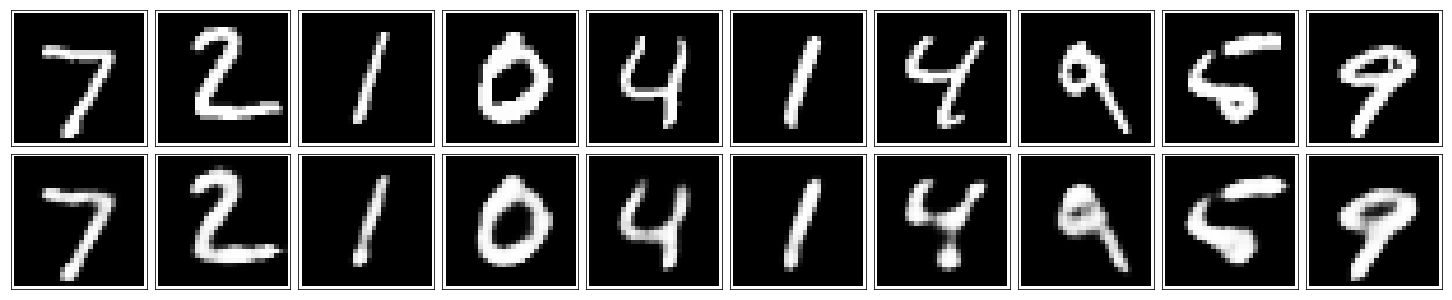

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
reconstructed = sess.run(decoded, feed_dict={inputs_: in_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


fig.tight_layout(pad=0.1)

In [10]:
sess.close()

## Denoising

As I've mentioned before, autoencoders like the ones you've built so far aren't too useful in practive. However, they can be used to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1. We'll use noisy images as input and the original, clean images as targets. Here's an example of the noisy images I generated and the denoised images.

![Denoising autoencoder](assets/denoising.png)


Since this is a harder problem for the network, we'll want to use deeper convolutional layers here, more feature maps. I suggest something like 32-32-16 for the depths of the convolutional layers in the encoder, and the same depths going backward through the decoder. Otherwise the architecture is the same as before.

> **Exercise:** Build the network for the denoising autoencoder. It's the same as before, but with deeper layers. I suggest 32-32-16 for the depths, but you can play with these numbers, or add more layers.

In [11]:
learning_rate = 0.001
# Input and target placeholders
image_size = (10,28,28,1)
inputs_ = tf.placeholder(tf.float32, shape=image_size, name='Inputs')
targets_ = tf.placeholder(tf.float32, shape=image_size, name="Targets")

### Encoder
conv1 = tf.layers.conv2d(inputs_, filters=32,kernel_size=(5,5), padding="same",activation=tf.nn.relu )
print(conv1.shape)
# Now 28x28x32
maxpool1 = tf.layers.max_pooling2d(conv1, pool_size=(2,2), strides=(2,2), padding="same" )
# Now 14x14x32
conv2 =  tf.layers.conv2d(maxpool1, filters=32,kernel_size=(5,5), padding="same",activation=tf.nn.relu )
print(conv2.shape)
# Now 14x14x32
maxpool2 = tf.layers.max_pooling2d(conv2, pool_size=(2,2), strides=(2,2), padding="same" )
# Now 7x7x32
conv3 = tf.layers.conv2d(maxpool2, filters=16,kernel_size=(5,5), padding="same",activation=tf.nn.relu )
# Now 7x7x16
print(conv3.shape)
encoded = tf.layers.max_pooling2d(conv3, pool_size=(2,2), strides=(2,2), padding="same" )
# Now 4x4x16
print(encoded.shape)


(10, 28, 28, 32)
(10, 14, 14, 32)
(10, 7, 7, 16)
(10, 4, 4, 16)


In [12]:
# using tf.nn.conv2d_transpose

temp_batch_size = 10

weights = {
  'wdc1' : tf.Variable(tf.random_normal([3, 3, 16, 16])),
  'wdc2' : tf.Variable(tf.random_normal([3, 3, 16, 16])),
  'wdc3' : tf.Variable(tf.random_normal([3, 3, 32, 16]))
}

# Now 4x4x16
output_shape = [temp_batch_size, 7, 7, 16]
conv4 = tf.nn.conv2d_transpose(encoded, weights['wdc1'], output_shape=output_shape, strides=[1,2,2,1], padding="SAME")
print(conv4.shape)
# Now 7x7x16
output_shape = [temp_batch_size, 14, 14, 16]
conv5 = tf.nn.conv2d_transpose(conv4, weights['wdc2'], output_shape=output_shape, strides=[1,2,2,1], padding="SAME")
print(conv5.shape)
#Now 14x14x16
output_shape = [temp_batch_size, 28, 28, 32]
conv6 = tf.nn.conv2d_transpose(conv5, weights['wdc3'], output_shape=output_shape, strides=[1,2,2,1], padding="SAME")
print(conv6.shape)
#Now 28x28x32

(10, 7, 7, 16)
(10, 14, 14, 16)
(10, 28, 28, 32)


In [13]:
logits = tf.layers.conv2d(conv6,filters=1,kernel_size=(3,3),padding="same", activation=None)
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded = tf.nn.sigmoid(logits)

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,labels=targets_)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [14]:
sess = tf.Session()

In [16]:
%%time
%%capture cap --no-stderr 

epochs = 100
batch_size = 10
# Set's how much noise we're adding to the MNIST images
noise_factor = 0.5
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        # Get images from the batch
        imgs = batch[0].reshape((-1, 28, 28, 1))
        
        # Add random noise to the input images
        noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        
        # Noisy images as inputs, original images as targets
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: noisy_imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

Wall time: 1h 15min 55s


In [17]:
with open('conv_autoencoder_denoise.txt', 'w') as f:
    f.write(cap.stdout)

## Checking out the performance

Here I'm adding noise to the test images and passing them through the autoencoder. It does a suprisingly great job of removing the noise, even though it's sometimes difficult to tell what the original number is.

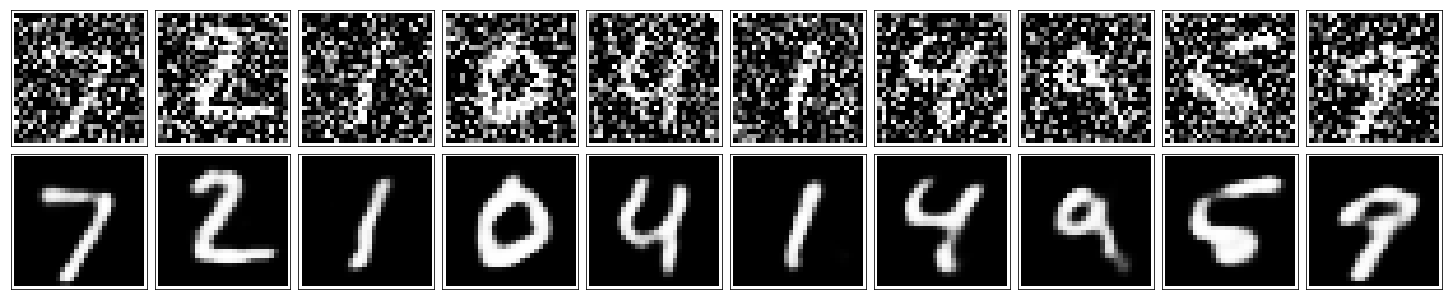

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
noisy_imgs = in_imgs + noise_factor * np.random.randn(*in_imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

reconstructed = sess.run(decoded, feed_dict={inputs_: noisy_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([noisy_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)